In [1355]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten

In [1357]:
# Define the paths to your data directories
train_data_dir = "/Users/norbujamling/Desktop/chinese-handwriting/CASIA-HWDB_Train/Train"
label_data_dir = "/Users/norbujamling/Desktop/Generated_Characters"


In [1381]:
# Define some constants
IMAGE_SIZE = (64, 64)
input_shape = (64,64,1)
BATCH_SIZE = 64


In [1383]:
# Function to load and preprocess images
def load_image(file_path):
    img = Image.open(file_path).convert('L')  # Convert to grayscale
    img = img.resize(IMAGE_SIZE)
    img = np.array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img

In [1385]:
# Function to create the generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))  
    model.add(layers.Dense(64*64*1, activation='sigmoid'))
    model.add(layers.Reshape((64, 64, 1)))
    return model

In [1387]:
generator = build_generator()
generator.summary()

Model: "sequential_377"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_226 (Flatten)           │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_333 (Dense)               │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 4096)           │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_51 (Reshape)            │ (None, 64, 64, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 528,448 (2.02 MB)

 Trainable params: 528,448 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

In [1393]:
# Function to create the discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(62, activation='relu'))  
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [1395]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_379"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_228 (Flatten)           │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_337 (Dense)               │ (None, 62)             │       254,014 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 1)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 254,077 (992.49 KB)

 Trainable params: 254,077 (992.49 KB)

 Non-trainable params: 0 (0.00 B)

In [1397]:
# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

# Freeze the discriminator's weights during combined model training
discriminator.trainable = False

# Define the combined model (GAN)
gan_input = layers.Input(shape=(*IMAGE_SIZE, 1))  # Grayscale image has 1 channel
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = models.Model(gan_input, gan_output)

# Compile the combined model
gan.compile(loss='binary_crossentropy', optimizer=optimizers.Adam())

In [1399]:
# Define a function to load and preprocess images
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=1)  # Assuming black and white PNG images
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
    return image

# Create datasets for real and labeled images using tf.data
real_dataset = tf.data.Dataset.list_files(train_data_dir + '/*/*.png')
real_dataset = real_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

labeled_dataset = tf.data.Dataset.list_files(label_data_dir + '/*.png')
labeled_dataset = labeled_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Combine real and labeled datasets using tf.data
dataset = tf.data.Dataset.zip((real_dataset, labeled_dataset)).shuffle(buffer_size=1000).batch(BATCH_SIZE)


In [ ]:
# Training loop
EPOCHS = 1000
for epoch in range(EPOCHS):
    # Iterate over batches in the dataset
    for real_images, labeled_images in dataset:
        # Train discriminator
        fake_images = generator.predict(labeled_images)
        real_labels = tf.ones((real_images.shape[0], 1))
        fake_labels = tf.zeros((fake_images.shape[0], 1))
        discriminator_loss_real = discriminator.train_on_batch(real_images, real_labels)
        discriminator_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        
        # Train generator (via combined model)
        gan_labels = tf.ones((labeled_images.shape[0], 1))
        gan_loss = gan.train_on_batch(labeled_images, gan_labels)
    
    # Print progress after each epoch
    print(f"Epoch {epoch+1}/{EPOCHS}, Discriminator Loss Real: {discriminator_loss_real[0]}, Discriminator Loss Fake: {discriminator_loss_fake[0]}, GAN Loss: {gan_loss}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/1000, Discriminator Loss Real: 12.289231300354004, Discriminator Loss Fake: 12.306790351867676, GAN Loss: [array(12.30679, dtype=float32), array(12.30679, dtype=float32), array(0.47580066, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:08.028710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 2/1000, Discriminator Loss Real: 12.292580604553223, Discriminator Loss Fake: 12.309974670410156, GAN Loss: [array(12.309975, dtype=float32), array(12.309975, dtype=float32), array(0.4756545, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:08.436747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 3/1000, Discriminator Loss Real: 12.295943260192871, Discriminator Loss Fake: 12.313172340393066, GAN Loss: [array(12.313172, dtype=float32), array(12.313172, dtype=float32), array(0.47561967, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:08.869138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 4/1000, Discriminator Loss Real: 12.299153327941895, Discriminator Loss Fake: 12.31618881225586, GAN Loss: [array(12.316189, dtype=float32), array(12.316189, dtype=float32), array(0.4757198, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:09.297876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 5/1000, Discriminator Loss Real: 12.302366256713867, Discriminator Loss Fake: 12.319243431091309, GAN Loss: [array(12.319243, dtype=float32), array(12.319243, dtype=float32), array(0.47573823, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:09.715056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 6/1000, Discriminator Loss Real: 12.305453300476074, Discriminator Loss Fake: 12.32216739654541, GAN Loss: [array(12.322167, dtype=float32), array(12.322167, dtype=float32), array(0.47565088, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:10.145679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
Epoch 7/1000, Discriminator Loss Real: 12.308466911315918, Discriminator Loss Fake: 12.325020790100098, GAN Loss: [array(12.325021, dtype=float32), array(12.325021, dtype=float32), array(0.4757479, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:10.567417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 8/1000, Discriminator Loss Real: 12.311442375183105, Discriminator Loss Fake: 12.32784366607666, GAN Loss: [array(12.327844, dtype=float32), array(12.327844, dtype=float32), array(0.47571385, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:11.005174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 9/1000, Discriminator Loss Real: 12.314396858215332, Discriminator Loss Fake: 12.33066177368164, GAN Loss: [array(12.330662, dtype=float32), array(12.330662, dtype=float32), array(0.4755779, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:11.430784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 10/1000, Discriminator Loss Real: 12.31728458404541, Discriminator Loss Fake: 12.333386421203613, GAN Loss: [array(12.333386, dtype=float32), array(12.333386, dtype=float32), array(0.47554597, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:11.863871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 11/1000, Discriminator Loss Real: 12.32016372680664, Discriminator Loss Fake: 12.336115837097168, GAN Loss: [array(12.336116, dtype=float32), array(12.336116, dtype=float32), array(0.47543913, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:12.288160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 12/1000, Discriminator Loss Real: 12.322979927062988, Discriminator Loss Fake: 12.338796615600586, GAN Loss: [array(12.338797, dtype=float32), array(12.338797, dtype=float32), array(0.47555867, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:12.710103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 13/1000, Discriminator Loss Real: 12.325773239135742, Discriminator Loss Fake: 12.341421127319336, GAN Loss: [array(12.341421, dtype=float32), array(12.341421, dtype=float32), array(0.47542888, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:13.143341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
Epoch 14/1000, Discriminator Loss Real: 12.328472137451172, Discriminator Loss Fake: 12.343984603881836, GAN Loss: [array(12.343985, dtype=float32), array(12.343985, dtype=float32), array(0.4754239, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:13.574742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 15/1000, Discriminator Loss Real: 12.331186294555664, Discriminator Loss Fake: 12.346553802490234, GAN Loss: [array(12.346554, dtype=float32), array(12.346554, dtype=float32), array(0.47527325, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:14.008342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 16/1000, Discriminator Loss Real: 12.333768844604492, Discriminator Loss Fake: 12.349010467529297, GAN Loss: [array(12.34901, dtype=float32), array(12.34901, dtype=float32), array(0.47536603, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:14.447621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 17/1000, Discriminator Loss Real: 12.336371421813965, Discriminator Loss Fake: 12.351466178894043, GAN Loss: [array(12.351466, dtype=float32), array(12.351466, dtype=float32), array(0.47533783, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:14.878887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 18/1000, Discriminator Loss Real: 12.33884334564209, Discriminator Loss Fake: 12.353829383850098, GAN Loss: [array(12.353829, dtype=float32), array(12.353829, dtype=float32), array(0.47533378, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:15.330263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 19/1000, Discriminator Loss Real: 12.341317176818848, Discriminator Loss Fake: 12.35617446899414, GAN Loss: [array(12.356174, dtype=float32), array(12.356174, dtype=float32), array(0.47528285, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:15.771313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 20/1000, Discriminator Loss Real: 12.343737602233887, Discriminator Loss Fake: 12.358474731445312, GAN Loss: [array(12.358475, dtype=float32), array(12.358475, dtype=float32), array(0.47527933, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:16.214866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 21/1000, Discriminator Loss Real: 12.346105575561523, Discriminator Loss Fake: 12.360743522644043, GAN Loss: [array(12.3607435, dtype=float32), array(12.3607435, dtype=float32), array(0.4753682, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:16.650192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 22/1000, Discriminator Loss Real: 12.348485946655273, Discriminator Loss Fake: 12.362977027893066, GAN Loss: [array(12.362977, dtype=float32), array(12.362977, dtype=float32), array(0.47538695, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:17.090352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
Epoch 23/1000, Discriminator Loss Real: 12.350847244262695, Discriminator Loss Fake: 12.365196228027344, GAN Loss: [array(12.365196, dtype=float32), array(12.365196, dtype=float32), array(0.47535995, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:17.529886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 24/1000, Discriminator Loss Real: 12.353132247924805, Discriminator Loss Fake: 12.367382049560547, GAN Loss: [array(12.367382, dtype=float32), array(12.367382, dtype=float32), array(0.4752658, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:17.976746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 25/1000, Discriminator Loss Real: 12.355395317077637, Discriminator Loss Fake: 12.369505882263184, GAN Loss: [array(12.369506, dtype=float32), array(12.369506, dtype=float32), array(0.4753296, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:18.414672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
Epoch 26/1000, Discriminator Loss Real: 12.357528686523438, Discriminator Loss Fake: 12.371545791625977, GAN Loss: [array(12.371546, dtype=float32), array(12.371546, dtype=float32), array(0.4753924, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2024-06-07 16:25:18.849113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
Epoch 27/1000, Discriminator Loss Real: 12.359713554382324, Discriminator Loss Fake: 12.373617172241211, GAN Loss: [array(12.373617, dtype=float32), array(12.373617, dtype=float32), array(0.4753882, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:19.289498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
Epoch 28/1000, Discriminator Loss Real: 12.361868858337402, Discriminator Loss Fake: 12.375652313232422, GAN Loss: [array(12.375652, dtype=float32), array(12.375652, dtype=float32), array(0.4753841, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:19.723823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 29/1000, Discriminator Loss Real: 12.363924026489258, Discriminator Loss Fake: 12.377618789672852, GAN Loss: [array(12.377619, dtype=float32), array(12.377619, dtype=float32), array(0.47538, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:20.150443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 30/1000, Discriminator Loss Real: 12.365982055664062, Discriminator Loss Fake: 12.379541397094727, GAN Loss: [array(12.379541, dtype=float32), array(12.379541, dtype=float32), array(0.47544047, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:20.580646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 31/1000, Discriminator Loss Real: 12.36799430847168, Discriminator Loss Fake: 12.38145637512207, GAN Loss: [array(12.381456, dtype=float32), array(12.381456, dtype=float32), array(0.47550002, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:21.026002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 32/1000, Discriminator Loss Real: 12.369983673095703, Discriminator Loss Fake: 12.383346557617188, GAN Loss: [array(12.383347, dtype=float32), array(12.383347, dtype=float32), array(0.47557983, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:21.459899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
Epoch 33/1000, Discriminator Loss Real: 12.37195110321045, Discriminator Loss Fake: 12.38521671295166, GAN Loss: [array(12.385217, dtype=float32), array(12.385217, dtype=float32), array(0.4755954, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:21.899369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 34/1000, Discriminator Loss Real: 12.37392807006836, Discriminator Loss Fake: 12.387066841125488, GAN Loss: [array(12.387067, dtype=float32), array(12.387067, dtype=float32), array(0.47567332, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:22.355750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 35/1000, Discriminator Loss Real: 12.375894546508789, Discriminator Loss Fake: 12.388925552368164, GAN Loss: [array(12.388926, dtype=float32), array(12.388926, dtype=float32), array(0.47558454, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:22.826458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 36/1000, Discriminator Loss Real: 12.377796173095703, Discriminator Loss Fake: 12.390735626220703, GAN Loss: [array(12.390736, dtype=float32), array(12.390736, dtype=float32), array(0.47555867, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2024-06-07 16:25:23.285307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 37/1000, Discriminator Loss Real: 12.379647254943848, Discriminator Loss Fake: 12.392524719238281, GAN Loss: [array(12.392525, dtype=float32), array(12.392525, dtype=float32), array(0.4755332, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


2024-06-07 16:25:23.736896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 38/1000, Discriminator Loss Real: 12.381479263305664, Discriminator Loss Fake: 12.39423942565918, GAN Loss: [array(12.394239, dtype=float32), array(12.394239, dtype=float32), array(0.47560927, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:24.178504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 39/1000, Discriminator Loss Real: 12.383284568786621, Discriminator Loss Fake: 12.395963668823242, GAN Loss: [array(12.395964, dtype=float32), array(12.395964, dtype=float32), array(0.47560388, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:24.618245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
Epoch 40/1000, Discriminator Loss Real: 12.385053634643555, Discriminator Loss Fake: 12.397624015808105, GAN Loss: [array(12.397624, dtype=float32), array(12.397624, dtype=float32), array(0.47555867, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


2024-06-07 16:25:25.052450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
Epoch 41/1000, Discriminator Loss Real: 12.386760711669922, Discriminator Loss Fake: 12.399255752563477, GAN Loss: [array(12.399256, dtype=float32), array(12.399256, dtype=float32), array(0.47559333, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:25.492016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 42/1000, Discriminator Loss Real: 12.38851261138916, Discriminator Loss Fake: 12.40091323852539, GAN Loss: [array(12.400913, dtype=float32), array(12.400913, dtype=float32), array(0.47558817, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:25.925719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 43/1000, Discriminator Loss Real: 12.390244483947754, Discriminator Loss Fake: 12.402560234069824, GAN Loss: [array(12.40256, dtype=float32), array(12.40256, dtype=float32), array(0.47558308, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:26.388863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
Epoch 44/1000, Discriminator Loss Real: 12.391921043395996, Discriminator Loss Fake: 12.404139518737793, GAN Loss: [array(12.4041395, dtype=float32), array(12.4041395, dtype=float32), array(0.47559744, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:26.845083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
Epoch 45/1000, Discriminator Loss Real: 12.393575668334961, Discriminator Loss Fake: 12.405713081359863, GAN Loss: [array(12.405713, dtype=float32), array(12.405713, dtype=float32), array(0.4755731, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:27.294820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 46/1000, Discriminator Loss Real: 12.395244598388672, Discriminator Loss Fake: 12.407286643981934, GAN Loss: [array(12.407287, dtype=float32), array(12.407287, dtype=float32), array(0.4756065, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:27.745911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
Epoch 47/1000, Discriminator Loss Real: 12.396848678588867, Discriminator Loss Fake: 12.408821105957031, GAN Loss: [array(12.408821, dtype=float32), array(12.408821, dtype=float32), array(0.47558242, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:28.193605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
Epoch 48/1000, Discriminator Loss Real: 12.398451805114746, Discriminator Loss Fake: 12.410351753234863, GAN Loss: [array(12.410352, dtype=float32), array(12.410352, dtype=float32), array(0.47557753, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


2024-06-07 16:25:28.635530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 49/1000, Discriminator Loss Real: 12.400026321411133, Discriminator Loss Fake: 12.411819458007812, GAN Loss: [array(12.411819, dtype=float32), array(12.411819, dtype=float32), array(0.47564772, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:29.110631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 50/1000, Discriminator Loss Real: 12.401564598083496, Discriminator Loss Fake: 12.413297653198242, GAN Loss: [array(12.413298, dtype=float32), array(12.413298, dtype=float32), array(0.47564247, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:29.565361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 51/1000, Discriminator Loss Real: 12.403117179870605, Discriminator Loss Fake: 12.41476821899414, GAN Loss: [array(12.414768, dtype=float32), array(12.414768, dtype=float32), array(0.4755818, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:30.008901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 52/1000, Discriminator Loss Real: 12.404693603515625, Discriminator Loss Fake: 12.416248321533203, GAN Loss: [array(12.416248, dtype=float32), array(12.416248, dtype=float32), array(0.47555867, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:30.464997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 53/1000, Discriminator Loss Real: 12.406177520751953, Discriminator Loss Fake: 12.41765022277832, GAN Loss: [array(12.41765, dtype=float32), array(12.41765, dtype=float32), array(0.47559062, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:30.923791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 54/1000, Discriminator Loss Real: 12.40766429901123, Discriminator Loss Fake: 12.419086456298828, GAN Loss: [array(12.419086, dtype=float32), array(12.419086, dtype=float32), array(0.47556773, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:31.387505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
Epoch 55/1000, Discriminator Loss Real: 12.409144401550293, Discriminator Loss Fake: 12.420492172241211, GAN Loss: [array(12.420492, dtype=float32), array(12.420492, dtype=float32), array(0.4755091, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2024-06-07 16:25:31.834213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 56/1000, Discriminator Loss Real: 12.410587310791016, Discriminator Loss Fake: 12.421860694885254, GAN Loss: [array(12.421861, dtype=float32), array(12.421861, dtype=float32), array(0.47543332, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:32.288797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 57/1000, Discriminator Loss Real: 12.411982536315918, Discriminator Loss Fake: 12.423186302185059, GAN Loss: [array(12.423186, dtype=float32), array(12.423186, dtype=float32), array(0.47542968, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:32.743498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 58/1000, Discriminator Loss Real: 12.41340446472168, Discriminator Loss Fake: 12.424531936645508, GAN Loss: [array(12.424532, dtype=float32), array(12.424532, dtype=float32), array(0.47531998, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:33.203884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 59/1000, Discriminator Loss Real: 12.414785385131836, Discriminator Loss Fake: 12.425840377807617, GAN Loss: [array(12.42584, dtype=float32), array(12.42584, dtype=float32), array(0.4752644, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:33.660078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 60/1000, Discriminator Loss Real: 12.416132926940918, Discriminator Loss Fake: 12.42711353302002, GAN Loss: [array(12.427114, dtype=float32), array(12.427114, dtype=float32), array(0.47522697, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:34.132663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
Epoch 61/1000, Discriminator Loss Real: 12.417500495910645, Discriminator Loss Fake: 12.42841625213623, GAN Loss: [array(12.428416, dtype=float32), array(12.428416, dtype=float32), array(0.47520733, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:34.581695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
Epoch 62/1000, Discriminator Loss Real: 12.418852806091309, Discriminator Loss Fake: 12.429693222045898, GAN Loss: [array(12.429693, dtype=float32), array(12.429693, dtype=float32), array(0.4752914, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


2024-06-07 16:25:35.035972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
Epoch 63/1000, Discriminator Loss Real: 12.420149803161621, Discriminator Loss Fake: 12.430924415588379, GAN Loss: [array(12.430924, dtype=float32), array(12.430924, dtype=float32), array(0.47523734, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


2024-06-07 16:25:35.488647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 64/1000, Discriminator Loss Real: 12.421507835388184, Discriminator Loss Fake: 12.432209014892578, GAN Loss: [array(12.432209, dtype=float32), array(12.432209, dtype=float32), array(0.47521803, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:35.950877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 65/1000, Discriminator Loss Real: 12.422786712646484, Discriminator Loss Fake: 12.433428764343262, GAN Loss: [array(12.433429, dtype=float32), array(12.433429, dtype=float32), array(0.47528356, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2024-06-07 16:25:36.421682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 66/1000, Discriminator Loss Real: 12.424087524414062, Discriminator Loss Fake: 12.434653282165527, GAN Loss: [array(12.434653, dtype=float32), array(12.434653, dtype=float32), array(0.47524735, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2024-06-07 16:25:36.885123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 67/1000, Discriminator Loss Real: 12.425314903259277, Discriminator Loss Fake: 12.435802459716797, GAN Loss: [array(12.435802, dtype=float32), array(12.435802, dtype=float32), array(0.4752785, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:37.347202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 68/1000, Discriminator Loss Real: 12.426523208618164, Discriminator Loss Fake: 12.436964988708496, GAN Loss: [array(12.436965, dtype=float32), array(12.436965, dtype=float32), array(0.475276, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:37.804078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 69/1000, Discriminator Loss Real: 12.42773151397705, Discriminator Loss Fake: 12.438117027282715, GAN Loss: [array(12.438117, dtype=float32), array(12.438117, dtype=float32), array(0.47529006, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:38.268267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
Epoch 70/1000, Discriminator Loss Real: 12.428894996643066, Discriminator Loss Fake: 12.439218521118164, GAN Loss: [array(12.4392185, dtype=float32), array(12.4392185, dtype=float32), array(0.47535327, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:38.737088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 71/1000, Discriminator Loss Real: 12.430159568786621, Discriminator Loss Fake: 12.440399169921875, GAN Loss: [array(12.440399, dtype=float32), array(12.440399, dtype=float32), array(0.47538304, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


2024-06-07 16:25:39.207545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 72/1000, Discriminator Loss Real: 12.431323051452637, Discriminator Loss Fake: 12.441526412963867, GAN Loss: [array(12.441526, dtype=float32), array(12.441526, dtype=float32), array(0.47534755, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:39.682299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 73/1000, Discriminator Loss Real: 12.43248176574707, Discriminator Loss Fake: 12.442602157592773, GAN Loss: [array(12.442602, dtype=float32), array(12.442602, dtype=float32), array(0.47536087, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2024-06-07 16:25:40.152787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
Epoch 74/1000, Discriminator Loss Real: 12.433632850646973, Discriminator Loss Fake: 12.443717956542969, GAN Loss: [array(12.443718, dtype=float32), array(12.443718, dtype=float32), array(0.47537404, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:40.617924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
Epoch 75/1000, Discriminator Loss Real: 12.434775352478027, Discriminator Loss Fake: 12.444804191589355, GAN Loss: [array(12.444804, dtype=float32), array(12.444804, dtype=float32), array(0.47538707, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:41.090297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 76/1000, Discriminator Loss Real: 12.435941696166992, Discriminator Loss Fake: 12.445886611938477, GAN Loss: [array(12.445887, dtype=float32), array(12.445887, dtype=float32), array(0.47541583, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


2024-06-07 16:25:41.557043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 77/1000, Discriminator Loss Real: 12.437002182006836, Discriminator Loss Fake: 12.446918487548828, GAN Loss: [array(12.4469185, dtype=float32), array(12.4469185, dtype=float32), array(0.47547582, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


2024-06-07 16:25:42.030334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 78/1000, Discriminator Loss Real: 12.438075065612793, Discriminator Loss Fake: 12.447929382324219, GAN Loss: [array(12.447929, dtype=float32), array(12.447929, dtype=float32), array(0.47547236, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:42.507135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
Epoch 79/1000, Discriminator Loss Real: 12.43916130065918, Discriminator Loss Fake: 12.448943138122559, GAN Loss: [array(12.448943, dtype=float32), array(12.448943, dtype=float32), array(0.47548455, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:42.974173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
Epoch 80/1000, Discriminator Loss Real: 12.440244674682617, Discriminator Loss Fake: 12.44998836517334, GAN Loss: [array(12.449988, dtype=float32), array(12.449988, dtype=float32), array(0.47545004, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:43.456716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 81/1000, Discriminator Loss Real: 12.441291809082031, Discriminator Loss Fake: 12.450983047485352, GAN Loss: [array(12.450983, dtype=float32), array(12.450983, dtype=float32), array(0.47541592, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


2024-06-07 16:25:43.934781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 82/1000, Discriminator Loss Real: 12.442317008972168, Discriminator Loss Fake: 12.451959609985352, GAN Loss: [array(12.45196, dtype=float32), array(12.45196, dtype=float32), array(0.4754589, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


2024-06-07 16:25:44.412987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 83/1000, Discriminator Loss Real: 12.443397521972656, Discriminator Loss Fake: 12.452980041503906, GAN Loss: [array(12.45298, dtype=float32), array(12.45298, dtype=float32), array(0.47550142, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:44.895642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 84/1000, Discriminator Loss Real: 12.444450378417969, Discriminator Loss Fake: 12.453960418701172, GAN Loss: [array(12.45396, dtype=float32), array(12.45396, dtype=float32), array(0.47557384, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:45.394800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
Epoch 85/1000, Discriminator Loss Real: 12.44542121887207, Discriminator Loss Fake: 12.454895973205566, GAN Loss: [array(12.454896, dtype=float32), array(12.454896, dtype=float32), array(0.47560018, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:45.885560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 86/1000, Discriminator Loss Real: 12.446459770202637, Discriminator Loss Fake: 12.455870628356934, GAN Loss: [array(12.455871, dtype=float32), array(12.455871, dtype=float32), array(0.47556618, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:46.373301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
Epoch 87/1000, Discriminator Loss Real: 12.447447776794434, Discriminator Loss Fake: 12.456808090209961, GAN Loss: [array(12.456808, dtype=float32), array(12.456808, dtype=float32), array(0.47560722, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:46.880368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 88/1000, Discriminator Loss Real: 12.448383331298828, Discriminator Loss Fake: 12.457712173461914, GAN Loss: [array(12.457712, dtype=float32), array(12.457712, dtype=float32), array(0.47563294, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:47.367538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 89/1000, Discriminator Loss Real: 12.449384689331055, Discriminator Loss Fake: 12.458648681640625, GAN Loss: [array(12.458649, dtype=float32), array(12.458649, dtype=float32), array(0.47562885, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:47.859766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 90/1000, Discriminator Loss Real: 12.450308799743652, Discriminator Loss Fake: 12.459528923034668, GAN Loss: [array(12.459529, dtype=float32), array(12.459529, dtype=float32), array(0.47562483, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


2024-06-07 16:25:48.350723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
Epoch 91/1000, Discriminator Loss Real: 12.45127010345459, Discriminator Loss Fake: 12.460463523864746, GAN Loss: [array(12.460464, dtype=float32), array(12.460464, dtype=float32), array(0.47565007, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:48.834977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 92/1000, Discriminator Loss Real: 12.452241897583008, Discriminator Loss Fake: 12.461365699768066, GAN Loss: [array(12.461366, dtype=float32), array(12.461366, dtype=float32), array(0.47561684, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


2024-06-07 16:25:49.326146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 93/1000, Discriminator Loss Real: 12.453191757202148, Discriminator Loss Fake: 12.462254524230957, GAN Loss: [array(12.462255, dtype=float32), array(12.462255, dtype=float32), array(0.47559845, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:49.820224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
Epoch 94/1000, Discriminator Loss Real: 12.454072952270508, Discriminator Loss Fake: 12.463106155395508, GAN Loss: [array(12.463106, dtype=float32), array(12.463106, dtype=float32), array(0.47568104, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:50.334089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 95/1000, Discriminator Loss Real: 12.455000877380371, Discriminator Loss Fake: 12.463971138000488, GAN Loss: [array(12.463971, dtype=float32), array(12.463971, dtype=float32), array(0.4756482, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:25:50.828959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 96/1000, Discriminator Loss Real: 12.45590877532959, Discriminator Loss Fake: 12.464838027954102, GAN Loss: [array(12.464838, dtype=float32), array(12.464838, dtype=float32), array(0.47567266, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:51.342121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 97/1000, Discriminator Loss Real: 12.456791877746582, Discriminator Loss Fake: 12.46568775177002, GAN Loss: [array(12.465688, dtype=float32), array(12.465688, dtype=float32), array(0.47568274, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:51.840241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 98/1000, Discriminator Loss Real: 12.4576997756958, Discriminator Loss Fake: 12.466535568237305, GAN Loss: [array(12.466536, dtype=float32), array(12.466536, dtype=float32), array(0.47567856, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:52.346041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 99/1000, Discriminator Loss Real: 12.458561897277832, Discriminator Loss Fake: 12.467353820800781, GAN Loss: [array(12.467354, dtype=float32), array(12.467354, dtype=float32), array(0.47567445, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:52.868070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 100/1000, Discriminator Loss Real: 12.459418296813965, Discriminator Loss Fake: 12.468157768249512, GAN Loss: [array(12.468158, dtype=float32), array(12.468158, dtype=float32), array(0.47574022, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:53.365779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 101/1000, Discriminator Loss Real: 12.460260391235352, Discriminator Loss Fake: 12.46897029876709, GAN Loss: [array(12.46897, dtype=float32), array(12.46897, dtype=float32), array(0.47577754, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:53.871212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 102/1000, Discriminator Loss Real: 12.461129188537598, Discriminator Loss Fake: 12.46979808807373, GAN Loss: [array(12.469798, dtype=float32), array(12.469798, dtype=float32), array(0.47573152, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:54.365242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 103/1000, Discriminator Loss Real: 12.462011337280273, Discriminator Loss Fake: 12.470620155334473, GAN Loss: [array(12.47062, dtype=float32), array(12.47062, dtype=float32), array(0.4757685, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:54.877325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 104/1000, Discriminator Loss Real: 12.46281909942627, Discriminator Loss Fake: 12.47140884399414, GAN Loss: [array(12.471409, dtype=float32), array(12.471409, dtype=float32), array(0.47575036, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:55.382811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 105/1000, Discriminator Loss Real: 12.463659286499023, Discriminator Loss Fake: 12.472199440002441, GAN Loss: [array(12.472199, dtype=float32), array(12.472199, dtype=float32), array(0.4757324, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:55.900651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 106/1000, Discriminator Loss Real: 12.464473724365234, Discriminator Loss Fake: 12.472975730895996, GAN Loss: [array(12.472976, dtype=float32), array(12.472976, dtype=float32), array(0.4757417, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:56.419894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 107/1000, Discriminator Loss Real: 12.4652738571167, Discriminator Loss Fake: 12.473729133605957, GAN Loss: [array(12.473729, dtype=float32), array(12.473729, dtype=float32), array(0.47579142, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:56.936340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 108/1000, Discriminator Loss Real: 12.46611499786377, Discriminator Loss Fake: 12.474517822265625, GAN Loss: [array(12.474518, dtype=float32), array(12.474518, dtype=float32), array(0.47570637, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:57.456326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 109/1000, Discriminator Loss Real: 12.466912269592285, Discriminator Loss Fake: 12.475285530090332, GAN Loss: [array(12.475286, dtype=float32), array(12.475286, dtype=float32), array(0.47568896, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:57.978015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 110/1000, Discriminator Loss Real: 12.467707633972168, Discriminator Loss Fake: 12.47603988647461, GAN Loss: [array(12.47604, dtype=float32), array(12.47604, dtype=float32), array(0.47569832, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:25:58.490607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 111/1000, Discriminator Loss Real: 12.468499183654785, Discriminator Loss Fake: 12.476783752441406, GAN Loss: [array(12.476784, dtype=float32), array(12.476784, dtype=float32), array(0.4757076, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:59.011531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 112/1000, Discriminator Loss Real: 12.46926498413086, Discriminator Loss Fake: 12.477503776550293, GAN Loss: [array(12.477504, dtype=float32), array(12.477504, dtype=float32), array(0.47574311, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:25:59.533557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 113/1000, Discriminator Loss Real: 12.4700288772583, Discriminator Loss Fake: 12.478246688842773, GAN Loss: [array(12.478247, dtype=float32), array(12.478247, dtype=float32), array(0.47563407, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:26:00.055586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 114/1000, Discriminator Loss Real: 12.470794677734375, Discriminator Loss Fake: 12.478973388671875, GAN Loss: [array(12.478973, dtype=float32), array(12.478973, dtype=float32), array(0.47566962, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:00.563008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 115/1000, Discriminator Loss Real: 12.471576690673828, Discriminator Loss Fake: 12.47971248626709, GAN Loss: [array(12.4797125, dtype=float32), array(12.4797125, dtype=float32), array(0.47565284, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:01.065420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 116/1000, Discriminator Loss Real: 12.472311019897461, Discriminator Loss Fake: 12.480424880981445, GAN Loss: [array(12.480425, dtype=float32), array(12.480425, dtype=float32), array(0.47561038, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step


2024-06-07 16:26:01.579297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 117/1000, Discriminator Loss Real: 12.473097801208496, Discriminator Loss Fake: 12.481147766113281, GAN Loss: [array(12.481148, dtype=float32), array(12.481148, dtype=float32), array(0.4756198, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:02.079298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 118/1000, Discriminator Loss Real: 12.473862648010254, Discriminator Loss Fake: 12.481863975524902, GAN Loss: [array(12.481864, dtype=float32), array(12.481864, dtype=float32), array(0.47562912, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


2024-06-07 16:26:02.579616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
Epoch 119/1000, Discriminator Loss Real: 12.474579811096191, Discriminator Loss Fake: 12.482572555541992, GAN Loss: [array(12.482573, dtype=float32), array(12.482573, dtype=float32), array(0.4756384, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:03.087235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
Epoch 120/1000, Discriminator Loss Real: 12.475316047668457, Discriminator Loss Fake: 12.48326301574707, GAN Loss: [array(12.483263, dtype=float32), array(12.483263, dtype=float32), array(0.47566023, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:03.590240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 121/1000, Discriminator Loss Real: 12.476043701171875, Discriminator Loss Fake: 12.48394775390625, GAN Loss: [array(12.483948, dtype=float32), array(12.483948, dtype=float32), array(0.4756187, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:04.084466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
Epoch 122/1000, Discriminator Loss Real: 12.476726531982422, Discriminator Loss Fake: 12.484601974487305, GAN Loss: [array(12.484602, dtype=float32), array(12.484602, dtype=float32), array(0.4756027, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


2024-06-07 16:26:04.592881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 123/1000, Discriminator Loss Real: 12.477400779724121, Discriminator Loss Fake: 12.485240936279297, GAN Loss: [array(12.485241, dtype=float32), array(12.485241, dtype=float32), array(0.4756119, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:05.097747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
Epoch 124/1000, Discriminator Loss Real: 12.47813606262207, Discriminator Loss Fake: 12.48592758178711, GAN Loss: [array(12.485928, dtype=float32), array(12.485928, dtype=float32), array(0.47559607, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:05.607191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 125/1000, Discriminator Loss Real: 12.47883129119873, Discriminator Loss Fake: 12.486594200134277, GAN Loss: [array(12.486594, dtype=float32), array(12.486594, dtype=float32), array(0.47554314, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step


2024-06-07 16:26:06.111328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
Epoch 126/1000, Discriminator Loss Real: 12.479531288146973, Discriminator Loss Fake: 12.487266540527344, GAN Loss: [array(12.487267, dtype=float32), array(12.487267, dtype=float32), array(0.47547832, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:06.622781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 127/1000, Discriminator Loss Real: 12.480222702026367, Discriminator Loss Fake: 12.48791217803955, GAN Loss: [array(12.487912, dtype=float32), array(12.487912, dtype=float32), array(0.4754633, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:07.127316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 128/1000, Discriminator Loss Real: 12.480892181396484, Discriminator Loss Fake: 12.488560676574707, GAN Loss: [array(12.488561, dtype=float32), array(12.488561, dtype=float32), array(0.4754239, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:07.660675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 129/1000, Discriminator Loss Real: 12.481575012207031, Discriminator Loss Fake: 12.489201545715332, GAN Loss: [array(12.489202, dtype=float32), array(12.489202, dtype=float32), array(0.47544584, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:08.185471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 130/1000, Discriminator Loss Real: 12.482276916503906, Discriminator Loss Fake: 12.489867210388184, GAN Loss: [array(12.489867, dtype=float32), array(12.489867, dtype=float32), array(0.4753704, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:08.718293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 131/1000, Discriminator Loss Real: 12.48294448852539, Discriminator Loss Fake: 12.490511894226074, GAN Loss: [array(12.490512, dtype=float32), array(12.490512, dtype=float32), array(0.47534403, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:09.251624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 132/1000, Discriminator Loss Real: 12.483591079711914, Discriminator Loss Fake: 12.491109848022461, GAN Loss: [array(12.49111, dtype=float32), array(12.49111, dtype=float32), array(0.47536603, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:09.766395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 133/1000, Discriminator Loss Real: 12.484221458435059, Discriminator Loss Fake: 12.491719245910645, GAN Loss: [array(12.491719, dtype=float32), array(12.491719, dtype=float32), array(0.47532788, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:10.296953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 134/1000, Discriminator Loss Real: 12.484855651855469, Discriminator Loss Fake: 12.492330551147461, GAN Loss: [array(12.492331, dtype=float32), array(12.492331, dtype=float32), array(0.47533783, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:10.821722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 135/1000, Discriminator Loss Real: 12.485514640808105, Discriminator Loss Fake: 12.492940902709961, GAN Loss: [array(12.492941, dtype=float32), array(12.492941, dtype=float32), array(0.47532392, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:11.341033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 136/1000, Discriminator Loss Real: 12.48611831665039, Discriminator Loss Fake: 12.493521690368652, GAN Loss: [array(12.493522, dtype=float32), array(12.493522, dtype=float32), array(0.47533378, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:11.876549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 137/1000, Discriminator Loss Real: 12.4867582321167, Discriminator Loss Fake: 12.494115829467773, GAN Loss: [array(12.494116, dtype=float32), array(12.494116, dtype=float32), array(0.47531998, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:12.405941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 138/1000, Discriminator Loss Real: 12.4873685836792, Discriminator Loss Fake: 12.494696617126465, GAN Loss: [array(12.494697, dtype=float32), array(12.494697, dtype=float32), array(0.47535327, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:12.968552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 139/1000, Discriminator Loss Real: 12.487993240356445, Discriminator Loss Fake: 12.49528980255127, GAN Loss: [array(12.49529, dtype=float32), array(12.49529, dtype=float32), array(0.47532782, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:13.505978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 140/1000, Discriminator Loss Real: 12.488600730895996, Discriminator Loss Fake: 12.495869636535645, GAN Loss: [array(12.49587, dtype=float32), array(12.49587, dtype=float32), array(0.4753841, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:14.025751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 141/1000, Discriminator Loss Real: 12.48916244506836, Discriminator Loss Fake: 12.496416091918945, GAN Loss: [array(12.496416, dtype=float32), array(12.496416, dtype=float32), array(0.4754167, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step


2024-06-07 16:26:14.549349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 142/1000, Discriminator Loss Real: 12.489747047424316, Discriminator Loss Fake: 12.49696159362793, GAN Loss: [array(12.496962, dtype=float32), array(12.496962, dtype=float32), array(0.4753913, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:15.076757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 143/1000, Discriminator Loss Real: 12.490315437316895, Discriminator Loss Fake: 12.497501373291016, GAN Loss: [array(12.497501, dtype=float32), array(12.497501, dtype=float32), array(0.47536612, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:15.600257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
Epoch 144/1000, Discriminator Loss Real: 12.490887641906738, Discriminator Loss Fake: 12.498039245605469, GAN Loss: [array(12.498039, dtype=float32), array(12.498039, dtype=float32), array(0.47542128, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:16.123816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 145/1000, Discriminator Loss Real: 12.491455078125, Discriminator Loss Fake: 12.498580932617188, GAN Loss: [array(12.498581, dtype=float32), array(12.498581, dtype=float32), array(0.4754076, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


2024-06-07 16:26:16.667409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 146/1000, Discriminator Loss Real: 12.492005348205566, Discriminator Loss Fake: 12.49911117553711, GAN Loss: [array(12.499111, dtype=float32), array(12.499111, dtype=float32), array(0.47542807, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:17.199421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 147/1000, Discriminator Loss Real: 12.492581367492676, Discriminator Loss Fake: 12.499649047851562, GAN Loss: [array(12.499649, dtype=float32), array(12.499649, dtype=float32), array(0.47542578, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


2024-06-07 16:26:17.716292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 148/1000, Discriminator Loss Real: 12.493157386779785, Discriminator Loss Fake: 12.500186920166016, GAN Loss: [array(12.500187, dtype=float32), array(12.500187, dtype=float32), array(0.47545728, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:18.251230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 149/1000, Discriminator Loss Real: 12.493704795837402, Discriminator Loss Fake: 12.500713348388672, GAN Loss: [array(12.500713, dtype=float32), array(12.500713, dtype=float32), array(0.47543246, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


2024-06-07 16:26:18.774054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
Epoch 150/1000, Discriminator Loss Real: 12.494264602661133, Discriminator Loss Fake: 12.501248359680176, GAN Loss: [array(12.501248, dtype=float32), array(12.501248, dtype=float32), array(0.4754078, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:19.307736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 151/1000, Discriminator Loss Real: 12.494790077209473, Discriminator Loss Fake: 12.501749038696289, GAN Loss: [array(12.501749, dtype=float32), array(12.501749, dtype=float32), array(0.4754279, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step


2024-06-07 16:26:19.828075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 152/1000, Discriminator Loss Real: 12.495330810546875, Discriminator Loss Fake: 12.502257347106934, GAN Loss: [array(12.502257, dtype=float32), array(12.502257, dtype=float32), array(0.47542563, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:20.355699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 153/1000, Discriminator Loss Real: 12.495918273925781, Discriminator Loss Fake: 12.502802848815918, GAN Loss: [array(12.502803, dtype=float32), array(12.502803, dtype=float32), array(0.47541237, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:20.893681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
Epoch 154/1000, Discriminator Loss Real: 12.496448516845703, Discriminator Loss Fake: 12.503315925598145, GAN Loss: [array(12.503316, dtype=float32), array(12.503316, dtype=float32), array(0.4754322, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:21.423900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
Epoch 155/1000, Discriminator Loss Real: 12.49697208404541, Discriminator Loss Fake: 12.503826141357422, GAN Loss: [array(12.503826, dtype=float32), array(12.503826, dtype=float32), array(0.47541898, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


2024-06-07 16:26:21.970738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
Epoch 156/1000, Discriminator Loss Real: 12.49752140045166, Discriminator Loss Fake: 12.50433349609375, GAN Loss: [array(12.5043335, dtype=float32), array(12.5043335, dtype=float32), array(0.47546047, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


2024-06-07 16:26:22.503495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 157/1000, Discriminator Loss Real: 12.498044967651367, Discriminator Loss Fake: 12.504827499389648, GAN Loss: [array(12.5048275, dtype=float32), array(12.5048275, dtype=float32), array(0.47549072, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:23.052477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 158/1000, Discriminator Loss Real: 12.498542785644531, Discriminator Loss Fake: 12.505309104919434, GAN Loss: [array(12.505309, dtype=float32), array(12.505309, dtype=float32), array(0.47550994, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:23.582933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 159/1000, Discriminator Loss Real: 12.499056816101074, Discriminator Loss Fake: 12.505792617797852, GAN Loss: [array(12.505793, dtype=float32), array(12.505793, dtype=float32), array(0.47556135, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:24.123076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
Epoch 160/1000, Discriminator Loss Real: 12.499552726745605, Discriminator Loss Fake: 12.506261825561523, GAN Loss: [array(12.506262, dtype=float32), array(12.506262, dtype=float32), array(0.47558016, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:24.665098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 161/1000, Discriminator Loss Real: 12.500093460083008, Discriminator Loss Fake: 12.506775856018066, GAN Loss: [array(12.506776, dtype=float32), array(12.506776, dtype=float32), array(0.4755239, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:25.200594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 162/1000, Discriminator Loss Real: 12.500595092773438, Discriminator Loss Fake: 12.507262229919434, GAN Loss: [array(12.507262, dtype=float32), array(12.507262, dtype=float32), array(0.475532, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:25.741873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
Epoch 163/1000, Discriminator Loss Real: 12.501110076904297, Discriminator Loss Fake: 12.507746696472168, GAN Loss: [array(12.507747, dtype=float32), array(12.507747, dtype=float32), array(0.47547635, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


2024-06-07 16:26:26.282524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 164/1000, Discriminator Loss Real: 12.501611709594727, Discriminator Loss Fake: 12.50822925567627, GAN Loss: [array(12.508229, dtype=float32), array(12.508229, dtype=float32), array(0.47543168, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:26.814634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 165/1000, Discriminator Loss Real: 12.502086639404297, Discriminator Loss Fake: 12.508676528930664, GAN Loss: [array(12.508677, dtype=float32), array(12.508677, dtype=float32), array(0.4754506, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


2024-06-07 16:26:27.355999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 166/1000, Discriminator Loss Real: 12.502570152282715, Discriminator Loss Fake: 12.509134292602539, GAN Loss: [array(12.509134, dtype=float32), array(12.509134, dtype=float32), array(0.4754379, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:27.897058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 167/1000, Discriminator Loss Real: 12.503090858459473, Discriminator Loss Fake: 12.509620666503906, GAN Loss: [array(12.509621, dtype=float32), array(12.509621, dtype=float32), array(0.47542527, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:28.434829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 168/1000, Discriminator Loss Real: 12.503562927246094, Discriminator Loss Fake: 12.5100679397583, GAN Loss: [array(12.510068, dtype=float32), array(12.510068, dtype=float32), array(0.47544402, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:28.984496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
Epoch 169/1000, Discriminator Loss Real: 12.504014015197754, Discriminator Loss Fake: 12.510501861572266, GAN Loss: [array(12.510502, dtype=float32), array(12.510502, dtype=float32), array(0.47546262, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:29.536886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 170/1000, Discriminator Loss Real: 12.504510879516602, Discriminator Loss Fake: 12.510974884033203, GAN Loss: [array(12.510975, dtype=float32), array(12.510975, dtype=float32), array(0.4754397, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:30.100057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 171/1000, Discriminator Loss Real: 12.504977226257324, Discriminator Loss Fake: 12.511408805847168, GAN Loss: [array(12.511409, dtype=float32), array(12.511409, dtype=float32), array(0.47547877, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:26:30.641373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 172/1000, Discriminator Loss Real: 12.505437850952148, Discriminator Loss Fake: 12.511855125427246, GAN Loss: [array(12.511855, dtype=float32), array(12.511855, dtype=float32), array(0.4754765, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:31.208396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 173/1000, Discriminator Loss Real: 12.50589370727539, Discriminator Loss Fake: 12.51227855682373, GAN Loss: [array(12.512279, dtype=float32), array(12.512279, dtype=float32), array(0.47547424, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:31.757030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 174/1000, Discriminator Loss Real: 12.506367683410645, Discriminator Loss Fake: 12.512728691101074, GAN Loss: [array(12.512729, dtype=float32), array(12.512729, dtype=float32), array(0.4754618, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:32.326690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 175/1000, Discriminator Loss Real: 12.506779670715332, Discriminator Loss Fake: 12.513128280639648, GAN Loss: [array(12.513128, dtype=float32), array(12.513128, dtype=float32), array(0.4754901, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:32.896550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 176/1000, Discriminator Loss Real: 12.50723648071289, Discriminator Loss Fake: 12.51355266571045, GAN Loss: [array(12.513553, dtype=float32), array(12.513553, dtype=float32), array(0.4755283, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:33.478106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 177/1000, Discriminator Loss Real: 12.507695198059082, Discriminator Loss Fake: 12.5139799118042, GAN Loss: [array(12.51398, dtype=float32), array(12.51398, dtype=float32), array(0.4755158, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:34.041881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 178/1000, Discriminator Loss Real: 12.508161544799805, Discriminator Loss Fake: 12.51444149017334, GAN Loss: [array(12.5144415, dtype=float32), array(12.5144415, dtype=float32), array(0.47550339, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:26:34.595345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 179/1000, Discriminator Loss Real: 12.508609771728516, Discriminator Loss Fake: 12.514860153198242, GAN Loss: [array(12.51486, dtype=float32), array(12.51486, dtype=float32), array(0.47552112, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:35.171043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 180/1000, Discriminator Loss Real: 12.50905704498291, Discriminator Loss Fake: 12.51528549194336, GAN Loss: [array(12.5152855, dtype=float32), array(12.5152855, dtype=float32), array(0.47550878, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:35.719958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 181/1000, Discriminator Loss Real: 12.509501457214355, Discriminator Loss Fake: 12.515701293945312, GAN Loss: [array(12.515701, dtype=float32), array(12.515701, dtype=float32), array(0.47549653, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:26:36.290866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 182/1000, Discriminator Loss Real: 12.509921073913574, Discriminator Loss Fake: 12.516101837158203, GAN Loss: [array(12.516102, dtype=float32), array(12.516102, dtype=float32), array(0.47555372, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:36.880418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 183/1000, Discriminator Loss Real: 12.510377883911133, Discriminator Loss Fake: 12.5165376663208, GAN Loss: [array(12.516538, dtype=float32), array(12.516538, dtype=float32), array(0.47554138, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:37.466151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 184/1000, Discriminator Loss Real: 12.510797500610352, Discriminator Loss Fake: 12.516939163208008, GAN Loss: [array(12.516939, dtype=float32), array(12.516939, dtype=float32), array(0.475539, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:38.039898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 185/1000, Discriminator Loss Real: 12.511231422424316, Discriminator Loss Fake: 12.517342567443848, GAN Loss: [array(12.517343, dtype=float32), array(12.517343, dtype=float32), array(0.4755072, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:26:38.618744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 186/1000, Discriminator Loss Real: 12.511676788330078, Discriminator Loss Fake: 12.517762184143066, GAN Loss: [array(12.517762, dtype=float32), array(12.517762, dtype=float32), array(0.47547564, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:39.189660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 187/1000, Discriminator Loss Real: 12.51207447052002, Discriminator Loss Fake: 12.518142700195312, GAN Loss: [array(12.518143, dtype=float32), array(12.518143, dtype=float32), array(0.4755027, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:39.760750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 188/1000, Discriminator Loss Real: 12.512473106384277, Discriminator Loss Fake: 12.518528938293457, GAN Loss: [array(12.518529, dtype=float32), array(12.518529, dtype=float32), array(0.47551015, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:40.376107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 189/1000, Discriminator Loss Real: 12.512898445129395, Discriminator Loss Fake: 12.51893424987793, GAN Loss: [array(12.518934, dtype=float32), array(12.518934, dtype=float32), array(0.47548857, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:40.958937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
Epoch 190/1000, Discriminator Loss Real: 12.513294219970703, Discriminator Loss Fake: 12.519296646118164, GAN Loss: [array(12.519297, dtype=float32), array(12.519297, dtype=float32), array(0.47549605, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


2024-06-07 16:26:41.517417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 191/1000, Discriminator Loss Real: 12.513704299926758, Discriminator Loss Fake: 12.519707679748535, GAN Loss: [array(12.519708, dtype=float32), array(12.519708, dtype=float32), array(0.47545546, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:42.096894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
Epoch 192/1000, Discriminator Loss Real: 12.514123916625977, Discriminator Loss Fake: 12.520099639892578, GAN Loss: [array(12.5201, dtype=float32), array(12.5201, dtype=float32), array(0.47544387, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:42.661271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 193/1000, Discriminator Loss Real: 12.514554977416992, Discriminator Loss Fake: 12.5205078125, GAN Loss: [array(12.520508, dtype=float32), array(12.520508, dtype=float32), array(0.4754228, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:26:43.224252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 194/1000, Discriminator Loss Real: 12.514957427978516, Discriminator Loss Fake: 12.520885467529297, GAN Loss: [array(12.520885, dtype=float32), array(12.520885, dtype=float32), array(0.4754114, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:43.807655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 195/1000, Discriminator Loss Real: 12.515359878540039, Discriminator Loss Fake: 12.521262168884277, GAN Loss: [array(12.521262, dtype=float32), array(12.521262, dtype=float32), array(0.47541898, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:44.401076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
Epoch 196/1000, Discriminator Loss Real: 12.515750885009766, Discriminator Loss Fake: 12.521641731262207, GAN Loss: [array(12.521642, dtype=float32), array(12.521642, dtype=float32), array(0.47543597, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:44.973666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
Epoch 197/1000, Discriminator Loss Real: 12.516141891479492, Discriminator Loss Fake: 12.522011756896973, GAN Loss: [array(12.522012, dtype=float32), array(12.522012, dtype=float32), array(0.47545284, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:45.527110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 198/1000, Discriminator Loss Real: 12.516525268554688, Discriminator Loss Fake: 12.52237319946289, GAN Loss: [array(12.522373, dtype=float32), array(12.522373, dtype=float32), array(0.4754415, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:46.117512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 199/1000, Discriminator Loss Real: 12.516925811767578, Discriminator Loss Fake: 12.52275276184082, GAN Loss: [array(12.522753, dtype=float32), array(12.522753, dtype=float32), array(0.47546756, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:46.696158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 200/1000, Discriminator Loss Real: 12.517302513122559, Discriminator Loss Fake: 12.52310562133789, GAN Loss: [array(12.523106, dtype=float32), array(12.523106, dtype=float32), array(0.47551212, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:47.260082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 201/1000, Discriminator Loss Real: 12.517685890197754, Discriminator Loss Fake: 12.52347183227539, GAN Loss: [array(12.523472, dtype=float32), array(12.523472, dtype=float32), array(0.47549137, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


2024-06-07 16:26:47.837155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 202/1000, Discriminator Loss Real: 12.518054962158203, Discriminator Loss Fake: 12.52382755279541, GAN Loss: [array(12.523828, dtype=float32), array(12.523828, dtype=float32), array(0.47554478, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:48.398391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 203/1000, Discriminator Loss Real: 12.518439292907715, Discriminator Loss Fake: 12.524185180664062, GAN Loss: [array(12.524185, dtype=float32), array(12.524185, dtype=float32), array(0.47555175, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:48.964516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 204/1000, Discriminator Loss Real: 12.518824577331543, Discriminator Loss Fake: 12.524552345275879, GAN Loss: [array(12.524552, dtype=float32), array(12.524552, dtype=float32), array(0.47555867, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:49.553977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 205/1000, Discriminator Loss Real: 12.519189834594727, Discriminator Loss Fake: 12.524907112121582, GAN Loss: [array(12.524907, dtype=float32), array(12.524907, dtype=float32), array(0.47557467, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:50.125654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 206/1000, Discriminator Loss Real: 12.519566535949707, Discriminator Loss Fake: 12.525262832641602, GAN Loss: [array(12.525263, dtype=float32), array(12.525263, dtype=float32), array(0.47558147, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:50.699495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 207/1000, Discriminator Loss Real: 12.519940376281738, Discriminator Loss Fake: 12.52560806274414, GAN Loss: [array(12.525608, dtype=float32), array(12.525608, dtype=float32), array(0.47557914, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:51.275522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
Epoch 208/1000, Discriminator Loss Real: 12.520302772521973, Discriminator Loss Fake: 12.525956153869629, GAN Loss: [array(12.525956, dtype=float32), array(12.525956, dtype=float32), array(0.4755768, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:51.841139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 209/1000, Discriminator Loss Real: 12.5206880569458, Discriminator Loss Fake: 12.52631664276123, GAN Loss: [array(12.526317, dtype=float32), array(12.526317, dtype=float32), array(0.47558352, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:52.421698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
Epoch 210/1000, Discriminator Loss Real: 12.52101993560791, Discriminator Loss Fake: 12.52663803100586, GAN Loss: [array(12.526638, dtype=float32), array(12.526638, dtype=float32), array(0.47562623, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step


2024-06-07 16:26:53.026716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
Epoch 211/1000, Discriminator Loss Real: 12.521384239196777, Discriminator Loss Fake: 12.526978492736816, GAN Loss: [array(12.5269785, dtype=float32), array(12.5269785, dtype=float32), array(0.47564173, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:54.605293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 212/1000, Discriminator Loss Real: 12.521745681762695, Discriminator Loss Fake: 12.527336120605469, GAN Loss: [array(12.527336, dtype=float32), array(12.527336, dtype=float32), array(0.47563922, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:55.232272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
Epoch 213/1000, Discriminator Loss Real: 12.522099494934082, Discriminator Loss Fake: 12.527660369873047, GAN Loss: [array(12.52766, dtype=float32), array(12.52766, dtype=float32), array(0.4756635, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


2024-06-07 16:26:55.877373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 214/1000, Discriminator Loss Real: 12.522461891174316, Discriminator Loss Fake: 12.5280122756958, GAN Loss: [array(12.528012, dtype=float32), array(12.528012, dtype=float32), array(0.47563428, dtype=float32)]


2024-06-07 16:26:56.561258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 215/1000, Discriminator Loss Real: 12.522811889648438, Discriminator Loss Fake: 12.52833080291748, GAN Loss: [array(12.528331, dtype=float32), array(12.528331, dtype=float32), array(0.47565842, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


2024-06-07 16:26:57.333039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 216/1000, Discriminator Loss Real: 12.523117065429688, Discriminator Loss Fake: 12.528639793395996, GAN Loss: [array(12.52864, dtype=float32), array(12.52864, dtype=float32), array(0.47569126, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:57.949184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
Epoch 217/1000, Discriminator Loss Real: 12.523480415344238, Discriminator Loss Fake: 12.528969764709473, GAN Loss: [array(12.52897, dtype=float32), array(12.52897, dtype=float32), array(0.47568864, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:58.570999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 218/1000, Discriminator Loss Real: 12.523815155029297, Discriminator Loss Fake: 12.529296875, GAN Loss: [array(12.529297, dtype=float32), array(12.529297, dtype=float32), array(0.47567725, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:59.181760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 219/1000, Discriminator Loss Real: 12.524168968200684, Discriminator Loss Fake: 12.52962589263916, GAN Loss: [array(12.529626, dtype=float32), array(12.529626, dtype=float32), array(0.47566593, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:26:59.798686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 220/1000, Discriminator Loss Real: 12.52450180053711, Discriminator Loss Fake: 12.52994155883789, GAN Loss: [array(12.529942, dtype=float32), array(12.529942, dtype=float32), array(0.47563723, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:00.403428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 221/1000, Discriminator Loss Real: 12.524836540222168, Discriminator Loss Fake: 12.530261039733887, GAN Loss: [array(12.530261, dtype=float32), array(12.530261, dtype=float32), array(0.47565222, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:01.009670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 222/1000, Discriminator Loss Real: 12.525171279907227, Discriminator Loss Fake: 12.530583381652832, GAN Loss: [array(12.530583, dtype=float32), array(12.530583, dtype=float32), array(0.47565842, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:01.608716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 223/1000, Discriminator Loss Real: 12.5255126953125, Discriminator Loss Fake: 12.530903816223145, GAN Loss: [array(12.530904, dtype=float32), array(12.530904, dtype=float32), array(0.47565594, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:02.197295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 224/1000, Discriminator Loss Real: 12.525834083557129, Discriminator Loss Fake: 12.531208992004395, GAN Loss: [array(12.531209, dtype=float32), array(12.531209, dtype=float32), array(0.47568798, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:27:02.806503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 225/1000, Discriminator Loss Real: 12.526172637939453, Discriminator Loss Fake: 12.531524658203125, GAN Loss: [array(12.531525, dtype=float32), array(12.531525, dtype=float32), array(0.47569403, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:03.501508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 226/1000, Discriminator Loss Real: 12.526482582092285, Discriminator Loss Fake: 12.531821250915527, GAN Loss: [array(12.531821, dtype=float32), array(12.531821, dtype=float32), array(0.4757172, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:04.103905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 227/1000, Discriminator Loss Real: 12.526822090148926, Discriminator Loss Fake: 12.53213882446289, GAN Loss: [array(12.532139, dtype=float32), array(12.532139, dtype=float32), array(0.4757658, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:04.709018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 228/1000, Discriminator Loss Real: 12.527131080627441, Discriminator Loss Fake: 12.532440185546875, GAN Loss: [array(12.53244, dtype=float32), array(12.53244, dtype=float32), array(0.47575453, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:05.350654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 229/1000, Discriminator Loss Real: 12.527481079101562, Discriminator Loss Fake: 12.532757759094238, GAN Loss: [array(12.532758, dtype=float32), array(12.532758, dtype=float32), array(0.4757603, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:05.945106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
Epoch 230/1000, Discriminator Loss Real: 12.527769088745117, Discriminator Loss Fake: 12.53304386138916, GAN Loss: [array(12.533044, dtype=float32), array(12.533044, dtype=float32), array(0.4757745, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:06.586152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 231/1000, Discriminator Loss Real: 12.528096199035645, Discriminator Loss Fake: 12.533353805541992, GAN Loss: [array(12.533354, dtype=float32), array(12.533354, dtype=float32), array(0.4757802, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:07.190555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 232/1000, Discriminator Loss Real: 12.528424263000488, Discriminator Loss Fake: 12.533671379089355, GAN Loss: [array(12.533671, dtype=float32), array(12.533671, dtype=float32), array(0.47574377, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:07.812412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 233/1000, Discriminator Loss Real: 12.528759956359863, Discriminator Loss Fake: 12.533987045288086, GAN Loss: [array(12.533987, dtype=float32), array(12.533987, dtype=float32), array(0.47570756, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:08.418759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 234/1000, Discriminator Loss Real: 12.529074668884277, Discriminator Loss Fake: 12.534279823303223, GAN Loss: [array(12.53428, dtype=float32), array(12.53428, dtype=float32), array(0.47571337, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


2024-06-07 16:27:09.025422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 235/1000, Discriminator Loss Real: 12.529351234436035, Discriminator Loss Fake: 12.534547805786133, GAN Loss: [array(12.534548, dtype=float32), array(12.534548, dtype=float32), array(0.47576085, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:09.636143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 236/1000, Discriminator Loss Real: 12.529657363891602, Discriminator Loss Fake: 12.534835815429688, GAN Loss: [array(12.534836, dtype=float32), array(12.534836, dtype=float32), array(0.47576648, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:10.248860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 237/1000, Discriminator Loss Real: 12.529948234558105, Discriminator Loss Fake: 12.535113334655762, GAN Loss: [array(12.535113, dtype=float32), array(12.535113, dtype=float32), array(0.4757638, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:27:10.866999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 238/1000, Discriminator Loss Real: 12.53023910522461, Discriminator Loss Fake: 12.535391807556152, GAN Loss: [array(12.535392, dtype=float32), array(12.535392, dtype=float32), array(0.47580245, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:11.484987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 239/1000, Discriminator Loss Real: 12.530557632446289, Discriminator Loss Fake: 12.535686492919922, GAN Loss: [array(12.5356865, dtype=float32), array(12.5356865, dtype=float32), array(0.4758079, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:12.120871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 240/1000, Discriminator Loss Real: 12.530856132507324, Discriminator Loss Fake: 12.535970687866211, GAN Loss: [array(12.535971, dtype=float32), array(12.535971, dtype=float32), array(0.4757805, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:12.745389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 241/1000, Discriminator Loss Real: 12.531129837036133, Discriminator Loss Fake: 12.536234855651855, GAN Loss: [array(12.536235, dtype=float32), array(12.536235, dtype=float32), array(0.47581056, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:13.363909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 242/1000, Discriminator Loss Real: 12.531414031982422, Discriminator Loss Fake: 12.53651237487793, GAN Loss: [array(12.536512, dtype=float32), array(12.536512, dtype=float32), array(0.4757996, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:27:13.988191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 243/1000, Discriminator Loss Real: 12.531718254089355, Discriminator Loss Fake: 12.536795616149902, GAN Loss: [array(12.536796, dtype=float32), array(12.536796, dtype=float32), array(0.475805, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:14.613068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 244/1000, Discriminator Loss Real: 12.532010078430176, Discriminator Loss Fake: 12.537070274353027, GAN Loss: [array(12.53707, dtype=float32), array(12.53707, dtype=float32), array(0.47580227, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:15.246560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 245/1000, Discriminator Loss Real: 12.532299041748047, Discriminator Loss Fake: 12.537347793579102, GAN Loss: [array(12.537348, dtype=float32), array(12.537348, dtype=float32), array(0.4758157, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:15.870123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 246/1000, Discriminator Loss Real: 12.53260612487793, Discriminator Loss Fake: 12.537637710571289, GAN Loss: [array(12.537638, dtype=float32), array(12.537638, dtype=float32), array(0.4758049, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:16.501411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 247/1000, Discriminator Loss Real: 12.532888412475586, Discriminator Loss Fake: 12.537904739379883, GAN Loss: [array(12.537905, dtype=float32), array(12.537905, dtype=float32), array(0.47583437, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:17.121442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 248/1000, Discriminator Loss Real: 12.533164978027344, Discriminator Loss Fake: 12.53817081451416, GAN Loss: [array(12.538171, dtype=float32), array(12.538171, dtype=float32), array(0.47583959, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:17.747125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 249/1000, Discriminator Loss Real: 12.533466339111328, Discriminator Loss Fake: 12.538453102111816, GAN Loss: [array(12.538453, dtype=float32), array(12.538453, dtype=float32), array(0.47583678, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step


2024-06-07 16:27:18.359738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 250/1000, Discriminator Loss Real: 12.53372573852539, Discriminator Loss Fake: 12.538691520690918, GAN Loss: [array(12.5386915, dtype=float32), array(12.5386915, dtype=float32), array(0.47588187, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:18.973233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 251/1000, Discriminator Loss Real: 12.533979415893555, Discriminator Loss Fake: 12.53894329071045, GAN Loss: [array(12.538943, dtype=float32), array(12.538943, dtype=float32), array(0.47586307, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:19.585001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 252/1000, Discriminator Loss Real: 12.534253120422363, Discriminator Loss Fake: 12.539196968078613, GAN Loss: [array(12.539197, dtype=float32), array(12.539197, dtype=float32), array(0.4758761, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:20.186546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 253/1000, Discriminator Loss Real: 12.534528732299805, Discriminator Loss Fake: 12.53945541381836, GAN Loss: [array(12.539455, dtype=float32), array(12.539455, dtype=float32), array(0.47590485, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


2024-06-07 16:27:20.796390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 254/1000, Discriminator Loss Real: 12.53481674194336, Discriminator Loss Fake: 12.539722442626953, GAN Loss: [array(12.539722, dtype=float32), array(12.539722, dtype=float32), array(0.4759098, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:21.424232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 255/1000, Discriminator Loss Real: 12.535088539123535, Discriminator Loss Fake: 12.539979934692383, GAN Loss: [array(12.53998, dtype=float32), array(12.53998, dtype=float32), array(0.47593832, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:22.027056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 256/1000, Discriminator Loss Real: 12.535365104675293, Discriminator Loss Fake: 12.54024887084961, GAN Loss: [array(12.540249, dtype=float32), array(12.540249, dtype=float32), array(0.47592744, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:22.645149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 257/1000, Discriminator Loss Real: 12.535627365112305, Discriminator Loss Fake: 12.54050064086914, GAN Loss: [array(12.540501, dtype=float32), array(12.540501, dtype=float32), array(0.47594792, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:23.258172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 258/1000, Discriminator Loss Real: 12.53591251373291, Discriminator Loss Fake: 12.540764808654785, GAN Loss: [array(12.540765, dtype=float32), array(12.540765, dtype=float32), array(0.47592148, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:23.871813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 259/1000, Discriminator Loss Real: 12.536178588867188, Discriminator Loss Fake: 12.541024208068848, GAN Loss: [array(12.541024, dtype=float32), array(12.541024, dtype=float32), array(0.4759341, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:24.484621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 260/1000, Discriminator Loss Real: 12.536457061767578, Discriminator Loss Fake: 12.54128646850586, GAN Loss: [array(12.541286, dtype=float32), array(12.541286, dtype=float32), array(0.47591558, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:25.088066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 261/1000, Discriminator Loss Real: 12.536731719970703, Discriminator Loss Fake: 12.54154109954834, GAN Loss: [array(12.541541, dtype=float32), array(12.541541, dtype=float32), array(0.47592813, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:25.696808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 262/1000, Discriminator Loss Real: 12.537006378173828, Discriminator Loss Fake: 12.541800498962402, GAN Loss: [array(12.5418005, dtype=float32), array(12.5418005, dtype=float32), array(0.4759329, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:26.312285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 263/1000, Discriminator Loss Real: 12.537247657775879, Discriminator Loss Fake: 12.542041778564453, GAN Loss: [array(12.542042, dtype=float32), array(12.542042, dtype=float32), array(0.47595304, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:26.920960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 264/1000, Discriminator Loss Real: 12.537503242492676, Discriminator Loss Fake: 12.54228687286377, GAN Loss: [array(12.542287, dtype=float32), array(12.542287, dtype=float32), array(0.47595003, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:27.532459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 265/1000, Discriminator Loss Real: 12.537758827209473, Discriminator Loss Fake: 12.542530059814453, GAN Loss: [array(12.54253, dtype=float32), array(12.54253, dtype=float32), array(0.47599295, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:28.159927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 266/1000, Discriminator Loss Real: 12.538023948669434, Discriminator Loss Fake: 12.542777061462402, GAN Loss: [array(12.542777, dtype=float32), array(12.542777, dtype=float32), array(0.4759975, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:28.792113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 267/1000, Discriminator Loss Real: 12.538290023803711, Discriminator Loss Fake: 12.543031692504883, GAN Loss: [array(12.543032, dtype=float32), array(12.543032, dtype=float32), array(0.47596395, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:27:29.409360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 268/1000, Discriminator Loss Real: 12.538557052612305, Discriminator Loss Fake: 12.543277740478516, GAN Loss: [array(12.543278, dtype=float32), array(12.543278, dtype=float32), array(0.4759913, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:30.041111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 269/1000, Discriminator Loss Real: 12.538810729980469, Discriminator Loss Fake: 12.543529510498047, GAN Loss: [array(12.5435295, dtype=float32), array(12.5435295, dtype=float32), array(0.47600338, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


2024-06-07 16:27:30.667001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 270/1000, Discriminator Loss Real: 12.539087295532227, Discriminator Loss Fake: 12.543781280517578, GAN Loss: [array(12.543781, dtype=float32), array(12.543781, dtype=float32), array(0.47600785, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:31.292451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 271/1000, Discriminator Loss Real: 12.539327621459961, Discriminator Loss Fake: 12.544014930725098, GAN Loss: [array(12.544015, dtype=float32), array(12.544015, dtype=float32), array(0.47602734, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:31.919104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 272/1000, Discriminator Loss Real: 12.539586067199707, Discriminator Loss Fake: 12.544267654418945, GAN Loss: [array(12.544268, dtype=float32), array(12.544268, dtype=float32), array(0.47600168, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:32.539031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 273/1000, Discriminator Loss Real: 12.539847373962402, Discriminator Loss Fake: 12.544507026672363, GAN Loss: [array(12.544507, dtype=float32), array(12.544507, dtype=float32), array(0.4759986, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:33.162455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 274/1000, Discriminator Loss Real: 12.5400972366333, Discriminator Loss Fake: 12.544743537902832, GAN Loss: [array(12.544744, dtype=float32), array(12.544744, dtype=float32), array(0.47598812, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:33.809071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 275/1000, Discriminator Loss Real: 12.54033088684082, Discriminator Loss Fake: 12.544970512390137, GAN Loss: [array(12.5449705, dtype=float32), array(12.5449705, dtype=float32), array(0.47602978, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:34.431373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 276/1000, Discriminator Loss Real: 12.540558815002441, Discriminator Loss Fake: 12.545191764831543, GAN Loss: [array(12.545192, dtype=float32), array(12.545192, dtype=float32), array(0.47602668, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:35.053726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
Epoch 277/1000, Discriminator Loss Real: 12.54080867767334, Discriminator Loss Fake: 12.545417785644531, GAN Loss: [array(12.545418, dtype=float32), array(12.545418, dtype=float32), array(0.476031, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:35.692030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 278/1000, Discriminator Loss Real: 12.541057586669922, Discriminator Loss Fake: 12.545653343200684, GAN Loss: [array(12.545653, dtype=float32), array(12.545653, dtype=float32), array(0.47602051, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:36.339794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 279/1000, Discriminator Loss Real: 12.541290283203125, Discriminator Loss Fake: 12.545881271362305, GAN Loss: [array(12.545881, dtype=float32), array(12.545881, dtype=float32), array(0.47601745, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:36.988016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 280/1000, Discriminator Loss Real: 12.541522026062012, Discriminator Loss Fake: 12.546103477478027, GAN Loss: [array(12.5461035, dtype=float32), array(12.5461035, dtype=float32), array(0.47602177, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:37.633869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
Epoch 281/1000, Discriminator Loss Real: 12.541778564453125, Discriminator Loss Fake: 12.54633617401123, GAN Loss: [array(12.546336, dtype=float32), array(12.546336, dtype=float32), array(0.47600403, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:38.249763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 282/1000, Discriminator Loss Real: 12.542006492614746, Discriminator Loss Fake: 12.546562194824219, GAN Loss: [array(12.546562, dtype=float32), array(12.546562, dtype=float32), array(0.4759645, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:38.870360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 283/1000, Discriminator Loss Real: 12.542251586914062, Discriminator Loss Fake: 12.546792030334473, GAN Loss: [array(12.546792, dtype=float32), array(12.546792, dtype=float32), array(0.47592515, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:39.508510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 284/1000, Discriminator Loss Real: 12.542492866516113, Discriminator Loss Fake: 12.547012329101562, GAN Loss: [array(12.547012, dtype=float32), array(12.547012, dtype=float32), array(0.4759442, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:40.140049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 285/1000, Discriminator Loss Real: 12.542724609375, Discriminator Loss Fake: 12.54723834991455, GAN Loss: [array(12.547238, dtype=float32), array(12.547238, dtype=float32), array(0.47593412, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:40.776847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 286/1000, Discriminator Loss Real: 12.542952537536621, Discriminator Loss Fake: 12.547455787658691, GAN Loss: [array(12.547456, dtype=float32), array(12.547456, dtype=float32), array(0.4759386, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:41.410709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 287/1000, Discriminator Loss Real: 12.543187141418457, Discriminator Loss Fake: 12.547684669494629, GAN Loss: [array(12.547685, dtype=float32), array(12.547685, dtype=float32), array(0.4759502, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:42.068767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 288/1000, Discriminator Loss Real: 12.543421745300293, Discriminator Loss Fake: 12.547901153564453, GAN Loss: [array(12.547901, dtype=float32), array(12.547901, dtype=float32), array(0.47595462, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:42.695497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 289/1000, Discriminator Loss Real: 12.543662071228027, Discriminator Loss Fake: 12.54813289642334, GAN Loss: [array(12.548133, dtype=float32), array(12.548133, dtype=float32), array(0.4759159, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:43.359693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 290/1000, Discriminator Loss Real: 12.543907165527344, Discriminator Loss Fake: 12.548364639282227, GAN Loss: [array(12.548365, dtype=float32), array(12.548365, dtype=float32), array(0.4759132, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:43.995394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 291/1000, Discriminator Loss Real: 12.544130325317383, Discriminator Loss Fake: 12.548577308654785, GAN Loss: [array(12.548577, dtype=float32), array(12.548577, dtype=float32), array(0.47591764, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


2024-06-07 16:27:44.642681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 292/1000, Discriminator Loss Real: 12.544367790222168, Discriminator Loss Fake: 12.54880142211914, GAN Loss: [array(12.548801, dtype=float32), array(12.548801, dtype=float32), array(0.4759292, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:45.283315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 293/1000, Discriminator Loss Real: 12.544597625732422, Discriminator Loss Fake: 12.549017906188965, GAN Loss: [array(12.549018, dtype=float32), array(12.549018, dtype=float32), array(0.4759407, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:45.928397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 294/1000, Discriminator Loss Real: 12.544819831848145, Discriminator Loss Fake: 12.549234390258789, GAN Loss: [array(12.549234, dtype=float32), array(12.549234, dtype=float32), array(0.47595212, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:46.568924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 295/1000, Discriminator Loss Real: 12.54504108428955, Discriminator Loss Fake: 12.549443244934082, GAN Loss: [array(12.549443, dtype=float32), array(12.549443, dtype=float32), array(0.47593522, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


2024-06-07 16:27:47.223558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 296/1000, Discriminator Loss Real: 12.545260429382324, Discriminator Loss Fake: 12.549659729003906, GAN Loss: [array(12.54966, dtype=float32), array(12.54966, dtype=float32), array(0.4759466, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:47.850121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
Epoch 297/1000, Discriminator Loss Real: 12.545466423034668, Discriminator Loss Fake: 12.549844741821289, GAN Loss: [array(12.549845, dtype=float32), array(12.549845, dtype=float32), array(0.47595093, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:48.496733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 298/1000, Discriminator Loss Real: 12.545687675476074, Discriminator Loss Fake: 12.550057411193848, GAN Loss: [array(12.550057, dtype=float32), array(12.550057, dtype=float32), array(0.47596222, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


2024-06-07 16:27:49.132023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 299/1000, Discriminator Loss Real: 12.545912742614746, Discriminator Loss Fake: 12.550270080566406, GAN Loss: [array(12.55027, dtype=float32), array(12.55027, dtype=float32), array(0.47595945, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:49.775790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 300/1000, Discriminator Loss Real: 12.54611587524414, Discriminator Loss Fake: 12.550461769104004, GAN Loss: [array(12.550462, dtype=float32), array(12.550462, dtype=float32), array(0.47597766, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:50.422311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 301/1000, Discriminator Loss Real: 12.546323776245117, Discriminator Loss Fake: 12.550653457641602, GAN Loss: [array(12.550653, dtype=float32), array(12.550653, dtype=float32), array(0.47599578, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:51.074672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 302/1000, Discriminator Loss Real: 12.546549797058105, Discriminator Loss Fake: 12.550870895385742, GAN Loss: [array(12.550871, dtype=float32), array(12.550871, dtype=float32), array(0.47596514, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:51.717374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 303/1000, Discriminator Loss Real: 12.54676342010498, Discriminator Loss Fake: 12.551076889038086, GAN Loss: [array(12.551077, dtype=float32), array(12.551077, dtype=float32), array(0.4759416, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:52.366237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
Epoch 304/1000, Discriminator Loss Real: 12.546982765197754, Discriminator Loss Fake: 12.551281929016113, GAN Loss: [array(12.551282, dtype=float32), array(12.551282, dtype=float32), array(0.47593895, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:53.030764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 305/1000, Discriminator Loss Real: 12.547211647033691, Discriminator Loss Fake: 12.551502227783203, GAN Loss: [array(12.551502, dtype=float32), array(12.551502, dtype=float32), array(0.47594318, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:53.687437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 306/1000, Discriminator Loss Real: 12.547420501708984, Discriminator Loss Fake: 12.5516996383667, GAN Loss: [array(12.5517, dtype=float32), array(12.5517, dtype=float32), array(0.4759336, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step


2024-06-07 16:27:54.318119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 307/1000, Discriminator Loss Real: 12.547619819641113, Discriminator Loss Fake: 12.551894187927246, GAN Loss: [array(12.551894, dtype=float32), array(12.551894, dtype=float32), array(0.475931, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:54.980359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 308/1000, Discriminator Loss Real: 12.547826766967773, Discriminator Loss Fake: 12.552087783813477, GAN Loss: [array(12.552088, dtype=float32), array(12.552088, dtype=float32), array(0.47594205, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:55.619554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 309/1000, Discriminator Loss Real: 12.548026084899902, Discriminator Loss Fake: 12.552279472351074, GAN Loss: [array(12.552279, dtype=float32), array(12.552279, dtype=float32), array(0.47593942, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:56.263361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 310/1000, Discriminator Loss Real: 12.548232078552246, Discriminator Loss Fake: 12.552465438842773, GAN Loss: [array(12.552465, dtype=float32), array(12.552465, dtype=float32), array(0.4759572, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:56.921381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 311/1000, Discriminator Loss Real: 12.548431396484375, Discriminator Loss Fake: 12.552652359008789, GAN Loss: [array(12.552652, dtype=float32), array(12.552652, dtype=float32), array(0.47594774, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:57.562241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 312/1000, Discriminator Loss Real: 12.548627853393555, Discriminator Loss Fake: 12.552838325500488, GAN Loss: [array(12.552838, dtype=float32), array(12.552838, dtype=float32), array(0.475918, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:58.240682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 313/1000, Discriminator Loss Real: 12.548832893371582, Discriminator Loss Fake: 12.553046226501465, GAN Loss: [array(12.553046, dtype=float32), array(12.553046, dtype=float32), array(0.47588837, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-06-07 16:27:58.907860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 314/1000, Discriminator Loss Real: 12.549036026000977, Discriminator Loss Fake: 12.553239822387695, GAN Loss: [array(12.55324, dtype=float32), array(12.55324, dtype=float32), array(0.47589263, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:27:59.597206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 315/1000, Discriminator Loss Real: 12.5492525100708, Discriminator Loss Fake: 12.553436279296875, GAN Loss: [array(12.553436, dtype=float32), array(12.553436, dtype=float32), array(0.4759036, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:00.303032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 316/1000, Discriminator Loss Real: 12.54945182800293, Discriminator Loss Fake: 12.55362319946289, GAN Loss: [array(12.553623, dtype=float32), array(12.553623, dtype=float32), array(0.47592798, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:01.015664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 317/1000, Discriminator Loss Real: 12.549653053283691, Discriminator Loss Fake: 12.553820610046387, GAN Loss: [array(12.553821, dtype=float32), array(12.553821, dtype=float32), array(0.475912, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:01.726643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 318/1000, Discriminator Loss Real: 12.549842834472656, Discriminator Loss Fake: 12.55400276184082, GAN Loss: [array(12.554003, dtype=float32), array(12.554003, dtype=float32), array(0.47593623, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:02.450451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 319/1000, Discriminator Loss Real: 12.550041198730469, Discriminator Loss Fake: 12.554195404052734, GAN Loss: [array(12.554195, dtype=float32), array(12.554195, dtype=float32), array(0.47591364, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:03.147809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 320/1000, Discriminator Loss Real: 12.550251960754395, Discriminator Loss Fake: 12.554391860961914, GAN Loss: [array(12.554392, dtype=float32), array(12.554392, dtype=float32), array(0.4759178, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:03.814730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 321/1000, Discriminator Loss Real: 12.55043888092041, Discriminator Loss Fake: 12.554574012756348, GAN Loss: [array(12.554574, dtype=float32), array(12.554574, dtype=float32), array(0.47590864, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:04.491547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 322/1000, Discriminator Loss Real: 12.550639152526855, Discriminator Loss Fake: 12.554760932922363, GAN Loss: [array(12.554761, dtype=float32), array(12.554761, dtype=float32), array(0.47591278, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:05.193998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 323/1000, Discriminator Loss Real: 12.550849914550781, Discriminator Loss Fake: 12.554957389831543, GAN Loss: [array(12.554957, dtype=float32), array(12.554957, dtype=float32), array(0.47588387, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:05.879043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 324/1000, Discriminator Loss Real: 12.551045417785645, Discriminator Loss Fake: 12.55514907836914, GAN Loss: [array(12.555149, dtype=float32), array(12.555149, dtype=float32), array(0.47586828, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:06.572514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 325/1000, Discriminator Loss Real: 12.55124282836914, Discriminator Loss Fake: 12.555333137512207, GAN Loss: [array(12.555333, dtype=float32), array(12.555333, dtype=float32), array(0.4758462, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:07.227507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 326/1000, Discriminator Loss Real: 12.551430702209473, Discriminator Loss Fake: 12.555508613586426, GAN Loss: [array(12.555509, dtype=float32), array(12.555509, dtype=float32), array(0.475857, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:07.889287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 327/1000, Discriminator Loss Real: 12.551614761352539, Discriminator Loss Fake: 12.555686950683594, GAN Loss: [array(12.555687, dtype=float32), array(12.555687, dtype=float32), array(0.47586122, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:08.559793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 328/1000, Discriminator Loss Real: 12.55181884765625, Discriminator Loss Fake: 12.555870056152344, GAN Loss: [array(12.55587, dtype=float32), array(12.55587, dtype=float32), array(0.47587845, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:09.240716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
Epoch 329/1000, Discriminator Loss Real: 12.55200481414795, Discriminator Loss Fake: 12.556053161621094, GAN Loss: [array(12.556053, dtype=float32), array(12.556053, dtype=float32), array(0.4759021, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


2024-06-07 16:28:09.906203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 330/1000, Discriminator Loss Real: 12.55218505859375, Discriminator Loss Fake: 12.556221008300781, GAN Loss: [array(12.556221, dtype=float32), array(12.556221, dtype=float32), array(0.47592568, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:10.570773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 331/1000, Discriminator Loss Real: 12.552367210388184, Discriminator Loss Fake: 12.556392669677734, GAN Loss: [array(12.556393, dtype=float32), array(12.556393, dtype=float32), array(0.47593617, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


2024-06-07 16:28:11.227274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
Epoch 332/1000, Discriminator Loss Real: 12.552577018737793, Discriminator Loss Fake: 12.556595802307129, GAN Loss: [array(12.556596, dtype=float32), array(12.556596, dtype=float32), array(0.4758949, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:11.888093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 333/1000, Discriminator Loss Real: 12.552763938903809, Discriminator Loss Fake: 12.55677604675293, GAN Loss: [array(12.556776, dtype=float32), array(12.556776, dtype=float32), array(0.47587314, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:12.551398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
Epoch 334/1000, Discriminator Loss Real: 12.552948951721191, Discriminator Loss Fake: 12.5569486618042, GAN Loss: [array(12.556949, dtype=float32), array(12.556949, dtype=float32), array(0.47589013, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:13.216106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 335/1000, Discriminator Loss Real: 12.553133010864258, Discriminator Loss Fake: 12.557127952575684, GAN Loss: [array(12.557128, dtype=float32), array(12.557128, dtype=float32), array(0.47586206, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:13.885480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 336/1000, Discriminator Loss Real: 12.553325653076172, Discriminator Loss Fake: 12.5573091506958, GAN Loss: [array(12.557309, dtype=float32), array(12.557309, dtype=float32), array(0.47586617, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:14.552122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 337/1000, Discriminator Loss Real: 12.55350112915039, Discriminator Loss Fake: 12.557473182678223, GAN Loss: [array(12.557473, dtype=float32), array(12.557473, dtype=float32), array(0.47588307, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:15.220998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 338/1000, Discriminator Loss Real: 12.553675651550293, Discriminator Loss Fake: 12.55764102935791, GAN Loss: [array(12.557641, dtype=float32), array(12.557641, dtype=float32), array(0.4758871, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:15.900771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 339/1000, Discriminator Loss Real: 12.553852081298828, Discriminator Loss Fake: 12.557806015014648, GAN Loss: [array(12.557806, dtype=float32), array(12.557806, dtype=float32), array(0.47586566, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step


2024-06-07 16:28:16.570372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 340/1000, Discriminator Loss Real: 12.554008483886719, Discriminator Loss Fake: 12.55795955657959, GAN Loss: [array(12.55796, dtype=float32), array(12.55796, dtype=float32), array(0.4758761, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:17.235202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 341/1000, Discriminator Loss Real: 12.554181098937988, Discriminator Loss Fake: 12.558116912841797, GAN Loss: [array(12.558117, dtype=float32), array(12.558117, dtype=float32), array(0.47588012, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:17.897192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 342/1000, Discriminator Loss Real: 12.554352760314941, Discriminator Loss Fake: 12.55828857421875, GAN Loss: [array(12.558289, dtype=float32), array(12.558289, dtype=float32), array(0.47586516, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:18.565863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 343/1000, Discriminator Loss Real: 12.554559707641602, Discriminator Loss Fake: 12.5584716796875, GAN Loss: [array(12.558472, dtype=float32), array(12.558472, dtype=float32), array(0.4758566, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:19.223764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 344/1000, Discriminator Loss Real: 12.554726600646973, Discriminator Loss Fake: 12.558638572692871, GAN Loss: [array(12.558639, dtype=float32), array(12.558639, dtype=float32), array(0.4758669, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:19.893143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 345/1000, Discriminator Loss Real: 12.554898262023926, Discriminator Loss Fake: 12.558806419372559, GAN Loss: [array(12.558806, dtype=float32), array(12.558806, dtype=float32), array(0.47587723, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


2024-06-07 16:28:20.563455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
Epoch 346/1000, Discriminator Loss Real: 12.555082321166992, Discriminator Loss Fake: 12.558975219726562, GAN Loss: [array(12.558975, dtype=float32), array(12.558975, dtype=float32), array(0.47588748, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:21.236719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 347/1000, Discriminator Loss Real: 12.555251121520996, Discriminator Loss Fake: 12.5591402053833, GAN Loss: [array(12.55914, dtype=float32), array(12.55914, dtype=float32), array(0.4758914, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


2024-06-07 16:28:21.906953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
Epoch 348/1000, Discriminator Loss Real: 12.555428504943848, Discriminator Loss Fake: 12.559308052062988, GAN Loss: [array(12.559308, dtype=float32), array(12.559308, dtype=float32), array(0.47589535, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:22.574485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 349/1000, Discriminator Loss Real: 12.555598258972168, Discriminator Loss Fake: 12.559468269348145, GAN Loss: [array(12.559468, dtype=float32), array(12.559468, dtype=float32), array(0.47589305, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:23.265675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
Epoch 350/1000, Discriminator Loss Real: 12.555781364440918, Discriminator Loss Fake: 12.559637069702148, GAN Loss: [array(12.559637, dtype=float32), array(12.559637, dtype=float32), array(0.47588456, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:23.943339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 351/1000, Discriminator Loss Real: 12.55595874786377, Discriminator Loss Fake: 12.55980396270752, GAN Loss: [array(12.559804, dtype=float32), array(12.559804, dtype=float32), array(0.47588226, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:24.611867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
Epoch 352/1000, Discriminator Loss Real: 12.556126594543457, Discriminator Loss Fake: 12.559969902038574, GAN Loss: [array(12.55997, dtype=float32), array(12.55997, dtype=float32), array(0.47587383, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:25.294674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 353/1000, Discriminator Loss Real: 12.556288719177246, Discriminator Loss Fake: 12.560124397277832, GAN Loss: [array(12.560124, dtype=float32), array(12.560124, dtype=float32), array(0.4758716, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:25.960995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 354/1000, Discriminator Loss Real: 12.556462287902832, Discriminator Loss Fake: 12.560283660888672, GAN Loss: [array(12.560284, dtype=float32), array(12.560284, dtype=float32), array(0.47588784, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:26.639484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
Epoch 355/1000, Discriminator Loss Real: 12.556620597839355, Discriminator Loss Fake: 12.560442924499512, GAN Loss: [array(12.560443, dtype=float32), array(12.560443, dtype=float32), array(0.47589785, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:27.313162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 356/1000, Discriminator Loss Real: 12.556798934936523, Discriminator Loss Fake: 12.560602188110352, GAN Loss: [array(12.560602, dtype=float32), array(12.560602, dtype=float32), array(0.47591394, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:28.001264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 357/1000, Discriminator Loss Real: 12.556958198547363, Discriminator Loss Fake: 12.560761451721191, GAN Loss: [array(12.560761, dtype=float32), array(12.560761, dtype=float32), array(0.47591776, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:28.677361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
Epoch 358/1000, Discriminator Loss Real: 12.55711841583252, Discriminator Loss Fake: 12.560912132263184, GAN Loss: [array(12.560912, dtype=float32), array(12.560912, dtype=float32), array(0.47593373, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:29.360919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 359/1000, Discriminator Loss Real: 12.557281494140625, Discriminator Loss Fake: 12.561065673828125, GAN Loss: [array(12.561066, dtype=float32), array(12.561066, dtype=float32), array(0.47596183, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:30.030750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
Epoch 360/1000, Discriminator Loss Real: 12.557425498962402, Discriminator Loss Fake: 12.561208724975586, GAN Loss: [array(12.561209, dtype=float32), array(12.561209, dtype=float32), array(0.4759898, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:30.699876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
Epoch 361/1000, Discriminator Loss Real: 12.557600975036621, Discriminator Loss Fake: 12.561368942260742, GAN Loss: [array(12.561369, dtype=float32), array(12.561369, dtype=float32), array(0.4759934, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:31.377301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 362/1000, Discriminator Loss Real: 12.557784080505371, Discriminator Loss Fake: 12.561537742614746, GAN Loss: [array(12.561538, dtype=float32), array(12.561538, dtype=float32), array(0.47595468, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:32.066324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
Epoch 363/1000, Discriminator Loss Real: 12.557937622070312, Discriminator Loss Fake: 12.561687469482422, GAN Loss: [array(12.561687, dtype=float32), array(12.561687, dtype=float32), array(0.47596437, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:32.752366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 364/1000, Discriminator Loss Real: 12.558095932006836, Discriminator Loss Fake: 12.561840057373047, GAN Loss: [array(12.56184, dtype=float32), array(12.56184, dtype=float32), array(0.4759921, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


2024-06-07 16:28:33.429769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
Epoch 365/1000, Discriminator Loss Real: 12.558256149291992, Discriminator Loss Fake: 12.561995506286621, GAN Loss: [array(12.5619955, dtype=float32), array(12.5619955, dtype=float32), array(0.47598967, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:34.111114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 366/1000, Discriminator Loss Real: 12.558423042297363, Discriminator Loss Fake: 12.562150001525879, GAN Loss: [array(12.56215, dtype=float32), array(12.56215, dtype=float32), array(0.47598124, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


2024-06-07 16:28:34.804365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
Epoch 367/1000, Discriminator Loss Real: 12.558588981628418, Discriminator Loss Fake: 12.562304496765137, GAN Loss: [array(12.5623045, dtype=float32), array(12.5623045, dtype=float32), array(0.47597885, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:35.476028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
Epoch 368/1000, Discriminator Loss Real: 12.558744430541992, Discriminator Loss Fake: 12.562455177307129, GAN Loss: [array(12.562455, dtype=float32), array(12.562455, dtype=float32), array(0.47599438, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:36.165370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
Epoch 369/1000, Discriminator Loss Real: 12.558915138244629, Discriminator Loss Fake: 12.562615394592285, GAN Loss: [array(12.562615, dtype=float32), array(12.562615, dtype=float32), array(0.475986, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


2024-06-07 16:28:36.869198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
Epoch 370/1000, Discriminator Loss Real: 12.559078216552734, Discriminator Loss Fake: 12.562766075134277, GAN Loss: [array(12.562766, dtype=float32), array(12.562766, dtype=float32), array(0.47598955, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


2024-06-07 16:28:37.560735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 371/1000, Discriminator Loss Real: 12.559239387512207, Discriminator Loss Fake: 12.562923431396484, GAN Loss: [array(12.562923, dtype=float32), array(12.562923, dtype=float32), array(0.47599307, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:38.248706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
Epoch 372/1000, Discriminator Loss Real: 12.559395790100098, Discriminator Loss Fake: 12.563072204589844, GAN Loss: [array(12.563072, dtype=float32), array(12.563072, dtype=float32), array(0.4760025, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:38.938126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 373/1000, Discriminator Loss Real: 12.55954647064209, Discriminator Loss Fake: 12.563215255737305, GAN Loss: [array(12.563215, dtype=float32), array(12.563215, dtype=float32), array(0.47602963, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


2024-06-07 16:28:39.625200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 374/1000, Discriminator Loss Real: 12.559706687927246, Discriminator Loss Fake: 12.563368797302246, GAN Loss: [array(12.563369, dtype=float32), array(12.563369, dtype=float32), array(0.47602716, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:40.317024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 375/1000, Discriminator Loss Real: 12.559860229492188, Discriminator Loss Fake: 12.56351375579834, GAN Loss: [array(12.563514, dtype=float32), array(12.563514, dtype=float32), array(0.4760306, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:41.018248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
Epoch 376/1000, Discriminator Loss Real: 12.560018539428711, Discriminator Loss Fake: 12.563666343688965, GAN Loss: [array(12.563666, dtype=float32), array(12.563666, dtype=float32), array(0.47603986, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:41.722879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
Epoch 377/1000, Discriminator Loss Real: 12.560173034667969, Discriminator Loss Fake: 12.563815116882324, GAN Loss: [array(12.563815, dtype=float32), array(12.563815, dtype=float32), array(0.4760491, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


2024-06-07 16:28:42.416286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
Epoch 378/1000, Discriminator Loss Real: 12.560332298278809, Discriminator Loss Fake: 12.563968658447266, GAN Loss: [array(12.563969, dtype=float32), array(12.563969, dtype=float32), array(0.4760583, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:43.105002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
Epoch 379/1000, Discriminator Loss Real: 12.560505867004395, Discriminator Loss Fake: 12.564127922058105, GAN Loss: [array(12.564128, dtype=float32), array(12.564128, dtype=float32), array(0.4760383, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:43.810740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
Epoch 380/1000, Discriminator Loss Real: 12.56064224243164, Discriminator Loss Fake: 12.564263343811035, GAN Loss: [array(12.564263, dtype=float32), array(12.564263, dtype=float32), array(0.47603583, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:44.506371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
Epoch 381/1000, Discriminator Loss Real: 12.560792922973633, Discriminator Loss Fake: 12.564404487609863, GAN Loss: [array(12.5644045, dtype=float32), array(12.5644045, dtype=float32), array(0.4760334, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:45.192269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
Epoch 382/1000, Discriminator Loss Real: 12.560935974121094, Discriminator Loss Fake: 12.56453800201416, GAN Loss: [array(12.564538, dtype=float32), array(12.564538, dtype=float32), array(0.47601938, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:45.891049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
Epoch 383/1000, Discriminator Loss Real: 12.561084747314453, Discriminator Loss Fake: 12.56467056274414, GAN Loss: [array(12.564671, dtype=float32), array(12.564671, dtype=float32), array(0.47602275, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:46.590703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
Epoch 384/1000, Discriminator Loss Real: 12.561236381530762, Discriminator Loss Fake: 12.564826011657715, GAN Loss: [array(12.564826, dtype=float32), array(12.564826, dtype=float32), array(0.47598574, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:47.282594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 385/1000, Discriminator Loss Real: 12.561384201049805, Discriminator Loss Fake: 12.564962387084961, GAN Loss: [array(12.564962, dtype=float32), array(12.564962, dtype=float32), array(0.47599494, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:47.975567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 386/1000, Discriminator Loss Real: 12.561532020568848, Discriminator Loss Fake: 12.56511116027832, GAN Loss: [array(12.565111, dtype=float32), array(12.565111, dtype=float32), array(0.47595236, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:48.687979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 387/1000, Discriminator Loss Real: 12.561676979064941, Discriminator Loss Fake: 12.565239906311035, GAN Loss: [array(12.56524, dtype=float32), array(12.56524, dtype=float32), array(0.4759616, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:49.398114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
Epoch 388/1000, Discriminator Loss Real: 12.5618314743042, Discriminator Loss Fake: 12.56539249420166, GAN Loss: [array(12.5653925, dtype=float32), array(12.5653925, dtype=float32), array(0.47593072, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:50.099212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
Epoch 389/1000, Discriminator Loss Real: 12.56197738647461, Discriminator Loss Fake: 12.56552791595459, GAN Loss: [array(12.565528, dtype=float32), array(12.565528, dtype=float32), array(0.47594565, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


2024-06-07 16:28:50.805880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
Epoch 390/1000, Discriminator Loss Real: 12.562132835388184, Discriminator Loss Fake: 12.565673828125, GAN Loss: [array(12.565674, dtype=float32), array(12.565674, dtype=float32), array(0.47593206, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:51.484426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 391/1000, Discriminator Loss Real: 12.562287330627441, Discriminator Loss Fake: 12.565821647644043, GAN Loss: [array(12.565822, dtype=float32), array(12.565822, dtype=float32), array(0.4759185, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:52.184602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 392/1000, Discriminator Loss Real: 12.562448501586914, Discriminator Loss Fake: 12.565977096557617, GAN Loss: [array(12.565977, dtype=float32), array(12.565977, dtype=float32), array(0.4758766, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:52.902068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
Epoch 393/1000, Discriminator Loss Real: 12.56259822845459, Discriminator Loss Fake: 12.566117286682129, GAN Loss: [array(12.566117, dtype=float32), array(12.566117, dtype=float32), array(0.47587454, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:53.594038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 394/1000, Discriminator Loss Real: 12.562746047973633, Discriminator Loss Fake: 12.56626033782959, GAN Loss: [array(12.56626, dtype=float32), array(12.56626, dtype=float32), array(0.47586116, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:54.287030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
Epoch 395/1000, Discriminator Loss Real: 12.562888145446777, Discriminator Loss Fake: 12.56639575958252, GAN Loss: [array(12.566396, dtype=float32), array(12.566396, dtype=float32), array(0.47583658, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:54.984191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 396/1000, Discriminator Loss Real: 12.563032150268555, Discriminator Loss Fake: 12.5665283203125, GAN Loss: [array(12.566528, dtype=float32), array(12.566528, dtype=float32), array(0.47584024, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


2024-06-07 16:28:55.682078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 397/1000, Discriminator Loss Real: 12.563172340393066, Discriminator Loss Fake: 12.566662788391113, GAN Loss: [array(12.566663, dtype=float32), array(12.566663, dtype=float32), array(0.47583827, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:56.403919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 398/1000, Discriminator Loss Real: 12.563316345214844, Discriminator Loss Fake: 12.566793441772461, GAN Loss: [array(12.566793, dtype=float32), array(12.566793, dtype=float32), array(0.4758419, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:57.152075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
Epoch 399/1000, Discriminator Loss Real: 12.56343936920166, Discriminator Loss Fake: 12.566926002502441, GAN Loss: [array(12.566926, dtype=float32), array(12.566926, dtype=float32), array(0.47583994, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:57.846513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 400/1000, Discriminator Loss Real: 12.563582420349121, Discriminator Loss Fake: 12.567054748535156, GAN Loss: [array(12.567055, dtype=float32), array(12.567055, dtype=float32), array(0.47582123, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


2024-06-07 16:28:58.559176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
Epoch 401/1000, Discriminator Loss Real: 12.563712120056152, Discriminator Loss Fake: 12.567176818847656, GAN Loss: [array(12.567177, dtype=float32), array(12.567177, dtype=float32), array(0.4758249, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:59.262078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 402/1000, Discriminator Loss Real: 12.563855171203613, Discriminator Loss Fake: 12.567316055297852, GAN Loss: [array(12.567316, dtype=float32), array(12.567316, dtype=float32), array(0.47581184, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:28:59.984786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 403/1000, Discriminator Loss Real: 12.56399154663086, Discriminator Loss Fake: 12.567442893981934, GAN Loss: [array(12.567443, dtype=float32), array(12.567443, dtype=float32), array(0.47578773, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:00.706993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
Epoch 404/1000, Discriminator Loss Real: 12.564118385314941, Discriminator Loss Fake: 12.567558288574219, GAN Loss: [array(12.567558, dtype=float32), array(12.567558, dtype=float32), array(0.47579142, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:01.413512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 405/1000, Discriminator Loss Real: 12.564233779907227, Discriminator Loss Fake: 12.567672729492188, GAN Loss: [array(12.567673, dtype=float32), array(12.567673, dtype=float32), array(0.47580066, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


2024-06-07 16:29:02.132959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 406/1000, Discriminator Loss Real: 12.564373016357422, Discriminator Loss Fake: 12.567808151245117, GAN Loss: [array(12.567808, dtype=float32), array(12.567808, dtype=float32), array(0.47581536, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:02.854129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
Epoch 407/1000, Discriminator Loss Real: 12.564504623413086, Discriminator Loss Fake: 12.567930221557617, GAN Loss: [array(12.56793, dtype=float32), array(12.56793, dtype=float32), array(0.475819, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:03.576093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 408/1000, Discriminator Loss Real: 12.564628601074219, Discriminator Loss Fake: 12.568048477172852, GAN Loss: [array(12.5680485, dtype=float32), array(12.5680485, dtype=float32), array(0.47582808, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:04.293131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
Epoch 409/1000, Discriminator Loss Real: 12.564763069152832, Discriminator Loss Fake: 12.568170547485352, GAN Loss: [array(12.568171, dtype=float32), array(12.568171, dtype=float32), array(0.4758317, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:04.996084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 410/1000, Discriminator Loss Real: 12.56489086151123, Discriminator Loss Fake: 12.568296432495117, GAN Loss: [array(12.568296, dtype=float32), array(12.568296, dtype=float32), array(0.4758243, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:05.713322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 411/1000, Discriminator Loss Real: 12.565042495727539, Discriminator Loss Fake: 12.568438529968262, GAN Loss: [array(12.568439, dtype=float32), array(12.568439, dtype=float32), array(0.47583336, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:06.447192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 412/1000, Discriminator Loss Real: 12.565178871154785, Discriminator Loss Fake: 12.568571090698242, GAN Loss: [array(12.568571, dtype=float32), array(12.568571, dtype=float32), array(0.47582054, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:07.161541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 413/1000, Discriminator Loss Real: 12.565305709838867, Discriminator Loss Fake: 12.568693161010742, GAN Loss: [array(12.568693, dtype=float32), array(12.568693, dtype=float32), array(0.475835, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:07.880524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 414/1000, Discriminator Loss Real: 12.56543254852295, Discriminator Loss Fake: 12.56881332397461, GAN Loss: [array(12.568813, dtype=float32), array(12.568813, dtype=float32), array(0.47584397, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


2024-06-07 16:29:08.601651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 415/1000, Discriminator Loss Real: 12.565564155578613, Discriminator Loss Fake: 12.568931579589844, GAN Loss: [array(12.568932, dtype=float32), array(12.568932, dtype=float32), array(0.47583663, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:09.330645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
Epoch 416/1000, Discriminator Loss Real: 12.565695762634277, Discriminator Loss Fake: 12.569056510925293, GAN Loss: [array(12.5690565, dtype=float32), array(12.5690565, dtype=float32), array(0.47584015, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:10.058790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
Epoch 417/1000, Discriminator Loss Real: 12.565808296203613, Discriminator Loss Fake: 12.569165229797363, GAN Loss: [array(12.569165, dtype=float32), array(12.569165, dtype=float32), array(0.47585446, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:10.788763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 418/1000, Discriminator Loss Real: 12.565937995910645, Discriminator Loss Fake: 12.569292068481445, GAN Loss: [array(12.569292, dtype=float32), array(12.569292, dtype=float32), array(0.47585255, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:11.518589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 419/1000, Discriminator Loss Real: 12.566065788269043, Discriminator Loss Fake: 12.56941032409668, GAN Loss: [array(12.56941, dtype=float32), array(12.56941, dtype=float32), array(0.475856, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:12.241458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 420/1000, Discriminator Loss Real: 12.566204071044922, Discriminator Loss Fake: 12.569538116455078, GAN Loss: [array(12.569538, dtype=float32), array(12.569538, dtype=float32), array(0.47586486, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:12.963929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 421/1000, Discriminator Loss Real: 12.56633186340332, Discriminator Loss Fake: 12.569663047790527, GAN Loss: [array(12.569663, dtype=float32), array(12.569663, dtype=float32), array(0.47587365, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:13.709926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 422/1000, Discriminator Loss Real: 12.566452980041504, Discriminator Loss Fake: 12.569777488708496, GAN Loss: [array(12.5697775, dtype=float32), array(12.5697775, dtype=float32), array(0.47588775, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:14.427468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 423/1000, Discriminator Loss Real: 12.5665922164917, Discriminator Loss Fake: 12.569906234741211, GAN Loss: [array(12.569906, dtype=float32), array(12.569906, dtype=float32), array(0.47589114, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:15.151509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 424/1000, Discriminator Loss Real: 12.566727638244629, Discriminator Loss Fake: 12.570034980773926, GAN Loss: [array(12.570035, dtype=float32), array(12.570035, dtype=float32), array(0.47585717, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:15.890045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
Epoch 425/1000, Discriminator Loss Real: 12.566869735717773, Discriminator Loss Fake: 12.570175170898438, GAN Loss: [array(12.570175, dtype=float32), array(12.570175, dtype=float32), array(0.47584996, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:16.623572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
Epoch 426/1000, Discriminator Loss Real: 12.56698989868164, Discriminator Loss Fake: 12.570287704467773, GAN Loss: [array(12.570288, dtype=float32), array(12.570288, dtype=float32), array(0.47587994, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:17.353178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
Epoch 427/1000, Discriminator Loss Real: 12.567106246948242, Discriminator Loss Fake: 12.570401191711426, GAN Loss: [array(12.570401, dtype=float32), array(12.570401, dtype=float32), array(0.4758833, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


2024-06-07 16:29:18.093427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 428/1000, Discriminator Loss Real: 12.567238807678223, Discriminator Loss Fake: 12.570528030395508, GAN Loss: [array(12.570528, dtype=float32), array(12.570528, dtype=float32), array(0.47584963, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:18.856111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 429/1000, Discriminator Loss Real: 12.567368507385254, Discriminator Loss Fake: 12.570649147033691, GAN Loss: [array(12.570649, dtype=float32), array(12.570649, dtype=float32), array(0.47584248, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


2024-06-07 16:29:19.601666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
Epoch 430/1000, Discriminator Loss Real: 12.567492485046387, Discriminator Loss Fake: 12.570768356323242, GAN Loss: [array(12.570768, dtype=float32), array(12.570768, dtype=float32), array(0.47585118, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:20.324883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 431/1000, Discriminator Loss Real: 12.567612648010254, Discriminator Loss Fake: 12.570881843566895, GAN Loss: [array(12.570882, dtype=float32), array(12.570882, dtype=float32), array(0.47587034, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:21.062478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
Epoch 432/1000, Discriminator Loss Real: 12.56773567199707, Discriminator Loss Fake: 12.570998191833496, GAN Loss: [array(12.570998, dtype=float32), array(12.570998, dtype=float32), array(0.47584218, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:21.791305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
Epoch 433/1000, Discriminator Loss Real: 12.56786060333252, Discriminator Loss Fake: 12.57111930847168, GAN Loss: [array(12.571119, dtype=float32), array(12.571119, dtype=float32), array(0.47584036, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


2024-06-07 16:29:22.527003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 434/1000, Discriminator Loss Real: 12.567988395690918, Discriminator Loss Fake: 12.571235656738281, GAN Loss: [array(12.571236, dtype=float32), array(12.571236, dtype=float32), array(0.47583327, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:23.275790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
Epoch 435/1000, Discriminator Loss Real: 12.568099975585938, Discriminator Loss Fake: 12.571342468261719, GAN Loss: [array(12.571342, dtype=float32), array(12.571342, dtype=float32), array(0.47583145, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:24.021752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 436/1000, Discriminator Loss Real: 12.568230628967285, Discriminator Loss Fake: 12.571466445922852, GAN Loss: [array(12.571466, dtype=float32), array(12.571466, dtype=float32), array(0.47583488, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


2024-06-07 16:29:24.773464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 437/1000, Discriminator Loss Real: 12.568361282348633, Discriminator Loss Fake: 12.571589469909668, GAN Loss: [array(12.571589, dtype=float32), array(12.571589, dtype=float32), array(0.47583824, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:25.517385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
Epoch 438/1000, Discriminator Loss Real: 12.568485260009766, Discriminator Loss Fake: 12.571707725524902, GAN Loss: [array(12.571708, dtype=float32), array(12.571708, dtype=float32), array(0.47586238, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:26.247309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 439/1000, Discriminator Loss Real: 12.568602561950684, Discriminator Loss Fake: 12.571822166442871, GAN Loss: [array(12.571822, dtype=float32), array(12.571822, dtype=float32), array(0.47586572, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:26.997775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
Epoch 440/1000, Discriminator Loss Real: 12.56872844696045, Discriminator Loss Fake: 12.571939468383789, GAN Loss: [array(12.571939, dtype=float32), array(12.571939, dtype=float32), array(0.4758535, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:27.753173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 441/1000, Discriminator Loss Real: 12.568840980529785, Discriminator Loss Fake: 12.572049140930176, GAN Loss: [array(12.572049, dtype=float32), array(12.572049, dtype=float32), array(0.475862, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:28.501480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
Epoch 442/1000, Discriminator Loss Real: 12.5689697265625, Discriminator Loss Fake: 12.57216739654541, GAN Loss: [array(12.572167, dtype=float32), array(12.572167, dtype=float32), array(0.47584468, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:29.257652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 443/1000, Discriminator Loss Real: 12.569073677062988, Discriminator Loss Fake: 12.57227611541748, GAN Loss: [array(12.572276, dtype=float32), array(12.572276, dtype=float32), array(0.47584286, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:29.992889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 444/1000, Discriminator Loss Real: 12.569196701049805, Discriminator Loss Fake: 12.572382926940918, GAN Loss: [array(12.572383, dtype=float32), array(12.572383, dtype=float32), array(0.4758308, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


2024-06-07 16:29:30.746258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 445/1000, Discriminator Loss Real: 12.569307327270508, Discriminator Loss Fake: 12.572488784790039, GAN Loss: [array(12.572489, dtype=float32), array(12.572489, dtype=float32), array(0.475829, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:31.507509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 446/1000, Discriminator Loss Real: 12.569419860839844, Discriminator Loss Fake: 12.572601318359375, GAN Loss: [array(12.572601, dtype=float32), array(12.572601, dtype=float32), array(0.47582212, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:32.257123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
Epoch 447/1000, Discriminator Loss Real: 12.569547653198242, Discriminator Loss Fake: 12.572720527648926, GAN Loss: [array(12.572721, dtype=float32), array(12.572721, dtype=float32), array(0.47580504, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:32.993155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
Epoch 448/1000, Discriminator Loss Real: 12.569673538208008, Discriminator Loss Fake: 12.572839736938477, GAN Loss: [array(12.57284, dtype=float32), array(12.57284, dtype=float32), array(0.47578803, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:33.729715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 449/1000, Discriminator Loss Real: 12.569787979125977, Discriminator Loss Fake: 12.572951316833496, GAN Loss: [array(12.572951, dtype=float32), array(12.572951, dtype=float32), array(0.47577617, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


2024-06-07 16:29:34.479538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
Epoch 450/1000, Discriminator Loss Real: 12.569887161254883, Discriminator Loss Fake: 12.57304573059082, GAN Loss: [array(12.573046, dtype=float32), array(12.573046, dtype=float32), array(0.47579482, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:35.233044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 451/1000, Discriminator Loss Real: 12.569995880126953, Discriminator Loss Fake: 12.57315444946289, GAN Loss: [array(12.573154, dtype=float32), array(12.573154, dtype=float32), array(0.47579312, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:35.990451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
Epoch 452/1000, Discriminator Loss Real: 12.57014274597168, Discriminator Loss Fake: 12.573282241821289, GAN Loss: [array(12.573282, dtype=float32), array(12.573282, dtype=float32), array(0.47575095, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:36.754139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
Epoch 453/1000, Discriminator Loss Real: 12.5702486038208, Discriminator Loss Fake: 12.573390007019043, GAN Loss: [array(12.57339, dtype=float32), array(12.57339, dtype=float32), array(0.47576448, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:37.494377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
Epoch 454/1000, Discriminator Loss Real: 12.5703706741333, Discriminator Loss Fake: 12.573504447937012, GAN Loss: [array(12.573504, dtype=float32), array(12.573504, dtype=float32), array(0.4757679, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


2024-06-07 16:29:38.242062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 455/1000, Discriminator Loss Real: 12.570486068725586, Discriminator Loss Fake: 12.573609352111816, GAN Loss: [array(12.573609, dtype=float32), array(12.573609, dtype=float32), array(0.47579142, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:38.996278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 456/1000, Discriminator Loss Real: 12.57059383392334, Discriminator Loss Fake: 12.573710441589355, GAN Loss: [array(12.57371, dtype=float32), array(12.57371, dtype=float32), array(0.4757998, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:39.753956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 457/1000, Discriminator Loss Real: 12.570716857910156, Discriminator Loss Fake: 12.573829650878906, GAN Loss: [array(12.57383, dtype=float32), array(12.57383, dtype=float32), array(0.47578308, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


2024-06-07 16:29:40.520235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 458/1000, Discriminator Loss Real: 12.570820808410645, Discriminator Loss Fake: 12.573936462402344, GAN Loss: [array(12.573936, dtype=float32), array(12.573936, dtype=float32), array(0.47578642, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:41.275980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
Epoch 459/1000, Discriminator Loss Real: 12.570940017700195, Discriminator Loss Fake: 12.574037551879883, GAN Loss: [array(12.574038, dtype=float32), array(12.574038, dtype=float32), array(0.47578976, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:42.043230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 460/1000, Discriminator Loss Real: 12.571032524108887, Discriminator Loss Fake: 12.574135780334473, GAN Loss: [array(12.574136, dtype=float32), array(12.574136, dtype=float32), array(0.47582301, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:42.796071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
Epoch 461/1000, Discriminator Loss Real: 12.571136474609375, Discriminator Loss Fake: 12.574234008789062, GAN Loss: [array(12.574234, dtype=float32), array(12.574234, dtype=float32), array(0.47584122, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:43.545391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
Epoch 462/1000, Discriminator Loss Real: 12.571247100830078, Discriminator Loss Fake: 12.574333190917969, GAN Loss: [array(12.574333, dtype=float32), array(12.574333, dtype=float32), array(0.47584444, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


2024-06-07 16:29:44.307262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 463/1000, Discriminator Loss Real: 12.57136344909668, Discriminator Loss Fake: 12.574446678161621, GAN Loss: [array(12.574447, dtype=float32), array(12.574447, dtype=float32), array(0.4758427, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:45.076659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 464/1000, Discriminator Loss Real: 12.571488380432129, Discriminator Loss Fake: 12.574562072753906, GAN Loss: [array(12.574562, dtype=float32), array(12.574562, dtype=float32), array(0.475836, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:45.854210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
Epoch 465/1000, Discriminator Loss Real: 12.571601867675781, Discriminator Loss Fake: 12.574667930603027, GAN Loss: [array(12.574668, dtype=float32), array(12.574668, dtype=float32), array(0.47584417, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:46.607440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 466/1000, Discriminator Loss Real: 12.571712493896484, Discriminator Loss Fake: 12.574779510498047, GAN Loss: [array(12.5747795, dtype=float32), array(12.5747795, dtype=float32), array(0.47581774, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


2024-06-07 16:29:47.361646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 467/1000, Discriminator Loss Real: 12.571823120117188, Discriminator Loss Fake: 12.5748872756958, GAN Loss: [array(12.574887, dtype=float32), array(12.574887, dtype=float32), array(0.47579142, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


2024-06-07 16:29:48.133512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
Epoch 468/1000, Discriminator Loss Real: 12.571938514709473, Discriminator Loss Fake: 12.574995994567871, GAN Loss: [array(12.574996, dtype=float32), array(12.574996, dtype=float32), array(0.4757898, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:48.894510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 469/1000, Discriminator Loss Real: 12.572050094604492, Discriminator Loss Fake: 12.57509994506836, GAN Loss: [array(12.5751, dtype=float32), array(12.5751, dtype=float32), array(0.47579798, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:49.656446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 470/1000, Discriminator Loss Real: 12.572169303894043, Discriminator Loss Fake: 12.575209617614746, GAN Loss: [array(12.57521, dtype=float32), array(12.57521, dtype=float32), array(0.47577184, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:50.415459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 471/1000, Discriminator Loss Real: 12.572281837463379, Discriminator Loss Fake: 12.57532024383545, GAN Loss: [array(12.57532, dtype=float32), array(12.57532, dtype=float32), array(0.47577024, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:51.166910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 472/1000, Discriminator Loss Real: 12.57238483428955, Discriminator Loss Fake: 12.575417518615723, GAN Loss: [array(12.5754175, dtype=float32), array(12.5754175, dtype=float32), array(0.4757784, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


2024-06-07 16:29:51.946747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 473/1000, Discriminator Loss Real: 12.572488784790039, Discriminator Loss Fake: 12.57551383972168, GAN Loss: [array(12.575514, dtype=float32), array(12.575514, dtype=float32), array(0.47578657, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


2024-06-07 16:29:52.717133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 474/1000, Discriminator Loss Real: 12.572593688964844, Discriminator Loss Fake: 12.575614929199219, GAN Loss: [array(12.575615, dtype=float32), array(12.575615, dtype=float32), array(0.47578007, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:53.491248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
Epoch 475/1000, Discriminator Loss Real: 12.5726900100708, Discriminator Loss Fake: 12.575706481933594, GAN Loss: [array(12.5757065, dtype=float32), array(12.5757065, dtype=float32), array(0.4757882, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:54.259328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
Epoch 476/1000, Discriminator Loss Real: 12.572794914245605, Discriminator Loss Fake: 12.5758056640625, GAN Loss: [array(12.575806, dtype=float32), array(12.575806, dtype=float32), array(0.47579142, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:55.030036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 477/1000, Discriminator Loss Real: 12.572893142700195, Discriminator Loss Fake: 12.575897216796875, GAN Loss: [array(12.575897, dtype=float32), array(12.575897, dtype=float32), array(0.47580433, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:55.805996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 478/1000, Discriminator Loss Real: 12.572993278503418, Discriminator Loss Fake: 12.575989723205566, GAN Loss: [array(12.57599, dtype=float32), array(12.57599, dtype=float32), array(0.47581238, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:56.575228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 479/1000, Discriminator Loss Real: 12.573087692260742, Discriminator Loss Fake: 12.576083183288574, GAN Loss: [array(12.576083, dtype=float32), array(12.576083, dtype=float32), array(0.47581556, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:57.347170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 480/1000, Discriminator Loss Real: 12.573200225830078, Discriminator Loss Fake: 12.576189994812012, GAN Loss: [array(12.57619, dtype=float32), array(12.57619, dtype=float32), array(0.47581872, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:58.123416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 481/1000, Discriminator Loss Real: 12.5733060836792, Discriminator Loss Fake: 12.576290130615234, GAN Loss: [array(12.57629, dtype=float32), array(12.57629, dtype=float32), array(0.47581708, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:58.885449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 482/1000, Discriminator Loss Real: 12.573405265808105, Discriminator Loss Fake: 12.576384544372559, GAN Loss: [array(12.576385, dtype=float32), array(12.576385, dtype=float32), array(0.47582504, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:29:59.670554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 483/1000, Discriminator Loss Real: 12.573511123657227, Discriminator Loss Fake: 12.576486587524414, GAN Loss: [array(12.576487, dtype=float32), array(12.576487, dtype=float32), array(0.47581857, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:01.676469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 484/1000, Discriminator Loss Real: 12.573613166809082, Discriminator Loss Fake: 12.576582908630371, GAN Loss: [array(12.576583, dtype=float32), array(12.576583, dtype=float32), array(0.47581694, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:02.557819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 485/1000, Discriminator Loss Real: 12.573715209960938, Discriminator Loss Fake: 12.576679229736328, GAN Loss: [array(12.576679, dtype=float32), array(12.576679, dtype=float32), array(0.4758201, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:03.417461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 486/1000, Discriminator Loss Real: 12.573820114135742, Discriminator Loss Fake: 12.576776504516602, GAN Loss: [array(12.5767765, dtype=float32), array(12.5767765, dtype=float32), array(0.47580415, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:04.268291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 487/1000, Discriminator Loss Real: 12.573911666870117, Discriminator Loss Fake: 12.576863288879395, GAN Loss: [array(12.576863, dtype=float32), array(12.576863, dtype=float32), array(0.4758073, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:05.110762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 488/1000, Discriminator Loss Real: 12.574000358581543, Discriminator Loss Fake: 12.576951026916504, GAN Loss: [array(12.576951, dtype=float32), array(12.576951, dtype=float32), array(0.47582468, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:05.923899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 489/1000, Discriminator Loss Real: 12.574109077453613, Discriminator Loss Fake: 12.577045440673828, GAN Loss: [array(12.577045, dtype=float32), array(12.577045, dtype=float32), array(0.47582304, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:06.740415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 490/1000, Discriminator Loss Real: 12.574213027954102, Discriminator Loss Fake: 12.577149391174316, GAN Loss: [array(12.577149, dtype=float32), array(12.577149, dtype=float32), array(0.47582614, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:07.534508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
Epoch 491/1000, Discriminator Loss Real: 12.574322700500488, Discriminator Loss Fake: 12.57725715637207, GAN Loss: [array(12.577257, dtype=float32), array(12.577257, dtype=float32), array(0.47581506, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:08.327412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 492/1000, Discriminator Loss Real: 12.57442569732666, Discriminator Loss Fake: 12.57735824584961, GAN Loss: [array(12.577358, dtype=float32), array(12.577358, dtype=float32), array(0.47581345, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:09.146722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 493/1000, Discriminator Loss Real: 12.574533462524414, Discriminator Loss Fake: 12.577459335327148, GAN Loss: [array(12.577459, dtype=float32), array(12.577459, dtype=float32), array(0.47581184, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:09.968537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 494/1000, Discriminator Loss Real: 12.574627876281738, Discriminator Loss Fake: 12.577546119689941, GAN Loss: [array(12.577546, dtype=float32), array(12.577546, dtype=float32), array(0.47582436, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:10.787447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 495/1000, Discriminator Loss Real: 12.574728965759277, Discriminator Loss Fake: 12.577641487121582, GAN Loss: [array(12.5776415, dtype=float32), array(12.5776415, dtype=float32), array(0.47582743, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:11.598975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 496/1000, Discriminator Loss Real: 12.574824333190918, Discriminator Loss Fake: 12.577728271484375, GAN Loss: [array(12.577728, dtype=float32), array(12.577728, dtype=float32), array(0.47584456, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:12.420164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 497/1000, Discriminator Loss Real: 12.574922561645508, Discriminator Loss Fake: 12.577829360961914, GAN Loss: [array(12.577829, dtype=float32), array(12.577829, dtype=float32), array(0.47581014, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:13.224918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 498/1000, Discriminator Loss Real: 12.575017929077148, Discriminator Loss Fake: 12.577917098999023, GAN Loss: [array(12.577917, dtype=float32), array(12.577917, dtype=float32), array(0.4758179, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:14.043853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 499/1000, Discriminator Loss Real: 12.575116157531738, Discriminator Loss Fake: 12.578009605407715, GAN Loss: [array(12.57801, dtype=float32), array(12.57801, dtype=float32), array(0.47582564, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step


2024-06-07 16:30:14.851752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 500/1000, Discriminator Loss Real: 12.575201034545898, Discriminator Loss Fake: 12.578088760375977, GAN Loss: [array(12.578089, dtype=float32), array(12.578089, dtype=float32), array(0.47584265, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:15.648718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 501/1000, Discriminator Loss Real: 12.57528305053711, Discriminator Loss Fake: 12.578165054321289, GAN Loss: [array(12.578165, dtype=float32), array(12.578165, dtype=float32), array(0.4758503, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:16.435748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 502/1000, Discriminator Loss Real: 12.575371742248535, Discriminator Loss Fake: 12.578250885009766, GAN Loss: [array(12.578251, dtype=float32), array(12.578251, dtype=float32), array(0.47585794, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:17.270723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 503/1000, Discriminator Loss Real: 12.575460433959961, Discriminator Loss Fake: 12.578340530395508, GAN Loss: [array(12.578341, dtype=float32), array(12.578341, dtype=float32), array(0.47583777, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:18.104708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 504/1000, Discriminator Loss Real: 12.575542449951172, Discriminator Loss Fake: 12.578414916992188, GAN Loss: [array(12.578415, dtype=float32), array(12.578415, dtype=float32), array(0.4758454, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:18.921116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 505/1000, Discriminator Loss Real: 12.575647354125977, Discriminator Loss Fake: 12.578516006469727, GAN Loss: [array(12.578516, dtype=float32), array(12.578516, dtype=float32), array(0.475853, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:19.737996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 506/1000, Discriminator Loss Real: 12.575745582580566, Discriminator Loss Fake: 12.578606605529785, GAN Loss: [array(12.578607, dtype=float32), array(12.578607, dtype=float32), array(0.47585598, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:20.544509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 507/1000, Discriminator Loss Real: 12.575841903686523, Discriminator Loss Fake: 12.578696250915527, GAN Loss: [array(12.578696, dtype=float32), array(12.578696, dtype=float32), array(0.47586352, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:21.351442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
Epoch 508/1000, Discriminator Loss Real: 12.575923919677734, Discriminator Loss Fake: 12.578773498535156, GAN Loss: [array(12.5787735, dtype=float32), array(12.5787735, dtype=float32), array(0.47587568, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:22.162113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 509/1000, Discriminator Loss Real: 12.57601261138916, Discriminator Loss Fake: 12.578862190246582, GAN Loss: [array(12.578862, dtype=float32), array(12.578862, dtype=float32), array(0.475874, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:23.005590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 510/1000, Discriminator Loss Real: 12.5761079788208, Discriminator Loss Fake: 12.57895278930664, GAN Loss: [array(12.578953, dtype=float32), array(12.578953, dtype=float32), array(0.47586775, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:23.824903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 511/1000, Discriminator Loss Real: 12.576207160949707, Discriminator Loss Fake: 12.579042434692383, GAN Loss: [array(12.579042, dtype=float32), array(12.579042, dtype=float32), array(0.47586152, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:24.620034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 512/1000, Discriminator Loss Real: 12.576301574707031, Discriminator Loss Fake: 12.579133033752441, GAN Loss: [array(12.579133, dtype=float32), array(12.579133, dtype=float32), array(0.47586447, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:25.448098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 513/1000, Discriminator Loss Real: 12.57639217376709, Discriminator Loss Fake: 12.579217910766602, GAN Loss: [array(12.579218, dtype=float32), array(12.579218, dtype=float32), array(0.47585827, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:26.280880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 514/1000, Discriminator Loss Real: 12.576478958129883, Discriminator Loss Fake: 12.579302787780762, GAN Loss: [array(12.579303, dtype=float32), array(12.579303, dtype=float32), array(0.47585663, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:27.099948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 515/1000, Discriminator Loss Real: 12.576566696166992, Discriminator Loss Fake: 12.579387664794922, GAN Loss: [array(12.579388, dtype=float32), array(12.579388, dtype=float32), array(0.47585955, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:27.918091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 516/1000, Discriminator Loss Real: 12.576666831970215, Discriminator Loss Fake: 12.579482078552246, GAN Loss: [array(12.579482, dtype=float32), array(12.579482, dtype=float32), array(0.4758534, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:28.713967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 517/1000, Discriminator Loss Real: 12.576761245727539, Discriminator Loss Fake: 12.579570770263672, GAN Loss: [array(12.579571, dtype=float32), array(12.579571, dtype=float32), array(0.47586536, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:29.525700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 518/1000, Discriminator Loss Real: 12.576858520507812, Discriminator Loss Fake: 12.579656600952148, GAN Loss: [array(12.579657, dtype=float32), array(12.579657, dtype=float32), array(0.47587278, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:30.337553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 519/1000, Discriminator Loss Real: 12.576948165893555, Discriminator Loss Fake: 12.579744338989258, GAN Loss: [array(12.579744, dtype=float32), array(12.579744, dtype=float32), array(0.47588018, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:31.158172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 520/1000, Discriminator Loss Real: 12.577041625976562, Discriminator Loss Fake: 12.579834938049316, GAN Loss: [array(12.579835, dtype=float32), array(12.579835, dtype=float32), array(0.47588304, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:31.976718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
Epoch 521/1000, Discriminator Loss Real: 12.577123641967773, Discriminator Loss Fake: 12.579916000366211, GAN Loss: [array(12.579916, dtype=float32), array(12.579916, dtype=float32), array(0.4758949, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:32.798917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 522/1000, Discriminator Loss Real: 12.577216148376465, Discriminator Loss Fake: 12.58000659942627, GAN Loss: [array(12.580007, dtype=float32), array(12.580007, dtype=float32), array(0.47588426, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:33.640772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 523/1000, Discriminator Loss Real: 12.577301025390625, Discriminator Loss Fake: 12.580086708068848, GAN Loss: [array(12.580087, dtype=float32), array(12.580087, dtype=float32), array(0.47590053, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:34.451327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 524/1000, Discriminator Loss Real: 12.577396392822266, Discriminator Loss Fake: 12.580174446105957, GAN Loss: [array(12.580174, dtype=float32), array(12.580174, dtype=float32), array(0.47590333, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:35.258841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 525/1000, Discriminator Loss Real: 12.577491760253906, Discriminator Loss Fake: 12.580266952514648, GAN Loss: [array(12.580267, dtype=float32), array(12.580267, dtype=float32), array(0.47590166, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:36.084483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 526/1000, Discriminator Loss Real: 12.577579498291016, Discriminator Loss Fake: 12.580351829528809, GAN Loss: [array(12.580352, dtype=float32), array(12.580352, dtype=float32), array(0.47590002, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:36.913033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 527/1000, Discriminator Loss Real: 12.577680587768555, Discriminator Loss Fake: 12.580449104309082, GAN Loss: [array(12.580449, dtype=float32), array(12.580449, dtype=float32), array(0.47585827, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:37.725745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
Epoch 528/1000, Discriminator Loss Real: 12.57777214050293, Discriminator Loss Fake: 12.580534934997559, GAN Loss: [array(12.580535, dtype=float32), array(12.580535, dtype=float32), array(0.47583887, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:38.544689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 529/1000, Discriminator Loss Real: 12.577862739562988, Discriminator Loss Fake: 12.580618858337402, GAN Loss: [array(12.580619, dtype=float32), array(12.580619, dtype=float32), array(0.47584176, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:39.367811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 530/1000, Discriminator Loss Real: 12.577954292297363, Discriminator Loss Fake: 12.580705642700195, GAN Loss: [array(12.580706, dtype=float32), array(12.580706, dtype=float32), array(0.47581804, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:40.204744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 531/1000, Discriminator Loss Real: 12.57803726196289, Discriminator Loss Fake: 12.580785751342773, GAN Loss: [array(12.580786, dtype=float32), array(12.580786, dtype=float32), array(0.47582096, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:41.041708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 532/1000, Discriminator Loss Real: 12.578112602233887, Discriminator Loss Fake: 12.580860137939453, GAN Loss: [array(12.58086, dtype=float32), array(12.58086, dtype=float32), array(0.47582385, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:41.896151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 533/1000, Discriminator Loss Real: 12.578204154968262, Discriminator Loss Fake: 12.580946922302246, GAN Loss: [array(12.580947, dtype=float32), array(12.580947, dtype=float32), array(0.47583556, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:42.735241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 534/1000, Discriminator Loss Real: 12.57829475402832, Discriminator Loss Fake: 12.58102798461914, GAN Loss: [array(12.581028, dtype=float32), array(12.581028, dtype=float32), array(0.47586045, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:43.564149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 535/1000, Discriminator Loss Real: 12.578381538391113, Discriminator Loss Fake: 12.581113815307617, GAN Loss: [array(12.581114, dtype=float32), array(12.581114, dtype=float32), array(0.47585008, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:44.400515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 536/1000, Discriminator Loss Real: 12.578468322753906, Discriminator Loss Fake: 12.581195831298828, GAN Loss: [array(12.581196, dtype=float32), array(12.581196, dtype=float32), array(0.47583535, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:45.224118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 537/1000, Discriminator Loss Real: 12.578551292419434, Discriminator Loss Fake: 12.581271171569824, GAN Loss: [array(12.581271, dtype=float32), array(12.581271, dtype=float32), array(0.47585136, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:46.071092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 538/1000, Discriminator Loss Real: 12.578627586364746, Discriminator Loss Fake: 12.581343650817871, GAN Loss: [array(12.581344, dtype=float32), array(12.581344, dtype=float32), array(0.4758542, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:30:46.947765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 539/1000, Discriminator Loss Real: 12.578709602355957, Discriminator Loss Fake: 12.5814208984375, GAN Loss: [array(12.581421, dtype=float32), array(12.581421, dtype=float32), array(0.475857, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:47.820690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 540/1000, Discriminator Loss Real: 12.578804969787598, Discriminator Loss Fake: 12.581513404846191, GAN Loss: [array(12.581513, dtype=float32), array(12.581513, dtype=float32), array(0.47582927, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:48.653349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 541/1000, Discriminator Loss Real: 12.578895568847656, Discriminator Loss Fake: 12.581597328186035, GAN Loss: [array(12.581597, dtype=float32), array(12.581597, dtype=float32), array(0.47581902, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:49.525395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 542/1000, Discriminator Loss Real: 12.578981399536133, Discriminator Loss Fake: 12.581680297851562, GAN Loss: [array(12.58168, dtype=float32), array(12.58168, dtype=float32), array(0.47582188, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:50.354820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 543/1000, Discriminator Loss Real: 12.579076766967773, Discriminator Loss Fake: 12.581769943237305, GAN Loss: [array(12.58177, dtype=float32), array(12.58177, dtype=float32), array(0.47582474, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:51.201636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 544/1000, Discriminator Loss Real: 12.579161643981934, Discriminator Loss Fake: 12.581850051879883, GAN Loss: [array(12.58185, dtype=float32), array(12.58185, dtype=float32), array(0.47583193, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:52.039362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 545/1000, Discriminator Loss Real: 12.579248428344727, Discriminator Loss Fake: 12.581934928894043, GAN Loss: [array(12.581935, dtype=float32), array(12.581935, dtype=float32), array(0.4758304, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:52.885946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 546/1000, Discriminator Loss Real: 12.579337120056152, Discriminator Loss Fake: 12.582018852233887, GAN Loss: [array(12.582019, dtype=float32), array(12.582019, dtype=float32), array(0.47582027, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:53.731468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 547/1000, Discriminator Loss Real: 12.579423904418945, Discriminator Loss Fake: 12.582101821899414, GAN Loss: [array(12.582102, dtype=float32), array(12.582102, dtype=float32), array(0.47581878, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:54.576288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 548/1000, Discriminator Loss Real: 12.57951545715332, Discriminator Loss Fake: 12.582189559936523, GAN Loss: [array(12.58219, dtype=float32), array(12.58219, dtype=float32), array(0.47579575, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:55.407270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 549/1000, Discriminator Loss Real: 12.579598426818848, Discriminator Loss Fake: 12.582270622253418, GAN Loss: [array(12.582271, dtype=float32), array(12.582271, dtype=float32), array(0.4758029, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:56.237416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
Epoch 550/1000, Discriminator Loss Real: 12.579676628112793, Discriminator Loss Fake: 12.582344055175781, GAN Loss: [array(12.582344, dtype=float32), array(12.582344, dtype=float32), array(0.47581005, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:57.067007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 551/1000, Discriminator Loss Real: 12.579751014709473, Discriminator Loss Fake: 12.582417488098145, GAN Loss: [array(12.5824175, dtype=float32), array(12.5824175, dtype=float32), array(0.47581717, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:57.895369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 552/1000, Discriminator Loss Real: 12.579837799072266, Discriminator Loss Fake: 12.58249282836914, GAN Loss: [array(12.582493, dtype=float32), array(12.582493, dtype=float32), array(0.47582856, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:30:58.731046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
Epoch 553/1000, Discriminator Loss Real: 12.57990550994873, Discriminator Loss Fake: 12.582561492919922, GAN Loss: [array(12.5825615, dtype=float32), array(12.5825615, dtype=float32), array(0.4758399, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


2024-06-07 16:30:59.554692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 554/1000, Discriminator Loss Real: 12.579981803894043, Discriminator Loss Fake: 12.582632064819336, GAN Loss: [array(12.582632, dtype=float32), array(12.582632, dtype=float32), array(0.4758555, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:00.391103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
Epoch 555/1000, Discriminator Loss Real: 12.580066680908203, Discriminator Loss Fake: 12.582715034484863, GAN Loss: [array(12.582715, dtype=float32), array(12.582715, dtype=float32), array(0.47582412, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


2024-06-07 16:31:01.233533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
Epoch 556/1000, Discriminator Loss Real: 12.580153465270996, Discriminator Loss Fake: 12.582792282104492, GAN Loss: [array(12.582792, dtype=float32), array(12.582792, dtype=float32), array(0.4758482, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


2024-06-07 16:31:02.073644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 557/1000, Discriminator Loss Real: 12.58022403717041, Discriminator Loss Fake: 12.582862854003906, GAN Loss: [array(12.582863, dtype=float32), array(12.582863, dtype=float32), array(0.47585946, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:02.900521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 558/1000, Discriminator Loss Real: 12.580313682556152, Discriminator Loss Fake: 12.582941055297852, GAN Loss: [array(12.582941, dtype=float32), array(12.582941, dtype=float32), array(0.47583246, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:03.745212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 559/1000, Discriminator Loss Real: 12.580390930175781, Discriminator Loss Fake: 12.58301830291748, GAN Loss: [array(12.583018, dtype=float32), array(12.583018, dtype=float32), array(0.47581828, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:04.589594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 560/1000, Discriminator Loss Real: 12.580463409423828, Discriminator Loss Fake: 12.58309268951416, GAN Loss: [array(12.583093, dtype=float32), array(12.583093, dtype=float32), array(0.4758295, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:05.440103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
Epoch 561/1000, Discriminator Loss Real: 12.580543518066406, Discriminator Loss Fake: 12.583165168762207, GAN Loss: [array(12.583165, dtype=float32), array(12.583165, dtype=float32), array(0.47584495, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


2024-06-07 16:31:06.283441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
Epoch 562/1000, Discriminator Loss Real: 12.580622673034668, Discriminator Loss Fake: 12.58324146270752, GAN Loss: [array(12.583241, dtype=float32), array(12.583241, dtype=float32), array(0.4758266, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:07.134498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 563/1000, Discriminator Loss Real: 12.580700874328613, Discriminator Loss Fake: 12.58331298828125, GAN Loss: [array(12.583313, dtype=float32), array(12.583313, dtype=float32), array(0.47583777, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:07.989791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
Epoch 564/1000, Discriminator Loss Real: 12.580779075622559, Discriminator Loss Fake: 12.583390235900879, GAN Loss: [array(12.58339, dtype=float32), array(12.58339, dtype=float32), array(0.4758447, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:08.840412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
Epoch 565/1000, Discriminator Loss Real: 12.58086109161377, Discriminator Loss Fake: 12.583467483520508, GAN Loss: [array(12.5834675, dtype=float32), array(12.5834675, dtype=float32), array(0.47585583, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


2024-06-07 16:31:09.672998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
Epoch 566/1000, Discriminator Loss Real: 12.580938339233398, Discriminator Loss Fake: 12.583539962768555, GAN Loss: [array(12.58354, dtype=float32), array(12.58354, dtype=float32), array(0.47587532, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:10.525187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 567/1000, Discriminator Loss Real: 12.581011772155762, Discriminator Loss Fake: 12.583612442016602, GAN Loss: [array(12.583612, dtype=float32), array(12.583612, dtype=float32), array(0.47589055, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:11.374557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 568/1000, Discriminator Loss Real: 12.581082344055176, Discriminator Loss Fake: 12.583681106567383, GAN Loss: [array(12.583681, dtype=float32), array(12.583681, dtype=float32), array(0.4758932, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:12.219195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 569/1000, Discriminator Loss Real: 12.581171035766602, Discriminator Loss Fake: 12.583761215209961, GAN Loss: [array(12.583761, dtype=float32), array(12.583761, dtype=float32), array(0.4758791, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:13.084438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
Epoch 570/1000, Discriminator Loss Real: 12.58124828338623, Discriminator Loss Fake: 12.583837509155273, GAN Loss: [array(12.5838375, dtype=float32), array(12.5838375, dtype=float32), array(0.47585675, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:13.952405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 571/1000, Discriminator Loss Real: 12.581331253051758, Discriminator Loss Fake: 12.583911895751953, GAN Loss: [array(12.583912, dtype=float32), array(12.583912, dtype=float32), array(0.47587192, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:14.794910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
Epoch 572/1000, Discriminator Loss Real: 12.581404685974121, Discriminator Loss Fake: 12.583983421325684, GAN Loss: [array(12.583983, dtype=float32), array(12.583983, dtype=float32), array(0.47587457, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:15.646347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
Epoch 573/1000, Discriminator Loss Real: 12.581474304199219, Discriminator Loss Fake: 12.584054946899414, GAN Loss: [array(12.584055, dtype=float32), array(12.584055, dtype=float32), array(0.4758689, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:16.483769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 574/1000, Discriminator Loss Real: 12.581568717956543, Discriminator Loss Fake: 12.584136962890625, GAN Loss: [array(12.584137, dtype=float32), array(12.584137, dtype=float32), array(0.47583425, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


2024-06-07 16:31:17.340728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 575/1000, Discriminator Loss Real: 12.581645011901855, Discriminator Loss Fake: 12.584212303161621, GAN Loss: [array(12.584212, dtype=float32), array(12.584212, dtype=float32), array(0.4758411, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:18.181280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 576/1000, Discriminator Loss Real: 12.581710815429688, Discriminator Loss Fake: 12.584273338317871, GAN Loss: [array(12.584273, dtype=float32), array(12.584273, dtype=float32), array(0.4758438, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:19.025641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 577/1000, Discriminator Loss Real: 12.58179759979248, Discriminator Loss Fake: 12.584352493286133, GAN Loss: [array(12.5843525, dtype=float32), array(12.5843525, dtype=float32), array(0.47584233, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:19.915184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 578/1000, Discriminator Loss Real: 12.581862449645996, Discriminator Loss Fake: 12.584420204162598, GAN Loss: [array(12.58442, dtype=float32), array(12.58442, dtype=float32), array(0.47584087, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:20.812831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 579/1000, Discriminator Loss Real: 12.581936836242676, Discriminator Loss Fake: 12.584488868713379, GAN Loss: [array(12.584489, dtype=float32), array(12.584489, dtype=float32), array(0.47583532, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:21.701733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 580/1000, Discriminator Loss Real: 12.582008361816406, Discriminator Loss Fake: 12.584559440612793, GAN Loss: [array(12.584559, dtype=float32), array(12.584559, dtype=float32), array(0.47583798, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:22.572536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 581/1000, Discriminator Loss Real: 12.582083702087402, Discriminator Loss Fake: 12.58462905883789, GAN Loss: [array(12.584629, dtype=float32), array(12.584629, dtype=float32), array(0.47585297, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:23.468436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 582/1000, Discriminator Loss Real: 12.582155227661133, Discriminator Loss Fake: 12.584696769714355, GAN Loss: [array(12.584697, dtype=float32), array(12.584697, dtype=float32), array(0.47586378, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:24.337046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 583/1000, Discriminator Loss Real: 12.582229614257812, Discriminator Loss Fake: 12.584762573242188, GAN Loss: [array(12.584763, dtype=float32), array(12.584763, dtype=float32), array(0.4758746, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:25.198562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 584/1000, Discriminator Loss Real: 12.582301139831543, Discriminator Loss Fake: 12.58483600616455, GAN Loss: [array(12.584836, dtype=float32), array(12.584836, dtype=float32), array(0.4758772, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:26.092272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 585/1000, Discriminator Loss Real: 12.582372665405273, Discriminator Loss Fake: 12.58489990234375, GAN Loss: [array(12.5849, dtype=float32), array(12.5849, dtype=float32), array(0.475892, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


2024-06-07 16:31:26.962823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 586/1000, Discriminator Loss Real: 12.582443237304688, Discriminator Loss Fake: 12.584966659545898, GAN Loss: [array(12.584967, dtype=float32), array(12.584967, dtype=float32), array(0.47589865, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


2024-06-07 16:31:27.822642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 587/1000, Discriminator Loss Real: 12.582510948181152, Discriminator Loss Fake: 12.585030555725098, GAN Loss: [array(12.585031, dtype=float32), array(12.585031, dtype=float32), array(0.47590527, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:28.691187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 588/1000, Discriminator Loss Real: 12.582590103149414, Discriminator Loss Fake: 12.585104942321777, GAN Loss: [array(12.585105, dtype=float32), array(12.585105, dtype=float32), array(0.4759119, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:29.578022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
Epoch 589/1000, Discriminator Loss Real: 12.582653999328613, Discriminator Loss Fake: 12.58517074584961, GAN Loss: [array(12.585171, dtype=float32), array(12.585171, dtype=float32), array(0.47591442, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:30.451452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 590/1000, Discriminator Loss Real: 12.582732200622559, Discriminator Loss Fake: 12.58524227142334, GAN Loss: [array(12.585242, dtype=float32), array(12.585242, dtype=float32), array(0.4758967, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:31.335173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 591/1000, Discriminator Loss Real: 12.582816123962402, Discriminator Loss Fake: 12.585326194763184, GAN Loss: [array(12.585326, dtype=float32), array(12.585326, dtype=float32), array(0.47588307, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:32.218378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 592/1000, Discriminator Loss Real: 12.582892417907715, Discriminator Loss Fake: 12.585397720336914, GAN Loss: [array(12.585398, dtype=float32), array(12.585398, dtype=float32), array(0.47589773, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:33.088484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 593/1000, Discriminator Loss Real: 12.582966804504395, Discriminator Loss Fake: 12.585466384887695, GAN Loss: [array(12.585466, dtype=float32), array(12.585466, dtype=float32), array(0.47588816, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step


2024-06-07 16:31:33.966425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
Epoch 594/1000, Discriminator Loss Real: 12.58303165435791, Discriminator Loss Fake: 12.585531234741211, GAN Loss: [array(12.585531, dtype=float32), array(12.585531, dtype=float32), array(0.4758867, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:34.855472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 595/1000, Discriminator Loss Real: 12.583101272583008, Discriminator Loss Fake: 12.58559513092041, GAN Loss: [array(12.585595, dtype=float32), array(12.585595, dtype=float32), array(0.47588924, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:35.747459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 596/1000, Discriminator Loss Real: 12.58318042755127, Discriminator Loss Fake: 12.58566951751709, GAN Loss: [array(12.5856695, dtype=float32), array(12.5856695, dtype=float32), array(0.47588375, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:36.638107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 597/1000, Discriminator Loss Real: 12.583237648010254, Discriminator Loss Fake: 12.585728645324707, GAN Loss: [array(12.585729, dtype=float32), array(12.585729, dtype=float32), array(0.47588226, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:37.583131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 598/1000, Discriminator Loss Real: 12.5833101272583, Discriminator Loss Fake: 12.58579158782959, GAN Loss: [array(12.585792, dtype=float32), array(12.585792, dtype=float32), array(0.47588882, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:38.456982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 599/1000, Discriminator Loss Real: 12.583377838134766, Discriminator Loss Fake: 12.585858345031738, GAN Loss: [array(12.585858, dtype=float32), array(12.585858, dtype=float32), array(0.47589135, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:39.325225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 600/1000, Discriminator Loss Real: 12.583444595336914, Discriminator Loss Fake: 12.585918426513672, GAN Loss: [array(12.585918, dtype=float32), array(12.585918, dtype=float32), array(0.47590584, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:40.208656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
Epoch 601/1000, Discriminator Loss Real: 12.583521842956543, Discriminator Loss Fake: 12.585990905761719, GAN Loss: [array(12.585991, dtype=float32), array(12.585991, dtype=float32), array(0.47589636, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:41.076780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
Epoch 602/1000, Discriminator Loss Real: 12.58359146118164, Discriminator Loss Fake: 12.586060523986816, GAN Loss: [array(12.586061, dtype=float32), array(12.586061, dtype=float32), array(0.47588694, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:41.954126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 603/1000, Discriminator Loss Real: 12.58366584777832, Discriminator Loss Fake: 12.58613109588623, GAN Loss: [array(12.586131, dtype=float32), array(12.586131, dtype=float32), array(0.47587752, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:42.841693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 604/1000, Discriminator Loss Real: 12.58373737335205, Discriminator Loss Fake: 12.586199760437012, GAN Loss: [array(12.5862, dtype=float32), array(12.5862, dtype=float32), array(0.47588006, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:43.719328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 605/1000, Discriminator Loss Real: 12.58381175994873, Discriminator Loss Fake: 12.586265563964844, GAN Loss: [array(12.586266, dtype=float32), array(12.586266, dtype=float32), array(0.47587463, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:44.583377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 606/1000, Discriminator Loss Real: 12.583876609802246, Discriminator Loss Fake: 12.586333274841309, GAN Loss: [array(12.586333, dtype=float32), array(12.586333, dtype=float32), array(0.4758732, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


2024-06-07 16:31:45.470476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 607/1000, Discriminator Loss Real: 12.583939552307129, Discriminator Loss Fake: 12.586389541625977, GAN Loss: [array(12.58639, dtype=float32), array(12.58639, dtype=float32), array(0.47588757, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:46.356085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 608/1000, Discriminator Loss Real: 12.584015846252441, Discriminator Loss Fake: 12.58646297454834, GAN Loss: [array(12.586463, dtype=float32), array(12.586463, dtype=float32), array(0.4758664, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:47.221231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
Epoch 609/1000, Discriminator Loss Real: 12.584087371826172, Discriminator Loss Fake: 12.586528778076172, GAN Loss: [array(12.586529, dtype=float32), array(12.586529, dtype=float32), array(0.47586498, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step


2024-06-07 16:31:48.104423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 610/1000, Discriminator Loss Real: 12.584156036376953, Discriminator Loss Fake: 12.586597442626953, GAN Loss: [array(12.586597, dtype=float32), array(12.586597, dtype=float32), array(0.47586358, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:48.968217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 611/1000, Discriminator Loss Real: 12.584238052368164, Discriminator Loss Fake: 12.58667278289795, GAN Loss: [array(12.586673, dtype=float32), array(12.586673, dtype=float32), array(0.47583464, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:49.852160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 612/1000, Discriminator Loss Real: 12.584301948547363, Discriminator Loss Fake: 12.586736679077148, GAN Loss: [array(12.586737, dtype=float32), array(12.586737, dtype=float32), array(0.47582936, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:50.740500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 613/1000, Discriminator Loss Real: 12.584372520446777, Discriminator Loss Fake: 12.58680534362793, GAN Loss: [array(12.586805, dtype=float32), array(12.586805, dtype=float32), array(0.475828, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


2024-06-07 16:31:51.626453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
Epoch 614/1000, Discriminator Loss Real: 12.584444046020508, Discriminator Loss Fake: 12.586869239807129, GAN Loss: [array(12.586869, dtype=float32), array(12.586869, dtype=float32), array(0.47583446, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:52.506881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 615/1000, Discriminator Loss Real: 12.58450698852539, Discriminator Loss Fake: 12.586932182312012, GAN Loss: [array(12.586932, dtype=float32), array(12.586932, dtype=float32), array(0.47584093, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


2024-06-07 16:31:53.437277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 616/1000, Discriminator Loss Real: 12.584571838378906, Discriminator Loss Fake: 12.586993217468262, GAN Loss: [array(12.586993, dtype=float32), array(12.586993, dtype=float32), array(0.47583565, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:54.320722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 617/1000, Discriminator Loss Real: 12.584649085998535, Discriminator Loss Fake: 12.587065696716309, GAN Loss: [array(12.587066, dtype=float32), array(12.587066, dtype=float32), array(0.475807, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:55.207326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 618/1000, Discriminator Loss Real: 12.58471965789795, Discriminator Loss Fake: 12.58713436126709, GAN Loss: [array(12.587134, dtype=float32), array(12.587134, dtype=float32), array(0.47579792, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:56.102249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 619/1000, Discriminator Loss Real: 12.584789276123047, Discriminator Loss Fake: 12.587198257446289, GAN Loss: [array(12.587198, dtype=float32), array(12.587198, dtype=float32), array(0.4757966, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:57.015758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 620/1000, Discriminator Loss Real: 12.584860801696777, Discriminator Loss Fake: 12.587270736694336, GAN Loss: [array(12.587271, dtype=float32), array(12.587271, dtype=float32), array(0.4757953, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


2024-06-07 16:31:57.890553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 621/1000, Discriminator Loss Real: 12.584932327270508, Discriminator Loss Fake: 12.587337493896484, GAN Loss: [array(12.5873375, dtype=float32), array(12.5873375, dtype=float32), array(0.47580177, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:58.771722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 622/1000, Discriminator Loss Real: 12.585000991821289, Discriminator Loss Fake: 12.587400436401367, GAN Loss: [array(12.5874, dtype=float32), array(12.5874, dtype=float32), array(0.47579274, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:31:59.655025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 623/1000, Discriminator Loss Real: 12.585062026977539, Discriminator Loss Fake: 12.587456703186035, GAN Loss: [array(12.587457, dtype=float32), array(12.587457, dtype=float32), array(0.4758146, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:00.539077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 624/1000, Discriminator Loss Real: 12.585115432739258, Discriminator Loss Fake: 12.587514877319336, GAN Loss: [array(12.587515, dtype=float32), array(12.587515, dtype=float32), array(0.47580943, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:01.430422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 625/1000, Discriminator Loss Real: 12.585186004638672, Discriminator Loss Fake: 12.587575912475586, GAN Loss: [array(12.587576, dtype=float32), array(12.587576, dtype=float32), array(0.47580814, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:02.339213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 626/1000, Discriminator Loss Real: 12.585250854492188, Discriminator Loss Fake: 12.587636947631836, GAN Loss: [array(12.587637, dtype=float32), array(12.587637, dtype=float32), array(0.475803, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:03.245634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 627/1000, Discriminator Loss Real: 12.58532428741455, Discriminator Loss Fake: 12.587708473205566, GAN Loss: [array(12.587708, dtype=float32), array(12.587708, dtype=float32), array(0.47578245, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:04.137189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 628/1000, Discriminator Loss Real: 12.585392951965332, Discriminator Loss Fake: 12.58776569366455, GAN Loss: [array(12.587766, dtype=float32), array(12.587766, dtype=float32), array(0.47578886, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:05.027992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 629/1000, Discriminator Loss Real: 12.58544921875, Discriminator Loss Fake: 12.587825775146484, GAN Loss: [array(12.587826, dtype=float32), array(12.587826, dtype=float32), array(0.47578377, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:05.920230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 630/1000, Discriminator Loss Real: 12.585516929626465, Discriminator Loss Fake: 12.587892532348633, GAN Loss: [array(12.587893, dtype=float32), array(12.587893, dtype=float32), array(0.4757978, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:06.831452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
Epoch 631/1000, Discriminator Loss Real: 12.585570335388184, Discriminator Loss Fake: 12.58794116973877, GAN Loss: [array(12.587941, dtype=float32), array(12.587941, dtype=float32), array(0.47579652, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:07.733644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 632/1000, Discriminator Loss Real: 12.585636138916016, Discriminator Loss Fake: 12.58800220489502, GAN Loss: [array(12.588002, dtype=float32), array(12.588002, dtype=float32), array(0.47579142, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


2024-06-07 16:32:08.639868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 633/1000, Discriminator Loss Real: 12.585695266723633, Discriminator Loss Fake: 12.588055610656738, GAN Loss: [array(12.588056, dtype=float32), array(12.588056, dtype=float32), array(0.4758054, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step


2024-06-07 16:32:09.566702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
Epoch 634/1000, Discriminator Loss Real: 12.5857572555542, Discriminator Loss Fake: 12.588113784790039, GAN Loss: [array(12.588114, dtype=float32), array(12.588114, dtype=float32), array(0.4758003, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:10.459283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 635/1000, Discriminator Loss Real: 12.58581256866455, Discriminator Loss Fake: 12.58816909790039, GAN Loss: [array(12.588169, dtype=float32), array(12.588169, dtype=float32), array(0.47577623, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


2024-06-07 16:32:11.377342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
Epoch 636/1000, Discriminator Loss Real: 12.585883140563965, Discriminator Loss Fake: 12.588236808776855, GAN Loss: [array(12.588237, dtype=float32), array(12.588237, dtype=float32), array(0.4757712, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:12.296928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 637/1000, Discriminator Loss Real: 12.585952758789062, Discriminator Loss Fake: 12.588302612304688, GAN Loss: [array(12.588303, dtype=float32), array(12.588303, dtype=float32), array(0.47577754, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step


2024-06-07 16:32:13.216878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 638/1000, Discriminator Loss Real: 12.58601188659668, Discriminator Loss Fake: 12.588360786437988, GAN Loss: [array(12.588361, dtype=float32), array(12.588361, dtype=float32), array(0.47579142, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:14.120114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 639/1000, Discriminator Loss Real: 12.586076736450195, Discriminator Loss Fake: 12.588420867919922, GAN Loss: [array(12.588421, dtype=float32), array(12.588421, dtype=float32), array(0.47577885, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:15.041000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 640/1000, Discriminator Loss Real: 12.586130142211914, Discriminator Loss Fake: 12.588475227355957, GAN Loss: [array(12.588475, dtype=float32), array(12.588475, dtype=float32), array(0.47578892, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:15.949178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 641/1000, Discriminator Loss Real: 12.586202621459961, Discriminator Loss Fake: 12.58853816986084, GAN Loss: [array(12.588538, dtype=float32), array(12.588538, dtype=float32), array(0.47578767, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:16.841903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 642/1000, Discriminator Loss Real: 12.586261749267578, Discriminator Loss Fake: 12.588595390319824, GAN Loss: [array(12.588595, dtype=float32), array(12.588595, dtype=float32), array(0.47578642, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:17.754373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 643/1000, Discriminator Loss Real: 12.586316108703613, Discriminator Loss Fake: 12.58864974975586, GAN Loss: [array(12.58865, dtype=float32), array(12.58865, dtype=float32), array(0.47578892, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:18.671620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
Epoch 644/1000, Discriminator Loss Real: 12.586387634277344, Discriminator Loss Fake: 12.588713645935059, GAN Loss: [array(12.588714, dtype=float32), array(12.588714, dtype=float32), array(0.47578016, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:19.573487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 645/1000, Discriminator Loss Real: 12.58643913269043, Discriminator Loss Fake: 12.588768005371094, GAN Loss: [array(12.588768, dtype=float32), array(12.588768, dtype=float32), array(0.47579393, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:20.495638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 646/1000, Discriminator Loss Real: 12.58651065826416, Discriminator Loss Fake: 12.588829040527344, GAN Loss: [array(12.588829, dtype=float32), array(12.588829, dtype=float32), array(0.47578895, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:21.409152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 647/1000, Discriminator Loss Real: 12.586572647094727, Discriminator Loss Fake: 12.588884353637695, GAN Loss: [array(12.588884, dtype=float32), array(12.588884, dtype=float32), array(0.47579142, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:22.338009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 648/1000, Discriminator Loss Real: 12.586630821228027, Discriminator Loss Fake: 12.588947296142578, GAN Loss: [array(12.588947, dtype=float32), array(12.588947, dtype=float32), array(0.475779, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:23.265029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
Epoch 649/1000, Discriminator Loss Real: 12.586690902709961, Discriminator Loss Fake: 12.589000701904297, GAN Loss: [array(12.589001, dtype=float32), array(12.589001, dtype=float32), array(0.47578895, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:24.181572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
Epoch 650/1000, Discriminator Loss Real: 12.586745262145996, Discriminator Loss Fake: 12.589058876037598, GAN Loss: [array(12.589059, dtype=float32), array(12.589059, dtype=float32), array(0.47578397, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:25.106071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 651/1000, Discriminator Loss Real: 12.586806297302246, Discriminator Loss Fake: 12.589109420776367, GAN Loss: [array(12.589109, dtype=float32), array(12.589109, dtype=float32), array(0.4757902, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:26.039351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
Epoch 652/1000, Discriminator Loss Real: 12.586865425109863, Discriminator Loss Fake: 12.589166641235352, GAN Loss: [array(12.589167, dtype=float32), array(12.589167, dtype=float32), array(0.47578895, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


2024-06-07 16:32:26.930212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 653/1000, Discriminator Loss Real: 12.586920738220215, Discriminator Loss Fake: 12.58922004699707, GAN Loss: [array(12.58922, dtype=float32), array(12.58922, dtype=float32), array(0.47579885, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:27.850976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 654/1000, Discriminator Loss Real: 12.586970329284668, Discriminator Loss Fake: 12.58926773071289, GAN Loss: [array(12.589268, dtype=float32), array(12.589268, dtype=float32), array(0.47581244, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:28.767501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 655/1000, Discriminator Loss Real: 12.587030410766602, Discriminator Loss Fake: 12.589324951171875, GAN Loss: [array(12.589325, dtype=float32), array(12.589325, dtype=float32), array(0.47581115, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:29.684660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 656/1000, Discriminator Loss Real: 12.587084770202637, Discriminator Loss Fake: 12.589374542236328, GAN Loss: [array(12.589375, dtype=float32), array(12.589375, dtype=float32), array(0.475821, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:30.604289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 657/1000, Discriminator Loss Real: 12.587136268615723, Discriminator Loss Fake: 12.589426040649414, GAN Loss: [array(12.589426, dtype=float32), array(12.589426, dtype=float32), array(0.4758271, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:31.538838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 658/1000, Discriminator Loss Real: 12.587197303771973, Discriminator Loss Fake: 12.589479446411133, GAN Loss: [array(12.589479, dtype=float32), array(12.589479, dtype=float32), array(0.47582215, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


2024-06-07 16:32:32.468841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 659/1000, Discriminator Loss Real: 12.587246894836426, Discriminator Loss Fake: 12.589530944824219, GAN Loss: [array(12.589531, dtype=float32), array(12.589531, dtype=float32), array(0.4758135, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:33.384577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 660/1000, Discriminator Loss Real: 12.587309837341309, Discriminator Loss Fake: 12.589588165283203, GAN Loss: [array(12.589588, dtype=float32), array(12.589588, dtype=float32), array(0.47582695, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:34.287970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 661/1000, Discriminator Loss Real: 12.587368965148926, Discriminator Loss Fake: 12.589652061462402, GAN Loss: [array(12.589652, dtype=float32), array(12.589652, dtype=float32), array(0.47583303, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:35.203431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 662/1000, Discriminator Loss Real: 12.587432861328125, Discriminator Loss Fake: 12.589705467224121, GAN Loss: [array(12.589705, dtype=float32), array(12.589705, dtype=float32), array(0.47582808, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:36.108848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 663/1000, Discriminator Loss Real: 12.587494850158691, Discriminator Loss Fake: 12.589765548706055, GAN Loss: [array(12.589766, dtype=float32), array(12.589766, dtype=float32), array(0.47581217, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:37.036131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 664/1000, Discriminator Loss Real: 12.587549209594727, Discriminator Loss Fake: 12.589818000793457, GAN Loss: [array(12.589818, dtype=float32), array(12.589818, dtype=float32), array(0.47581095, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:37.956372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 665/1000, Discriminator Loss Real: 12.587615966796875, Discriminator Loss Fake: 12.58988094329834, GAN Loss: [array(12.589881, dtype=float32), array(12.589881, dtype=float32), array(0.4758097, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:38.892417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
Epoch 666/1000, Discriminator Loss Real: 12.587677001953125, Discriminator Loss Fake: 12.589936256408691, GAN Loss: [array(12.589936, dtype=float32), array(12.589936, dtype=float32), array(0.47580117, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:39.830419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 667/1000, Discriminator Loss Real: 12.587727546691895, Discriminator Loss Fake: 12.589988708496094, GAN Loss: [array(12.589989, dtype=float32), array(12.589989, dtype=float32), array(0.47581086, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:40.753844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 668/1000, Discriminator Loss Real: 12.58779239654541, Discriminator Loss Fake: 12.590048789978027, GAN Loss: [array(12.590049, dtype=float32), array(12.590049, dtype=float32), array(0.47579506, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


2024-06-07 16:32:41.698553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 669/1000, Discriminator Loss Real: 12.587843894958496, Discriminator Loss Fake: 12.590097427368164, GAN Loss: [array(12.590097, dtype=float32), array(12.590097, dtype=float32), array(0.4758011, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


2024-06-07 16:32:42.624644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 670/1000, Discriminator Loss Real: 12.587900161743164, Discriminator Loss Fake: 12.59014892578125, GAN Loss: [array(12.590149, dtype=float32), array(12.590149, dtype=float32), array(0.4758108, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:43.549179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 671/1000, Discriminator Loss Real: 12.587959289550781, Discriminator Loss Fake: 12.590206146240234, GAN Loss: [array(12.590206, dtype=float32), array(12.590206, dtype=float32), array(0.47582042, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:44.475947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 672/1000, Discriminator Loss Real: 12.588016510009766, Discriminator Loss Fake: 12.590264320373535, GAN Loss: [array(12.590264, dtype=float32), array(12.590264, dtype=float32), array(0.47581193, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step


2024-06-07 16:32:45.404603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 673/1000, Discriminator Loss Real: 12.588086128234863, Discriminator Loss Fake: 12.590326309204102, GAN Loss: [array(12.590326, dtype=float32), array(12.590326, dtype=float32), array(0.4758143, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:46.345474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
Epoch 674/1000, Discriminator Loss Real: 12.588138580322266, Discriminator Loss Fake: 12.590377807617188, GAN Loss: [array(12.590378, dtype=float32), array(12.590378, dtype=float32), array(0.4758167, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:47.271673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 675/1000, Discriminator Loss Real: 12.58819580078125, Discriminator Loss Fake: 12.590428352355957, GAN Loss: [array(12.590428, dtype=float32), array(12.590428, dtype=float32), array(0.47583708, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:48.190326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 676/1000, Discriminator Loss Real: 12.588252067565918, Discriminator Loss Fake: 12.590484619140625, GAN Loss: [array(12.590485, dtype=float32), array(12.590485, dtype=float32), array(0.47584304, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:49.132236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 677/1000, Discriminator Loss Real: 12.58830738067627, Discriminator Loss Fake: 12.590539932250977, GAN Loss: [array(12.59054, dtype=float32), array(12.59054, dtype=float32), array(0.47584537, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:50.081648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
Epoch 678/1000, Discriminator Loss Real: 12.588369369506836, Discriminator Loss Fake: 12.590592384338379, GAN Loss: [array(12.590592, dtype=float32), array(12.590592, dtype=float32), array(0.4758441, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:51.001307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 679/1000, Discriminator Loss Real: 12.5884428024292, Discriminator Loss Fake: 12.59066104888916, GAN Loss: [array(12.590661, dtype=float32), array(12.590661, dtype=float32), array(0.47583207, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:51.954187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 680/1000, Discriminator Loss Real: 12.588493347167969, Discriminator Loss Fake: 12.590714454650879, GAN Loss: [array(12.590714, dtype=float32), array(12.590714, dtype=float32), array(0.4758344, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


2024-06-07 16:32:52.904984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 681/1000, Discriminator Loss Real: 12.588561058044434, Discriminator Loss Fake: 12.590779304504395, GAN Loss: [array(12.590779, dtype=float32), array(12.590779, dtype=float32), array(0.47581527, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:53.828487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 682/1000, Discriminator Loss Real: 12.588614463806152, Discriminator Loss Fake: 12.59083080291748, GAN Loss: [array(12.590831, dtype=float32), array(12.590831, dtype=float32), array(0.47581762, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:54.764370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
Epoch 683/1000, Discriminator Loss Real: 12.588665962219238, Discriminator Loss Fake: 12.590880393981934, GAN Loss: [array(12.59088, dtype=float32), array(12.59088, dtype=float32), array(0.47582355, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:55.704188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 684/1000, Discriminator Loss Real: 12.588726997375488, Discriminator Loss Fake: 12.590936660766602, GAN Loss: [array(12.590937, dtype=float32), array(12.590937, dtype=float32), array(0.475833, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:56.642232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 685/1000, Discriminator Loss Real: 12.588785171508789, Discriminator Loss Fake: 12.590991973876953, GAN Loss: [array(12.590992, dtype=float32), array(12.590992, dtype=float32), array(0.47583175, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


2024-06-07 16:32:57.619487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 686/1000, Discriminator Loss Real: 12.588841438293457, Discriminator Loss Fake: 12.591042518615723, GAN Loss: [array(12.5910425, dtype=float32), array(12.5910425, dtype=float32), array(0.47584474, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:58.557753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 687/1000, Discriminator Loss Real: 12.588902473449707, Discriminator Loss Fake: 12.591103553771973, GAN Loss: [array(12.591104, dtype=float32), array(12.591104, dtype=float32), array(0.47585058, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:32:59.484434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 688/1000, Discriminator Loss Real: 12.588968276977539, Discriminator Loss Fake: 12.591166496276855, GAN Loss: [array(12.5911665, dtype=float32), array(12.5911665, dtype=float32), array(0.4758387, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:00.426441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 689/1000, Discriminator Loss Real: 12.589022636413574, Discriminator Loss Fake: 12.59122371673584, GAN Loss: [array(12.591224, dtype=float32), array(12.591224, dtype=float32), array(0.47583392, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:01.361535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 690/1000, Discriminator Loss Real: 12.58908462524414, Discriminator Loss Fake: 12.591273307800293, GAN Loss: [array(12.591273, dtype=float32), array(12.591273, dtype=float32), array(0.47584328, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:02.299697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
Epoch 691/1000, Discriminator Loss Real: 12.589129447937012, Discriminator Loss Fake: 12.59132194519043, GAN Loss: [array(12.591322, dtype=float32), array(12.591322, dtype=float32), array(0.47585618, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:03.248416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 692/1000, Discriminator Loss Real: 12.589188575744629, Discriminator Loss Fake: 12.591375350952148, GAN Loss: [array(12.591375, dtype=float32), array(12.591375, dtype=float32), array(0.47585845, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:04.189778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 693/1000, Discriminator Loss Real: 12.589238166809082, Discriminator Loss Fake: 12.591423988342285, GAN Loss: [array(12.591424, dtype=float32), array(12.591424, dtype=float32), array(0.4758572, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


2024-06-07 16:33:05.145328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 694/1000, Discriminator Loss Real: 12.5892972946167, Discriminator Loss Fake: 12.591479301452637, GAN Loss: [array(12.591479, dtype=float32), array(12.591479, dtype=float32), array(0.4758665, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:06.094218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 695/1000, Discriminator Loss Real: 12.58935546875, Discriminator Loss Fake: 12.591532707214355, GAN Loss: [array(12.591533, dtype=float32), array(12.591533, dtype=float32), array(0.47587577, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:07.046160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 696/1000, Discriminator Loss Real: 12.589410781860352, Discriminator Loss Fake: 12.59158706665039, GAN Loss: [array(12.591587, dtype=float32), array(12.591587, dtype=float32), array(0.47586045, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:07.997477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
Epoch 697/1000, Discriminator Loss Real: 12.589458465576172, Discriminator Loss Fake: 12.591632843017578, GAN Loss: [array(12.591633, dtype=float32), array(12.591633, dtype=float32), array(0.4758522, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:08.960381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 698/1000, Discriminator Loss Real: 12.589509963989258, Discriminator Loss Fake: 12.591681480407715, GAN Loss: [array(12.5916815, dtype=float32), array(12.5916815, dtype=float32), array(0.47585094, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:09.924258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 699/1000, Discriminator Loss Real: 12.589567184448242, Discriminator Loss Fake: 12.5917387008667, GAN Loss: [array(12.591739, dtype=float32), array(12.591739, dtype=float32), array(0.4758357, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:10.881284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
Epoch 700/1000, Discriminator Loss Real: 12.589627265930176, Discriminator Loss Fake: 12.591791152954102, GAN Loss: [array(12.591791, dtype=float32), array(12.591791, dtype=float32), array(0.4758415, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:11.831400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 701/1000, Discriminator Loss Real: 12.589685440063477, Discriminator Loss Fake: 12.591843605041504, GAN Loss: [array(12.591844, dtype=float32), array(12.591844, dtype=float32), array(0.4758577, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:12.795677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 702/1000, Discriminator Loss Real: 12.589735984802246, Discriminator Loss Fake: 12.591894149780273, GAN Loss: [array(12.591894, dtype=float32), array(12.591894, dtype=float32), array(0.475846, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step


2024-06-07 16:33:13.786531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
Epoch 703/1000, Discriminator Loss Real: 12.589786529541016, Discriminator Loss Fake: 12.591941833496094, GAN Loss: [array(12.591942, dtype=float32), array(12.591942, dtype=float32), array(0.47584826, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:14.752935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
Epoch 704/1000, Discriminator Loss Real: 12.589842796325684, Discriminator Loss Fake: 12.591997146606445, GAN Loss: [array(12.591997, dtype=float32), array(12.591997, dtype=float32), array(0.47584355, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:15.702429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 705/1000, Discriminator Loss Real: 12.589905738830566, Discriminator Loss Fake: 12.592056274414062, GAN Loss: [array(12.592056, dtype=float32), array(12.592056, dtype=float32), array(0.47583193, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:16.655015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
Epoch 706/1000, Discriminator Loss Real: 12.589969635009766, Discriminator Loss Fake: 12.592117309570312, GAN Loss: [array(12.592117, dtype=float32), array(12.592117, dtype=float32), array(0.4758203, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:17.608279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 707/1000, Discriminator Loss Real: 12.590010643005371, Discriminator Loss Fake: 12.592159271240234, GAN Loss: [array(12.592159, dtype=float32), array(12.592159, dtype=float32), array(0.47582605, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:33:18.568775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 708/1000, Discriminator Loss Real: 12.590067863464355, Discriminator Loss Fake: 12.592211723327637, GAN Loss: [array(12.592212, dtype=float32), array(12.592212, dtype=float32), array(0.47582832, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:19.522383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 709/1000, Discriminator Loss Real: 12.590121269226074, Discriminator Loss Fake: 12.592262268066406, GAN Loss: [array(12.592262, dtype=float32), array(12.592262, dtype=float32), array(0.47582367, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:20.480696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 710/1000, Discriminator Loss Real: 12.590171813964844, Discriminator Loss Fake: 12.592310905456543, GAN Loss: [array(12.592311, dtype=float32), array(12.592311, dtype=float32), array(0.47580868, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step


2024-06-07 16:33:21.445513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 711/1000, Discriminator Loss Real: 12.59022045135498, Discriminator Loss Fake: 12.592355728149414, GAN Loss: [array(12.592356, dtype=float32), array(12.592356, dtype=float32), array(0.47582817, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:22.413310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 712/1000, Discriminator Loss Real: 12.590267181396484, Discriminator Loss Fake: 12.592397689819336, GAN Loss: [array(12.592398, dtype=float32), array(12.592398, dtype=float32), array(0.4758373, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:23.396511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 713/1000, Discriminator Loss Real: 12.590314865112305, Discriminator Loss Fake: 12.592446327209473, GAN Loss: [array(12.592446, dtype=float32), array(12.592446, dtype=float32), array(0.4758258, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:24.364094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 714/1000, Discriminator Loss Real: 12.590364456176758, Discriminator Loss Fake: 12.592494010925293, GAN Loss: [array(12.592494, dtype=float32), array(12.592494, dtype=float32), array(0.47582805, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:25.335656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 715/1000, Discriminator Loss Real: 12.590426445007324, Discriminator Loss Fake: 12.592552185058594, GAN Loss: [array(12.592552, dtype=float32), array(12.592552, dtype=float32), array(0.475796, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:26.303853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 716/1000, Discriminator Loss Real: 12.590484619140625, Discriminator Loss Fake: 12.592602729797363, GAN Loss: [array(12.592603, dtype=float32), array(12.592603, dtype=float32), array(0.47579828, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:27.251859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 717/1000, Discriminator Loss Real: 12.590529441833496, Discriminator Loss Fake: 12.592646598815918, GAN Loss: [array(12.592647, dtype=float32), array(12.592647, dtype=float32), array(0.47579372, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


2024-06-07 16:33:28.222511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 718/1000, Discriminator Loss Real: 12.590569496154785, Discriminator Loss Fake: 12.59268856048584, GAN Loss: [array(12.592689, dtype=float32), array(12.592689, dtype=float32), array(0.47578916, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:29.224469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 719/1000, Discriminator Loss Real: 12.590630531311035, Discriminator Loss Fake: 12.592741966247559, GAN Loss: [array(12.592742, dtype=float32), array(12.592742, dtype=float32), array(0.47579825, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:30.189963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 720/1000, Discriminator Loss Real: 12.590682029724121, Discriminator Loss Fake: 12.592793464660645, GAN Loss: [array(12.592793, dtype=float32), array(12.592793, dtype=float32), array(0.4758039, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:31.160535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
Epoch 721/1000, Discriminator Loss Real: 12.590733528137207, Discriminator Loss Fake: 12.592844009399414, GAN Loss: [array(12.592844, dtype=float32), array(12.592844, dtype=float32), array(0.47580278, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:32.120843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 722/1000, Discriminator Loss Real: 12.590788841247559, Discriminator Loss Fake: 12.592891693115234, GAN Loss: [array(12.592892, dtype=float32), array(12.592892, dtype=float32), array(0.4758118, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step


2024-06-07 16:33:33.095764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 723/1000, Discriminator Loss Real: 12.590832710266113, Discriminator Loss Fake: 12.592937469482422, GAN Loss: [array(12.592937, dtype=float32), array(12.592937, dtype=float32), array(0.47580048, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step


2024-06-07 16:33:34.084417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 724/1000, Discriminator Loss Real: 12.590880393981934, Discriminator Loss Fake: 12.592981338500977, GAN Loss: [array(12.592981, dtype=float32), array(12.592981, dtype=float32), array(0.47580272, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step


2024-06-07 16:33:35.055173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 725/1000, Discriminator Loss Real: 12.590925216674805, Discriminator Loss Fake: 12.593024253845215, GAN Loss: [array(12.593024, dtype=float32), array(12.593024, dtype=float32), array(0.47581175, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step


2024-06-07 16:33:36.045145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 726/1000, Discriminator Loss Real: 12.590975761413574, Discriminator Loss Fake: 12.593072891235352, GAN Loss: [array(12.593073, dtype=float32), array(12.593073, dtype=float32), array(0.47580722, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:37.041818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 727/1000, Discriminator Loss Real: 12.591034889221191, Discriminator Loss Fake: 12.593127250671387, GAN Loss: [array(12.593127, dtype=float32), array(12.593127, dtype=float32), array(0.47579256, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:38.011274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 728/1000, Discriminator Loss Real: 12.591081619262695, Discriminator Loss Fake: 12.593175888061523, GAN Loss: [array(12.593176, dtype=float32), array(12.593176, dtype=float32), array(0.47580492, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:39.009019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 729/1000, Discriminator Loss Real: 12.5911283493042, Discriminator Loss Fake: 12.593217849731445, GAN Loss: [array(12.593218, dtype=float32), array(12.593218, dtype=float32), array(0.47582063, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:39.998736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 730/1000, Discriminator Loss Real: 12.591168403625488, Discriminator Loss Fake: 12.593255996704102, GAN Loss: [array(12.593256, dtype=float32), array(12.593256, dtype=float32), array(0.47582957, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:40.971473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 731/1000, Discriminator Loss Real: 12.591217041015625, Discriminator Loss Fake: 12.59329891204834, GAN Loss: [array(12.593299, dtype=float32), array(12.593299, dtype=float32), array(0.47584185, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:42.002377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 732/1000, Discriminator Loss Real: 12.591266632080078, Discriminator Loss Fake: 12.593348503112793, GAN Loss: [array(12.5933485, dtype=float32), array(12.5933485, dtype=float32), array(0.4758306, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:43.000415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 733/1000, Discriminator Loss Real: 12.59131908416748, Discriminator Loss Fake: 12.59339714050293, GAN Loss: [array(12.593397, dtype=float32), array(12.593397, dtype=float32), array(0.47582272, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:43.985055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
Epoch 734/1000, Discriminator Loss Real: 12.591371536254883, Discriminator Loss Fake: 12.59344482421875, GAN Loss: [array(12.593445, dtype=float32), array(12.593445, dtype=float32), array(0.47582158, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:44.961315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 735/1000, Discriminator Loss Real: 12.591424942016602, Discriminator Loss Fake: 12.593498229980469, GAN Loss: [array(12.593498, dtype=float32), array(12.593498, dtype=float32), array(0.47581375, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:45.948021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 736/1000, Discriminator Loss Real: 12.591476440429688, Discriminator Loss Fake: 12.593551635742188, GAN Loss: [array(12.593552, dtype=float32), array(12.593552, dtype=float32), array(0.47582597, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:46.935968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 737/1000, Discriminator Loss Real: 12.591529846191406, Discriminator Loss Fake: 12.593597412109375, GAN Loss: [array(12.593597, dtype=float32), array(12.593597, dtype=float32), array(0.47583148, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


2024-06-07 16:33:47.914760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 738/1000, Discriminator Loss Real: 12.591572761535645, Discriminator Loss Fake: 12.593639373779297, GAN Loss: [array(12.593639, dtype=float32), array(12.593639, dtype=float32), array(0.47582364, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:48.906489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
Epoch 739/1000, Discriminator Loss Real: 12.591617584228516, Discriminator Loss Fake: 12.593683242797852, GAN Loss: [array(12.593683, dtype=float32), array(12.593683, dtype=float32), array(0.47582915, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:49.908157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 740/1000, Discriminator Loss Real: 12.591673851013184, Discriminator Loss Fake: 12.59373950958252, GAN Loss: [array(12.5937395, dtype=float32), array(12.5937395, dtype=float32), array(0.47582802, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:50.889011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
Epoch 741/1000, Discriminator Loss Real: 12.591730117797852, Discriminator Loss Fake: 12.593788146972656, GAN Loss: [array(12.593788, dtype=float32), array(12.593788, dtype=float32), array(0.4758302, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:51.909031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 742/1000, Discriminator Loss Real: 12.591778755187988, Discriminator Loss Fake: 12.593836784362793, GAN Loss: [array(12.593837, dtype=float32), array(12.593837, dtype=float32), array(0.47583234, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


2024-06-07 16:33:52.973132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 743/1000, Discriminator Loss Real: 12.591833114624023, Discriminator Loss Fake: 12.593887329101562, GAN Loss: [array(12.593887, dtype=float32), array(12.593887, dtype=float32), array(0.47582787, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:53.968510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 744/1000, Discriminator Loss Real: 12.591872215270996, Discriminator Loss Fake: 12.593927383422852, GAN Loss: [array(12.593927, dtype=float32), array(12.593927, dtype=float32), array(0.47583005, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:54.978870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 745/1000, Discriminator Loss Real: 12.591927528381348, Discriminator Loss Fake: 12.593979835510254, GAN Loss: [array(12.59398, dtype=float32), array(12.59398, dtype=float32), array(0.47581238, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:55.969706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 746/1000, Discriminator Loss Real: 12.591972351074219, Discriminator Loss Fake: 12.59401798248291, GAN Loss: [array(12.594018, dtype=float32), array(12.594018, dtype=float32), array(0.47581786, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step


2024-06-07 16:33:56.964574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
Epoch 747/1000, Discriminator Loss Real: 12.592020988464355, Discriminator Loss Fake: 12.594062805175781, GAN Loss: [array(12.594063, dtype=float32), array(12.594063, dtype=float32), array(0.47582, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:57.976649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 748/1000, Discriminator Loss Real: 12.592062950134277, Discriminator Loss Fake: 12.59410572052002, GAN Loss: [array(12.594106, dtype=float32), array(12.594106, dtype=float32), array(0.47582218, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:58.962840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 749/1000, Discriminator Loss Real: 12.592108726501465, Discriminator Loss Fake: 12.594151496887207, GAN Loss: [array(12.5941515, dtype=float32), array(12.5941515, dtype=float32), array(0.47582433, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:33:59.955826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 750/1000, Discriminator Loss Real: 12.592159271240234, Discriminator Loss Fake: 12.594197273254395, GAN Loss: [array(12.594197, dtype=float32), array(12.594197, dtype=float32), array(0.47582978, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:00.957260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 751/1000, Discriminator Loss Real: 12.592218399047852, Discriminator Loss Fake: 12.594254493713379, GAN Loss: [array(12.5942545, dtype=float32), array(12.5942545, dtype=float32), array(0.47581878, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:01.974277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 752/1000, Discriminator Loss Real: 12.592268943786621, Discriminator Loss Fake: 12.594301223754883, GAN Loss: [array(12.594301, dtype=float32), array(12.594301, dtype=float32), array(0.4758111, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:02.987909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 753/1000, Discriminator Loss Real: 12.592320442199707, Discriminator Loss Fake: 12.594351768493652, GAN Loss: [array(12.594352, dtype=float32), array(12.594352, dtype=float32), array(0.47581327, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step


2024-06-07 16:34:03.989509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 754/1000, Discriminator Loss Real: 12.592354774475098, Discriminator Loss Fake: 12.59438419342041, GAN Loss: [array(12.594384, dtype=float32), array(12.594384, dtype=float32), array(0.47582197, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step


2024-06-07 16:34:05.001580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 755/1000, Discriminator Loss Real: 12.592395782470703, Discriminator Loss Fake: 12.594422340393066, GAN Loss: [array(12.594422, dtype=float32), array(12.594422, dtype=float32), array(0.47582084, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step


2024-06-07 16:34:06.012445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
Epoch 756/1000, Discriminator Loss Real: 12.592442512512207, Discriminator Loss Fake: 12.594468116760254, GAN Loss: [array(12.594468, dtype=float32), array(12.594468, dtype=float32), array(0.4758197, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:07.034081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
Epoch 757/1000, Discriminator Loss Real: 12.59249496459961, Discriminator Loss Fake: 12.59451675415039, GAN Loss: [array(12.594517, dtype=float32), array(12.594517, dtype=float32), array(0.47579905, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


2024-06-07 16:34:08.037366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 758/1000, Discriminator Loss Real: 12.592548370361328, Discriminator Loss Fake: 12.594562530517578, GAN Loss: [array(12.594563, dtype=float32), array(12.594563, dtype=float32), array(0.47579795, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:09.068011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 759/1000, Discriminator Loss Real: 12.59259033203125, Discriminator Loss Fake: 12.5946044921875, GAN Loss: [array(12.5946045, dtype=float32), array(12.5946045, dtype=float32), array(0.47581312, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:10.063264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
Epoch 760/1000, Discriminator Loss Real: 12.59264087677002, Discriminator Loss Fake: 12.59465217590332, GAN Loss: [array(12.594652, dtype=float32), array(12.594652, dtype=float32), array(0.4758185, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:11.076548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
Epoch 761/1000, Discriminator Loss Real: 12.592677116394043, Discriminator Loss Fake: 12.594688415527344, GAN Loss: [array(12.594688, dtype=float32), array(12.594688, dtype=float32), array(0.47583038, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:12.091041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 762/1000, Discriminator Loss Real: 12.59272575378418, Discriminator Loss Fake: 12.594738006591797, GAN Loss: [array(12.594738, dtype=float32), array(12.594738, dtype=float32), array(0.47582924, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:13.095798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 763/1000, Discriminator Loss Real: 12.592774391174316, Discriminator Loss Fake: 12.594782829284668, GAN Loss: [array(12.594783, dtype=float32), array(12.594783, dtype=float32), array(0.4758184, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step


2024-06-07 16:34:14.100532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 764/1000, Discriminator Loss Real: 12.592824935913086, Discriminator Loss Fake: 12.594827651977539, GAN Loss: [array(12.594828, dtype=float32), array(12.594828, dtype=float32), array(0.4758173, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:15.117187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 765/1000, Discriminator Loss Real: 12.59287166595459, Discriminator Loss Fake: 12.594874382019043, GAN Loss: [array(12.594874, dtype=float32), array(12.594874, dtype=float32), array(0.47580972, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


2024-06-07 16:34:16.126959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 766/1000, Discriminator Loss Real: 12.592913627624512, Discriminator Loss Fake: 12.594914436340332, GAN Loss: [array(12.594914, dtype=float32), array(12.594914, dtype=float32), array(0.4758151, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


2024-06-07 16:34:17.160671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 767/1000, Discriminator Loss Real: 12.592960357666016, Discriminator Loss Fake: 12.594959259033203, GAN Loss: [array(12.594959, dtype=float32), array(12.594959, dtype=float32), array(0.47582042, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:18.154063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 768/1000, Discriminator Loss Real: 12.593010902404785, Discriminator Loss Fake: 12.595004081726074, GAN Loss: [array(12.595004, dtype=float32), array(12.595004, dtype=float32), array(0.4758161, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:19.163702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
Epoch 769/1000, Discriminator Loss Real: 12.593061447143555, Discriminator Loss Fake: 12.595053672790527, GAN Loss: [array(12.595054, dtype=float32), array(12.595054, dtype=float32), array(0.47581822, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:20.189829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 770/1000, Discriminator Loss Real: 12.593107223510742, Discriminator Loss Fake: 12.595098495483398, GAN Loss: [array(12.5950985, dtype=float32), array(12.5950985, dtype=float32), array(0.4758171, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:21.203374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 771/1000, Discriminator Loss Real: 12.593153953552246, Discriminator Loss Fake: 12.595142364501953, GAN Loss: [array(12.595142, dtype=float32), array(12.595142, dtype=float32), array(0.47579998, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:22.223293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 772/1000, Discriminator Loss Real: 12.593199729919434, Discriminator Loss Fake: 12.595184326171875, GAN Loss: [array(12.595184, dtype=float32), array(12.595184, dtype=float32), array(0.47580212, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:23.249462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 773/1000, Discriminator Loss Real: 12.593245506286621, Discriminator Loss Fake: 12.595231056213379, GAN Loss: [array(12.595231, dtype=float32), array(12.595231, dtype=float32), array(0.47579464, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:24.298203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 774/1000, Discriminator Loss Real: 12.593292236328125, Discriminator Loss Fake: 12.595274925231934, GAN Loss: [array(12.595275, dtype=float32), array(12.595275, dtype=float32), array(0.47579995, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


2024-06-07 16:34:25.324957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 775/1000, Discriminator Loss Real: 12.593340873718262, Discriminator Loss Fake: 12.595315933227539, GAN Loss: [array(12.595316, dtype=float32), array(12.595316, dtype=float32), array(0.47580847, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:26.339492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 776/1000, Discriminator Loss Real: 12.593379020690918, Discriminator Loss Fake: 12.595353126525879, GAN Loss: [array(12.595353, dtype=float32), array(12.595353, dtype=float32), array(0.47581375, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:27.351973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 777/1000, Discriminator Loss Real: 12.593413352966309, Discriminator Loss Fake: 12.595390319824219, GAN Loss: [array(12.59539, dtype=float32), array(12.59539, dtype=float32), array(0.4758286, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:28.368587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
Epoch 778/1000, Discriminator Loss Real: 12.59346866607666, Discriminator Loss Fake: 12.595440864562988, GAN Loss: [array(12.595441, dtype=float32), array(12.595441, dtype=float32), array(0.4758275, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:29.371377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 779/1000, Discriminator Loss Real: 12.593518257141113, Discriminator Loss Fake: 12.595486640930176, GAN Loss: [array(12.595487, dtype=float32), array(12.595487, dtype=float32), array(0.4758105, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


2024-06-07 16:34:30.395225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
Epoch 780/1000, Discriminator Loss Real: 12.593561172485352, Discriminator Loss Fake: 12.595529556274414, GAN Loss: [array(12.59553, dtype=float32), array(12.59553, dtype=float32), array(0.47581577, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:31.408130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
Epoch 781/1000, Discriminator Loss Real: 12.593605995178223, Discriminator Loss Fake: 12.595571517944336, GAN Loss: [array(12.5955715, dtype=float32), array(12.5955715, dtype=float32), array(0.47582102, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:32.423065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 782/1000, Discriminator Loss Real: 12.593645095825195, Discriminator Loss Fake: 12.595609664916992, GAN Loss: [array(12.59561, dtype=float32), array(12.59561, dtype=float32), array(0.47582945, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step


2024-06-07 16:34:33.477213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 783/1000, Discriminator Loss Real: 12.593687057495117, Discriminator Loss Fake: 12.595647811889648, GAN Loss: [array(12.595648, dtype=float32), array(12.595648, dtype=float32), array(0.47583783, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:34.490309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 784/1000, Discriminator Loss Real: 12.593729972839355, Discriminator Loss Fake: 12.59569263458252, GAN Loss: [array(12.595693, dtype=float32), array(12.595693, dtype=float32), array(0.47584304, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:35.513792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 785/1000, Discriminator Loss Real: 12.593777656555176, Discriminator Loss Fake: 12.595730781555176, GAN Loss: [array(12.595731, dtype=float32), array(12.595731, dtype=float32), array(0.47584826, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:36.571446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 786/1000, Discriminator Loss Real: 12.59382438659668, Discriminator Loss Fake: 12.595781326293945, GAN Loss: [array(12.595781, dtype=float32), array(12.595781, dtype=float32), array(0.47584397, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:37.641239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 787/1000, Discriminator Loss Real: 12.593868255615234, Discriminator Loss Fake: 12.595819473266602, GAN Loss: [array(12.595819, dtype=float32), array(12.595819, dtype=float32), array(0.47585547, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:38.706747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 788/1000, Discriminator Loss Real: 12.593912124633789, Discriminator Loss Fake: 12.595864295959473, GAN Loss: [array(12.595864, dtype=float32), array(12.595864, dtype=float32), array(0.4758512, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:39.818023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 789/1000, Discriminator Loss Real: 12.593952178955078, Discriminator Loss Fake: 12.595902442932129, GAN Loss: [array(12.595902, dtype=float32), array(12.595902, dtype=float32), array(0.47585952, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:40.967774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 790/1000, Discriminator Loss Real: 12.594002723693848, Discriminator Loss Fake: 12.595947265625, GAN Loss: [array(12.595947, dtype=float32), array(12.595947, dtype=float32), array(0.47584268, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:42.081138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 791/1000, Discriminator Loss Real: 12.59404182434082, Discriminator Loss Fake: 12.595983505249023, GAN Loss: [array(12.5959835, dtype=float32), array(12.5959835, dtype=float32), array(0.47583532, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:43.208834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 792/1000, Discriminator Loss Real: 12.594085693359375, Discriminator Loss Fake: 12.596026420593262, GAN Loss: [array(12.596026, dtype=float32), array(12.596026, dtype=float32), array(0.4758311, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


2024-06-07 16:34:44.254859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 793/1000, Discriminator Loss Real: 12.594138145446777, Discriminator Loss Fake: 12.596074104309082, GAN Loss: [array(12.596074, dtype=float32), array(12.596074, dtype=float32), array(0.47583628, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:45.303313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
Epoch 794/1000, Discriminator Loss Real: 12.594178199768066, Discriminator Loss Fake: 12.596116065979004, GAN Loss: [array(12.596116, dtype=float32), array(12.596116, dtype=float32), array(0.47583205, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:46.345080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 795/1000, Discriminator Loss Real: 12.594223022460938, Discriminator Loss Fake: 12.59615707397461, GAN Loss: [array(12.596157, dtype=float32), array(12.596157, dtype=float32), array(0.4758247, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:47.392771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 796/1000, Discriminator Loss Real: 12.59426212310791, Discriminator Loss Fake: 12.596195220947266, GAN Loss: [array(12.596195, dtype=float32), array(12.596195, dtype=float32), array(0.47581118, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:48.458590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 797/1000, Discriminator Loss Real: 12.594308853149414, Discriminator Loss Fake: 12.59624195098877, GAN Loss: [array(12.596242, dtype=float32), array(12.596242, dtype=float32), array(0.47579142, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:49.531017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
Epoch 798/1000, Discriminator Loss Real: 12.594356536865234, Discriminator Loss Fake: 12.596285820007324, GAN Loss: [array(12.596286, dtype=float32), array(12.596286, dtype=float32), array(0.47580907, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:50.579431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
Epoch 799/1000, Discriminator Loss Real: 12.594398498535156, Discriminator Loss Fake: 12.59632682800293, GAN Loss: [array(12.596327, dtype=float32), array(12.596327, dtype=float32), array(0.4758049, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:51.631382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 800/1000, Discriminator Loss Real: 12.594440460205078, Discriminator Loss Fake: 12.596364974975586, GAN Loss: [array(12.596365, dtype=float32), array(12.596365, dtype=float32), array(0.47579765, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:52.698531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 801/1000, Discriminator Loss Real: 12.594484329223633, Discriminator Loss Fake: 12.596406936645508, GAN Loss: [array(12.596407, dtype=float32), array(12.596407, dtype=float32), array(0.4757873, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:53.762280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 802/1000, Discriminator Loss Real: 12.594536781311035, Discriminator Loss Fake: 12.596457481384277, GAN Loss: [array(12.5964575, dtype=float32), array(12.5964575, dtype=float32), array(0.47578627, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


2024-06-07 16:34:54.817160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 803/1000, Discriminator Loss Real: 12.594576835632324, Discriminator Loss Fake: 12.5964937210083, GAN Loss: [array(12.596494, dtype=float32), array(12.596494, dtype=float32), array(0.47578835, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


2024-06-07 16:34:55.860925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
Epoch 804/1000, Discriminator Loss Real: 12.594619750976562, Discriminator Loss Fake: 12.596531867980957, GAN Loss: [array(12.596532, dtype=float32), array(12.596532, dtype=float32), array(0.47580275, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:56.887755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
Epoch 805/1000, Discriminator Loss Real: 12.594660758972168, Discriminator Loss Fake: 12.596570014953613, GAN Loss: [array(12.59657, dtype=float32), array(12.59657, dtype=float32), array(0.4758079, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:57.931151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 806/1000, Discriminator Loss Real: 12.594696998596191, Discriminator Loss Fake: 12.59660816192627, GAN Loss: [array(12.596608, dtype=float32), array(12.596608, dtype=float32), array(0.47581917, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:58.961882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 807/1000, Discriminator Loss Real: 12.594744682312012, Discriminator Loss Fake: 12.596651077270508, GAN Loss: [array(12.596651, dtype=float32), array(12.596651, dtype=float32), array(0.4758089, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:34:59.992168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 808/1000, Discriminator Loss Real: 12.594792366027832, Discriminator Loss Fake: 12.596696853637695, GAN Loss: [array(12.596697, dtype=float32), array(12.596697, dtype=float32), array(0.47579554, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:01.040481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 809/1000, Discriminator Loss Real: 12.594830513000488, Discriminator Loss Fake: 12.596735000610352, GAN Loss: [array(12.596735, dtype=float32), array(12.596735, dtype=float32), array(0.47580373, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:02.081347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 810/1000, Discriminator Loss Real: 12.59487247467041, Discriminator Loss Fake: 12.596772193908691, GAN Loss: [array(12.596772, dtype=float32), array(12.596772, dtype=float32), array(0.47579962, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:03.133413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 811/1000, Discriminator Loss Real: 12.594904899597168, Discriminator Loss Fake: 12.59680461883545, GAN Loss: [array(12.596805, dtype=float32), array(12.596805, dtype=float32), array(0.47581393, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


2024-06-07 16:35:04.202416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 812/1000, Discriminator Loss Real: 12.59494400024414, Discriminator Loss Fake: 12.596840858459473, GAN Loss: [array(12.596841, dtype=float32), array(12.596841, dtype=float32), array(0.47581592, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:05.276959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 813/1000, Discriminator Loss Real: 12.594996452331543, Discriminator Loss Fake: 12.596891403198242, GAN Loss: [array(12.596891, dtype=float32), array(12.596891, dtype=float32), array(0.47580877, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:06.347948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 814/1000, Discriminator Loss Real: 12.59503173828125, Discriminator Loss Fake: 12.596923828125, GAN Loss: [array(12.596924, dtype=float32), array(12.596924, dtype=float32), array(0.47582912, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:07.433493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 815/1000, Discriminator Loss Real: 12.595071792602539, Discriminator Loss Fake: 12.596965789794922, GAN Loss: [array(12.596966, dtype=float32), array(12.596966, dtype=float32), array(0.47582808, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:08.502111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 816/1000, Discriminator Loss Real: 12.595115661621094, Discriminator Loss Fake: 12.597004890441895, GAN Loss: [array(12.597005, dtype=float32), array(12.597005, dtype=float32), array(0.475827, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:09.560890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 817/1000, Discriminator Loss Real: 12.595155715942383, Discriminator Loss Fake: 12.5970458984375, GAN Loss: [array(12.597046, dtype=float32), array(12.597046, dtype=float32), array(0.47581986, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


2024-06-07 16:35:10.621474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 818/1000, Discriminator Loss Real: 12.595198631286621, Discriminator Loss Fake: 12.59708309173584, GAN Loss: [array(12.597083, dtype=float32), array(12.597083, dtype=float32), array(0.4758188, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:11.680049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
Epoch 819/1000, Discriminator Loss Real: 12.59523868560791, Discriminator Loss Fake: 12.597125053405762, GAN Loss: [array(12.597125, dtype=float32), array(12.597125, dtype=float32), array(0.47581473, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:12.726337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 820/1000, Discriminator Loss Real: 12.595285415649414, Discriminator Loss Fake: 12.597166061401367, GAN Loss: [array(12.597166, dtype=float32), array(12.597166, dtype=float32), array(0.47581977, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:13.781806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 821/1000, Discriminator Loss Real: 12.595321655273438, Discriminator Loss Fake: 12.59720230102539, GAN Loss: [array(12.597202, dtype=float32), array(12.597202, dtype=float32), array(0.47581568, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:14.850180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 822/1000, Discriminator Loss Real: 12.595361709594727, Discriminator Loss Fake: 12.597238540649414, GAN Loss: [array(12.597239, dtype=float32), array(12.597239, dtype=float32), array(0.47582376, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:15.897116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 823/1000, Discriminator Loss Real: 12.595402717590332, Discriminator Loss Fake: 12.597281455993652, GAN Loss: [array(12.597281, dtype=float32), array(12.597281, dtype=float32), array(0.47582272, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:16.960390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 824/1000, Discriminator Loss Real: 12.595446586608887, Discriminator Loss Fake: 12.597314834594727, GAN Loss: [array(12.597315, dtype=float32), array(12.597315, dtype=float32), array(0.47583073, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:21.292885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 825/1000, Discriminator Loss Real: 12.59548568725586, Discriminator Loss Fake: 12.597354888916016, GAN Loss: [array(12.597355, dtype=float32), array(12.597355, dtype=float32), array(0.47585082, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:22.396101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 826/1000, Discriminator Loss Real: 12.595519065856934, Discriminator Loss Fake: 12.597387313842773, GAN Loss: [array(12.597387, dtype=float32), array(12.597387, dtype=float32), array(0.47586182, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:23.498435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 827/1000, Discriminator Loss Real: 12.595561027526855, Discriminator Loss Fake: 12.597429275512695, GAN Loss: [array(12.597429, dtype=float32), array(12.597429, dtype=float32), array(0.47584867, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:24.573315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 828/1000, Discriminator Loss Real: 12.595603942871094, Discriminator Loss Fake: 12.597472190856934, GAN Loss: [array(12.597472, dtype=float32), array(12.597472, dtype=float32), array(0.4758356, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:25.646789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 829/1000, Discriminator Loss Real: 12.595640182495117, Discriminator Loss Fake: 12.597502708435059, GAN Loss: [array(12.597503, dtype=float32), array(12.597503, dtype=float32), array(0.47585258, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:26.720070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 830/1000, Discriminator Loss Real: 12.595685005187988, Discriminator Loss Fake: 12.597545623779297, GAN Loss: [array(12.597546, dtype=float32), array(12.597546, dtype=float32), array(0.47585452, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


2024-06-07 16:35:27.791124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 831/1000, Discriminator Loss Real: 12.595715522766113, Discriminator Loss Fake: 12.597575187683105, GAN Loss: [array(12.597575, dtype=float32), array(12.597575, dtype=float32), array(0.47586843, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:28.854962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 832/1000, Discriminator Loss Real: 12.595756530761719, Discriminator Loss Fake: 12.597612380981445, GAN Loss: [array(12.597612, dtype=float32), array(12.597612, dtype=float32), array(0.47587636, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:29.932719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
Epoch 833/1000, Discriminator Loss Real: 12.595799446105957, Discriminator Loss Fake: 12.597654342651367, GAN Loss: [array(12.597654, dtype=float32), array(12.597654, dtype=float32), array(0.4758603, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


2024-06-07 16:35:31.003110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 834/1000, Discriminator Loss Real: 12.595840454101562, Discriminator Loss Fake: 12.597692489624023, GAN Loss: [array(12.5976925, dtype=float32), array(12.5976925, dtype=float32), array(0.47585025, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:32.064312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 835/1000, Discriminator Loss Real: 12.595881462097168, Discriminator Loss Fake: 12.597734451293945, GAN Loss: [array(12.597734, dtype=float32), array(12.597734, dtype=float32), array(0.47583723, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:33.146730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 836/1000, Discriminator Loss Real: 12.595928192138672, Discriminator Loss Fake: 12.59777545928955, GAN Loss: [array(12.597775, dtype=float32), array(12.597775, dtype=float32), array(0.47583917, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:34.217010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 837/1000, Discriminator Loss Real: 12.595967292785645, Discriminator Loss Fake: 12.597811698913574, GAN Loss: [array(12.597812, dtype=float32), array(12.597812, dtype=float32), array(0.4758411, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:35.286525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 838/1000, Discriminator Loss Real: 12.5960054397583, Discriminator Loss Fake: 12.597848892211914, GAN Loss: [array(12.597849, dtype=float32), array(12.597849, dtype=float32), array(0.47584006, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:36.363055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 839/1000, Discriminator Loss Real: 12.59604263305664, Discriminator Loss Fake: 12.597886085510254, GAN Loss: [array(12.597886, dtype=float32), array(12.597886, dtype=float32), array(0.4758331, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


2024-06-07 16:35:37.458556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 840/1000, Discriminator Loss Real: 12.596086502075195, Discriminator Loss Fake: 12.597926139831543, GAN Loss: [array(12.597926, dtype=float32), array(12.597926, dtype=float32), array(0.47582906, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


2024-06-07 16:35:38.516753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
Epoch 841/1000, Discriminator Loss Real: 12.596126556396484, Discriminator Loss Fake: 12.597967147827148, GAN Loss: [array(12.597967, dtype=float32), array(12.597967, dtype=float32), array(0.47583398, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


2024-06-07 16:35:39.581714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 842/1000, Discriminator Loss Real: 12.596163749694824, Discriminator Loss Fake: 12.598001480102539, GAN Loss: [array(12.5980015, dtype=float32), array(12.5980015, dtype=float32), array(0.47583592, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


2024-06-07 16:35:40.661374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 843/1000, Discriminator Loss Real: 12.596203804016113, Discriminator Loss Fake: 12.598040580749512, GAN Loss: [array(12.598041, dtype=float32), array(12.598041, dtype=float32), array(0.475826, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:41.754783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
Epoch 844/1000, Discriminator Loss Real: 12.596240997314453, Discriminator Loss Fake: 12.598077774047852, GAN Loss: [array(12.598078, dtype=float32), array(12.598078, dtype=float32), array(0.47583383, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


2024-06-07 16:35:42.829655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 845/1000, Discriminator Loss Real: 12.596282958984375, Discriminator Loss Fake: 12.598115921020508, GAN Loss: [array(12.598116, dtype=float32), array(12.598116, dtype=float32), array(0.47582692, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


2024-06-07 16:35:43.914032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 846/1000, Discriminator Loss Real: 12.596328735351562, Discriminator Loss Fake: 12.59815788269043, GAN Loss: [array(12.598158, dtype=float32), array(12.598158, dtype=float32), array(0.47581998, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step


2024-06-07 16:35:44.986237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 847/1000, Discriminator Loss Real: 12.596358299255371, Discriminator Loss Fake: 12.598187446594238, GAN Loss: [array(12.598187, dtype=float32), array(12.598187, dtype=float32), array(0.475816, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step


2024-06-07 16:35:46.059112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 848/1000, Discriminator Loss Real: 12.596396446228027, Discriminator Loss Fake: 12.598221778869629, GAN Loss: [array(12.598222, dtype=float32), array(12.598222, dtype=float32), array(0.47580618, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step


2024-06-07 16:35:47.139570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
Epoch 849/1000, Discriminator Loss Real: 12.596434593200684, Discriminator Loss Fake: 12.598260879516602, GAN Loss: [array(12.598261, dtype=float32), array(12.598261, dtype=float32), array(0.47580516, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:48.208421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 850/1000, Discriminator Loss Real: 12.596475601196289, Discriminator Loss Fake: 12.59830093383789, GAN Loss: [array(12.598301, dtype=float32), array(12.598301, dtype=float32), array(0.4757895, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:49.287741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 851/1000, Discriminator Loss Real: 12.596521377563477, Discriminator Loss Fake: 12.598342895507812, GAN Loss: [array(12.598343, dtype=float32), array(12.598343, dtype=float32), array(0.4757885, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


2024-06-07 16:35:50.360385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 852/1000, Discriminator Loss Real: 12.596562385559082, Discriminator Loss Fake: 12.598381996154785, GAN Loss: [array(12.598382, dtype=float32), array(12.598382, dtype=float32), array(0.4757846, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:51.436765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 853/1000, Discriminator Loss Real: 12.596606254577637, Discriminator Loss Fake: 12.598419189453125, GAN Loss: [array(12.598419, dtype=float32), array(12.598419, dtype=float32), array(0.47578654, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:52.510409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 854/1000, Discriminator Loss Real: 12.596640586853027, Discriminator Loss Fake: 12.598454475402832, GAN Loss: [array(12.598454, dtype=float32), array(12.598454, dtype=float32), array(0.47579142, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:53.617801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 855/1000, Discriminator Loss Real: 12.596673965454102, Discriminator Loss Fake: 12.598490715026855, GAN Loss: [array(12.598491, dtype=float32), array(12.598491, dtype=float32), array(0.4757934, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:54.705163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 856/1000, Discriminator Loss Real: 12.596715927124023, Discriminator Loss Fake: 12.598525047302246, GAN Loss: [array(12.598525, dtype=float32), array(12.598525, dtype=float32), array(0.47579825, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


2024-06-07 16:35:55.804364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
Epoch 857/1000, Discriminator Loss Real: 12.596746444702148, Discriminator Loss Fake: 12.598556518554688, GAN Loss: [array(12.5985565, dtype=float32), array(12.5985565, dtype=float32), array(0.47580895, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:56.887207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 858/1000, Discriminator Loss Real: 12.59677791595459, Discriminator Loss Fake: 12.598586082458496, GAN Loss: [array(12.598586, dtype=float32), array(12.598586, dtype=float32), array(0.47581378, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


2024-06-07 16:35:57.973088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
Epoch 859/1000, Discriminator Loss Real: 12.596822738647461, Discriminator Loss Fake: 12.598627090454102, GAN Loss: [array(12.598627, dtype=float32), array(12.598627, dtype=float32), array(0.47580698, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:35:59.051575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
Epoch 860/1000, Discriminator Loss Real: 12.596858978271484, Discriminator Loss Fake: 12.598661422729492, GAN Loss: [array(12.598661, dtype=float32), array(12.598661, dtype=float32), array(0.47580597, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


2024-06-07 16:36:00.135503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 861/1000, Discriminator Loss Real: 12.596893310546875, Discriminator Loss Fake: 12.5986967086792, GAN Loss: [array(12.598697, dtype=float32), array(12.598697, dtype=float32), array(0.47579917, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:01.232812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 862/1000, Discriminator Loss Real: 12.59693431854248, Discriminator Loss Fake: 12.598733901977539, GAN Loss: [array(12.598734, dtype=float32), array(12.598734, dtype=float32), array(0.47581273, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:02.318994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 863/1000, Discriminator Loss Real: 12.59697151184082, Discriminator Loss Fake: 12.598769187927246, GAN Loss: [array(12.598769, dtype=float32), array(12.598769, dtype=float32), array(0.47580013, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:03.394055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 864/1000, Discriminator Loss Real: 12.59700870513916, Discriminator Loss Fake: 12.598807334899902, GAN Loss: [array(12.598807, dtype=float32), array(12.598807, dtype=float32), array(0.47580206, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step


2024-06-07 16:36:04.477402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 865/1000, Discriminator Loss Real: 12.597057342529297, Discriminator Loss Fake: 12.598849296569824, GAN Loss: [array(12.598849, dtype=float32), array(12.598849, dtype=float32), array(0.47578952, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:05.556266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 866/1000, Discriminator Loss Real: 12.597089767456055, Discriminator Loss Fake: 12.598881721496582, GAN Loss: [array(12.598882, dtype=float32), array(12.598882, dtype=float32), array(0.47579432, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:06.656498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 867/1000, Discriminator Loss Real: 12.597129821777344, Discriminator Loss Fake: 12.598920822143555, GAN Loss: [array(12.598921, dtype=float32), array(12.598921, dtype=float32), array(0.47579336, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step


2024-06-07 16:36:07.764068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 868/1000, Discriminator Loss Real: 12.597162246704102, Discriminator Loss Fake: 12.598953247070312, GAN Loss: [array(12.598953, dtype=float32), array(12.598953, dtype=float32), array(0.4757924, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:08.860694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 869/1000, Discriminator Loss Real: 12.597204208374023, Discriminator Loss Fake: 12.598989486694336, GAN Loss: [array(12.5989895, dtype=float32), array(12.5989895, dtype=float32), array(0.47579142, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:09.970914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 870/1000, Discriminator Loss Real: 12.597245216369629, Discriminator Loss Fake: 12.599027633666992, GAN Loss: [array(12.599028, dtype=float32), array(12.599028, dtype=float32), array(0.47576743, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


2024-06-07 16:36:11.056188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 871/1000, Discriminator Loss Real: 12.59727954864502, Discriminator Loss Fake: 12.5990629196167, GAN Loss: [array(12.599063, dtype=float32), array(12.599063, dtype=float32), array(0.47575787, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


2024-06-07 16:36:12.157121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 872/1000, Discriminator Loss Real: 12.59731388092041, Discriminator Loss Fake: 12.599096298217773, GAN Loss: [array(12.599096, dtype=float32), array(12.599096, dtype=float32), array(0.4757627, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:13.260497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
Epoch 873/1000, Discriminator Loss Real: 12.597347259521484, Discriminator Loss Fake: 12.599125862121582, GAN Loss: [array(12.599126, dtype=float32), array(12.599126, dtype=float32), array(0.47576752, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:14.368063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 874/1000, Discriminator Loss Real: 12.597380638122559, Discriminator Loss Fake: 12.599157333374023, GAN Loss: [array(12.599157, dtype=float32), array(12.599157, dtype=float32), array(0.47577804, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:15.466989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
Epoch 875/1000, Discriminator Loss Real: 12.597415924072266, Discriminator Loss Fake: 12.599191665649414, GAN Loss: [array(12.599192, dtype=float32), array(12.599192, dtype=float32), array(0.47577998, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:16.554865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 876/1000, Discriminator Loss Real: 12.597457885742188, Discriminator Loss Fake: 12.599231719970703, GAN Loss: [array(12.599232, dtype=float32), array(12.599232, dtype=float32), array(0.4757819, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


2024-06-07 16:36:17.650166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 877/1000, Discriminator Loss Real: 12.597488403320312, Discriminator Loss Fake: 12.599259376525879, GAN Loss: [array(12.599259, dtype=float32), array(12.599259, dtype=float32), array(0.4757838, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:18.757763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
Epoch 878/1000, Discriminator Loss Real: 12.597529411315918, Discriminator Loss Fake: 12.599299430847168, GAN Loss: [array(12.599299, dtype=float32), array(12.599299, dtype=float32), array(0.47578287, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:19.844827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 879/1000, Discriminator Loss Real: 12.597566604614258, Discriminator Loss Fake: 12.599334716796875, GAN Loss: [array(12.599335, dtype=float32), array(12.599335, dtype=float32), array(0.47578478, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:20.947228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 880/1000, Discriminator Loss Real: 12.597599029541016, Discriminator Loss Fake: 12.599366188049316, GAN Loss: [array(12.599366, dtype=float32), array(12.599366, dtype=float32), array(0.47577244, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:22.043234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 881/1000, Discriminator Loss Real: 12.597631454467773, Discriminator Loss Fake: 12.599395751953125, GAN Loss: [array(12.599396, dtype=float32), array(12.599396, dtype=float32), array(0.47577435, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:23.165592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 882/1000, Discriminator Loss Real: 12.59766674041748, Discriminator Loss Fake: 12.599428176879883, GAN Loss: [array(12.599428, dtype=float32), array(12.599428, dtype=float32), array(0.47577912, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:24.270508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 883/1000, Discriminator Loss Real: 12.597700119018555, Discriminator Loss Fake: 12.59946060180664, GAN Loss: [array(12.599461, dtype=float32), array(12.599461, dtype=float32), array(0.47577816, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


2024-06-07 16:36:25.389914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 884/1000, Discriminator Loss Real: 12.597737312316895, Discriminator Loss Fake: 12.599495887756348, GAN Loss: [array(12.599496, dtype=float32), array(12.599496, dtype=float32), array(0.47576588, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:26.486131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 885/1000, Discriminator Loss Real: 12.59776496887207, Discriminator Loss Fake: 12.599522590637207, GAN Loss: [array(12.599523, dtype=float32), array(12.599523, dtype=float32), array(0.47578198, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:27.592886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 886/1000, Discriminator Loss Real: 12.597799301147461, Discriminator Loss Fake: 12.599555969238281, GAN Loss: [array(12.599556, dtype=float32), array(12.599556, dtype=float32), array(0.47578105, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:28.690504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 887/1000, Discriminator Loss Real: 12.597840309143066, Discriminator Loss Fake: 12.599592208862305, GAN Loss: [array(12.599592, dtype=float32), array(12.599592, dtype=float32), array(0.4757801, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-06-07 16:36:29.789758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 888/1000, Discriminator Loss Real: 12.597875595092773, Discriminator Loss Fake: 12.599630355834961, GAN Loss: [array(12.59963, dtype=float32), array(12.59963, dtype=float32), array(0.47577918, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:30.886128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 889/1000, Discriminator Loss Real: 12.59791088104248, Discriminator Loss Fake: 12.599658966064453, GAN Loss: [array(12.599659, dtype=float32), array(12.599659, dtype=float32), array(0.47578672, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


2024-06-07 16:36:31.992290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 890/1000, Discriminator Loss Real: 12.597946166992188, Discriminator Loss Fake: 12.599692344665527, GAN Loss: [array(12.599692, dtype=float32), array(12.599692, dtype=float32), array(0.4757858, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:33.098063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 891/1000, Discriminator Loss Real: 12.597975730895996, Discriminator Loss Fake: 12.599721908569336, GAN Loss: [array(12.599722, dtype=float32), array(12.599722, dtype=float32), array(0.4757905, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:34.302372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 892/1000, Discriminator Loss Real: 12.59800910949707, Discriminator Loss Fake: 12.599753379821777, GAN Loss: [array(12.599753, dtype=float32), array(12.599753, dtype=float32), array(0.47578955, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:35.432904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
Epoch 893/1000, Discriminator Loss Real: 12.59804630279541, Discriminator Loss Fake: 12.599787712097168, GAN Loss: [array(12.599788, dtype=float32), array(12.599788, dtype=float32), array(0.47579142, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


2024-06-07 16:36:36.561836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
Epoch 894/1000, Discriminator Loss Real: 12.598084449768066, Discriminator Loss Fake: 12.599822044372559, GAN Loss: [array(12.599822, dtype=float32), array(12.599822, dtype=float32), array(0.47578487, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:37.681208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 895/1000, Discriminator Loss Real: 12.598115921020508, Discriminator Loss Fake: 12.59985637664795, GAN Loss: [array(12.599856, dtype=float32), array(12.599856, dtype=float32), array(0.47578675, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:38.795744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
Epoch 896/1000, Discriminator Loss Real: 12.598143577575684, Discriminator Loss Fake: 12.599885940551758, GAN Loss: [array(12.599886, dtype=float32), array(12.599886, dtype=float32), array(0.47579706, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:39.900103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 897/1000, Discriminator Loss Real: 12.598176956176758, Discriminator Loss Fake: 12.599915504455566, GAN Loss: [array(12.5999155, dtype=float32), array(12.5999155, dtype=float32), array(0.4758017, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:41.027114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 898/1000, Discriminator Loss Real: 12.598213195800781, Discriminator Loss Fake: 12.59995174407959, GAN Loss: [array(12.599952, dtype=float32), array(12.599952, dtype=float32), array(0.47580355, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:42.179154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 899/1000, Discriminator Loss Real: 12.598246574401855, Discriminator Loss Fake: 12.599979400634766, GAN Loss: [array(12.599979, dtype=float32), array(12.599979, dtype=float32), array(0.4758138, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:43.282894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 900/1000, Discriminator Loss Real: 12.598283767700195, Discriminator Loss Fake: 12.60001277923584, GAN Loss: [array(12.600013, dtype=float32), array(12.600013, dtype=float32), array(0.47579888, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:44.398544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
Epoch 901/1000, Discriminator Loss Real: 12.598312377929688, Discriminator Loss Fake: 12.600044250488281, GAN Loss: [array(12.600044, dtype=float32), array(12.600044, dtype=float32), array(0.47580633, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:45.515646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 902/1000, Discriminator Loss Real: 12.598344802856445, Discriminator Loss Fake: 12.60007381439209, GAN Loss: [array(12.600074, dtype=float32), array(12.600074, dtype=float32), array(0.47580257, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:46.647901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 903/1000, Discriminator Loss Real: 12.59837818145752, Discriminator Loss Fake: 12.600104331970215, GAN Loss: [array(12.600104, dtype=float32), array(12.600104, dtype=float32), array(0.47580165, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:47.764964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 904/1000, Discriminator Loss Real: 12.598422050476074, Discriminator Loss Fake: 12.600144386291504, GAN Loss: [array(12.600144, dtype=float32), array(12.600144, dtype=float32), array(0.47577846, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:48.877665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 905/1000, Discriminator Loss Real: 12.598456382751465, Discriminator Loss Fake: 12.60017204284668, GAN Loss: [array(12.600172, dtype=float32), array(12.600172, dtype=float32), array(0.47578588, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:50.000224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 906/1000, Discriminator Loss Real: 12.598484992980957, Discriminator Loss Fake: 12.600203514099121, GAN Loss: [array(12.6002035, dtype=float32), array(12.6002035, dtype=float32), array(0.47578773, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


2024-06-07 16:36:51.126887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 907/1000, Discriminator Loss Real: 12.598514556884766, Discriminator Loss Fake: 12.60023307800293, GAN Loss: [array(12.600233, dtype=float32), array(12.600233, dtype=float32), array(0.47579235, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step


2024-06-07 16:36:52.244753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 908/1000, Discriminator Loss Real: 12.598549842834473, Discriminator Loss Fake: 12.600264549255371, GAN Loss: [array(12.600265, dtype=float32), array(12.600265, dtype=float32), array(0.4757831, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:53.406605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 909/1000, Discriminator Loss Real: 12.598579406738281, Discriminator Loss Fake: 12.60029411315918, GAN Loss: [array(12.600294, dtype=float32), array(12.600294, dtype=float32), array(0.47579327, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


2024-06-07 16:36:54.540841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 910/1000, Discriminator Loss Real: 12.598615646362305, Discriminator Loss Fake: 12.600327491760254, GAN Loss: [array(12.6003275, dtype=float32), array(12.6003275, dtype=float32), array(0.4757813, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step


2024-06-07 16:36:55.669560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 911/1000, Discriminator Loss Real: 12.598653793334961, Discriminator Loss Fake: 12.600363731384277, GAN Loss: [array(12.600364, dtype=float32), array(12.600364, dtype=float32), array(0.47578868, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:56.803565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 912/1000, Discriminator Loss Real: 12.598690032958984, Discriminator Loss Fake: 12.600399017333984, GAN Loss: [array(12.600399, dtype=float32), array(12.600399, dtype=float32), array(0.47578776, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:57.942333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 913/1000, Discriminator Loss Real: 12.598722457885742, Discriminator Loss Fake: 12.600430488586426, GAN Loss: [array(12.6004305, dtype=float32), array(12.6004305, dtype=float32), array(0.47578683, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:36:59.058718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 914/1000, Discriminator Loss Real: 12.598756790161133, Discriminator Loss Fake: 12.600461959838867, GAN Loss: [array(12.600462, dtype=float32), array(12.600462, dtype=float32), array(0.4757859, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:00.180585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 915/1000, Discriminator Loss Real: 12.59878921508789, Discriminator Loss Fake: 12.600496292114258, GAN Loss: [array(12.600496, dtype=float32), array(12.600496, dtype=float32), array(0.4757795, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:01.311183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 916/1000, Discriminator Loss Real: 12.598825454711914, Discriminator Loss Fake: 12.600529670715332, GAN Loss: [array(12.60053, dtype=float32), array(12.60053, dtype=float32), array(0.4757786, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:02.438577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
Epoch 917/1000, Discriminator Loss Real: 12.598864555358887, Discriminator Loss Fake: 12.600563049316406, GAN Loss: [array(12.600563, dtype=float32), array(12.600563, dtype=float32), array(0.47578046, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step


2024-06-07 16:37:03.561590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 918/1000, Discriminator Loss Real: 12.598896026611328, Discriminator Loss Fake: 12.600592613220215, GAN Loss: [array(12.600593, dtype=float32), array(12.600593, dtype=float32), array(0.47578228, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:04.687498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 919/1000, Discriminator Loss Real: 12.59892463684082, Discriminator Loss Fake: 12.600624084472656, GAN Loss: [array(12.600624, dtype=float32), array(12.600624, dtype=float32), array(0.4757704, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:05.821689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 920/1000, Discriminator Loss Real: 12.598959922790527, Discriminator Loss Fake: 12.600655555725098, GAN Loss: [array(12.600656, dtype=float32), array(12.600656, dtype=float32), array(0.4757805, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


2024-06-07 16:37:06.961988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 921/1000, Discriminator Loss Real: 12.598994255065918, Discriminator Loss Fake: 12.600693702697754, GAN Loss: [array(12.600694, dtype=float32), array(12.600694, dtype=float32), array(0.4757796, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:08.090595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 922/1000, Discriminator Loss Real: 12.599032402038574, Discriminator Loss Fake: 12.600725173950195, GAN Loss: [array(12.600725, dtype=float32), array(12.600725, dtype=float32), array(0.47578415, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:09.211239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 923/1000, Discriminator Loss Real: 12.599072456359863, Discriminator Loss Fake: 12.600762367248535, GAN Loss: [array(12.600762, dtype=float32), array(12.600762, dtype=float32), array(0.47577232, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


2024-06-07 16:37:10.349080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 924/1000, Discriminator Loss Real: 12.59910774230957, Discriminator Loss Fake: 12.60079574584961, GAN Loss: [array(12.600796, dtype=float32), array(12.600796, dtype=float32), array(0.47577688, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


2024-06-07 16:37:11.491038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 925/1000, Discriminator Loss Real: 12.59913444519043, Discriminator Loss Fake: 12.600825309753418, GAN Loss: [array(12.600825, dtype=float32), array(12.600825, dtype=float32), array(0.47578144, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:12.623259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 926/1000, Discriminator Loss Real: 12.59916877746582, Discriminator Loss Fake: 12.60085391998291, GAN Loss: [array(12.600854, dtype=float32), array(12.600854, dtype=float32), array(0.4757887, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


2024-06-07 16:37:13.804964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 927/1000, Discriminator Loss Real: 12.599203109741211, Discriminator Loss Fake: 12.600886344909668, GAN Loss: [array(12.600886, dtype=float32), array(12.600886, dtype=float32), array(0.47579053, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:15.320336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 928/1000, Discriminator Loss Real: 12.599228858947754, Discriminator Loss Fake: 12.600912094116211, GAN Loss: [array(12.600912, dtype=float32), array(12.600912, dtype=float32), array(0.47578964, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:16.502072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 929/1000, Discriminator Loss Real: 12.599261283874512, Discriminator Loss Fake: 12.600946426391602, GAN Loss: [array(12.600946, dtype=float32), array(12.600946, dtype=float32), array(0.4757833, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


2024-06-07 16:37:17.816809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 930/1000, Discriminator Loss Real: 12.599292755126953, Discriminator Loss Fake: 12.600972175598145, GAN Loss: [array(12.600972, dtype=float32), array(12.600972, dtype=float32), array(0.47577968, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:18.990964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 931/1000, Discriminator Loss Real: 12.599325180053711, Discriminator Loss Fake: 12.60100269317627, GAN Loss: [array(12.601003, dtype=float32), array(12.601003, dtype=float32), array(0.47577608, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:20.136046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 932/1000, Discriminator Loss Real: 12.599358558654785, Discriminator Loss Fake: 12.601033210754395, GAN Loss: [array(12.601033, dtype=float32), array(12.601033, dtype=float32), array(0.4757779, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:21.303655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 933/1000, Discriminator Loss Real: 12.599386215209961, Discriminator Loss Fake: 12.601062774658203, GAN Loss: [array(12.601063, dtype=float32), array(12.601063, dtype=float32), array(0.4757689, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:22.444625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 934/1000, Discriminator Loss Real: 12.599425315856934, Discriminator Loss Fake: 12.601096153259277, GAN Loss: [array(12.601096, dtype=float32), array(12.601096, dtype=float32), array(0.47576803, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:23.601583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 935/1000, Discriminator Loss Real: 12.599453926086426, Discriminator Loss Fake: 12.601125717163086, GAN Loss: [array(12.601126, dtype=float32), array(12.601126, dtype=float32), array(0.47576445, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:24.728842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 936/1000, Discriminator Loss Real: 12.599488258361816, Discriminator Loss Fake: 12.601156234741211, GAN Loss: [array(12.601156, dtype=float32), array(12.601156, dtype=float32), array(0.47576627, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:25.873661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 937/1000, Discriminator Loss Real: 12.599517822265625, Discriminator Loss Fake: 12.601184844970703, GAN Loss: [array(12.601185, dtype=float32), array(12.601185, dtype=float32), array(0.4757627, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


2024-06-07 16:37:27.022531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 938/1000, Discriminator Loss Real: 12.59954833984375, Discriminator Loss Fake: 12.601218223571777, GAN Loss: [array(12.601218, dtype=float32), array(12.601218, dtype=float32), array(0.47576723, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:28.206185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
Epoch 939/1000, Discriminator Loss Real: 12.599588394165039, Discriminator Loss Fake: 12.601253509521484, GAN Loss: [array(12.6012535, dtype=float32), array(12.6012535, dtype=float32), array(0.47576365, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:29.383734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
Epoch 940/1000, Discriminator Loss Real: 12.599625587463379, Discriminator Loss Fake: 12.601287841796875, GAN Loss: [array(12.601288, dtype=float32), array(12.601288, dtype=float32), array(0.47575206, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


2024-06-07 16:37:30.514405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 941/1000, Discriminator Loss Real: 12.59964656829834, Discriminator Loss Fake: 12.601308822631836, GAN Loss: [array(12.601309, dtype=float32), array(12.601309, dtype=float32), array(0.4757646, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:31.663056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 942/1000, Discriminator Loss Real: 12.5996732711792, Discriminator Loss Fake: 12.601333618164062, GAN Loss: [array(12.601334, dtype=float32), array(12.601334, dtype=float32), array(0.47577715, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:32.820969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 943/1000, Discriminator Loss Real: 12.599700927734375, Discriminator Loss Fake: 12.601362228393555, GAN Loss: [array(12.601362, dtype=float32), array(12.601362, dtype=float32), array(0.47578698, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:33.971409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 944/1000, Discriminator Loss Real: 12.599725723266602, Discriminator Loss Fake: 12.601384162902832, GAN Loss: [array(12.601384, dtype=float32), array(12.601384, dtype=float32), array(0.47578877, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:35.149397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 945/1000, Discriminator Loss Real: 12.599760055541992, Discriminator Loss Fake: 12.601415634155273, GAN Loss: [array(12.601416, dtype=float32), array(12.601416, dtype=float32), array(0.4757852, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


2024-06-07 16:37:36.320206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 946/1000, Discriminator Loss Real: 12.599786758422852, Discriminator Loss Fake: 12.601442337036133, GAN Loss: [array(12.601442, dtype=float32), array(12.601442, dtype=float32), array(0.47577897, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:37.498451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 947/1000, Discriminator Loss Real: 12.599822998046875, Discriminator Loss Fake: 12.601473808288574, GAN Loss: [array(12.601474, dtype=float32), array(12.601474, dtype=float32), array(0.47577542, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:38.687618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 948/1000, Discriminator Loss Real: 12.599851608276367, Discriminator Loss Fake: 12.601500511169434, GAN Loss: [array(12.6015005, dtype=float32), array(12.6015005, dtype=float32), array(0.47577456, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:39.894198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 949/1000, Discriminator Loss Real: 12.59988784790039, Discriminator Loss Fake: 12.601534843444824, GAN Loss: [array(12.601535, dtype=float32), array(12.601535, dtype=float32), array(0.475779, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:41.079850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 950/1000, Discriminator Loss Real: 12.599910736083984, Discriminator Loss Fake: 12.601560592651367, GAN Loss: [array(12.601561, dtype=float32), array(12.601561, dtype=float32), array(0.47579142, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:42.260663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 951/1000, Discriminator Loss Real: 12.599942207336426, Discriminator Loss Fake: 12.601587295532227, GAN Loss: [array(12.601587, dtype=float32), array(12.601587, dtype=float32), array(0.47579056, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:43.441455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 952/1000, Discriminator Loss Real: 12.599969863891602, Discriminator Loss Fake: 12.601613998413086, GAN Loss: [array(12.601614, dtype=float32), array(12.601614, dtype=float32), array(0.47580028, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:44.603466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 953/1000, Discriminator Loss Real: 12.600000381469727, Discriminator Loss Fake: 12.601643562316895, GAN Loss: [array(12.601644, dtype=float32), array(12.601644, dtype=float32), array(0.47580203, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:45.804075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 954/1000, Discriminator Loss Real: 12.6000337600708, Discriminator Loss Fake: 12.601675987243652, GAN Loss: [array(12.601676, dtype=float32), array(12.601676, dtype=float32), array(0.4758038, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:46.983091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 955/1000, Discriminator Loss Real: 12.600064277648926, Discriminator Loss Fake: 12.601705551147461, GAN Loss: [array(12.601706, dtype=float32), array(12.601706, dtype=float32), array(0.47580555, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:48.171145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 956/1000, Discriminator Loss Real: 12.600102424621582, Discriminator Loss Fake: 12.601740837097168, GAN Loss: [array(12.601741, dtype=float32), array(12.601741, dtype=float32), array(0.47579938, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:49.366766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 957/1000, Discriminator Loss Real: 12.600135803222656, Discriminator Loss Fake: 12.601773262023926, GAN Loss: [array(12.601773, dtype=float32), array(12.601773, dtype=float32), array(0.4758011, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:50.547539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 958/1000, Discriminator Loss Real: 12.600165367126465, Discriminator Loss Fake: 12.601800918579102, GAN Loss: [array(12.601801, dtype=float32), array(12.601801, dtype=float32), array(0.4758108, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


2024-06-07 16:37:51.723481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 959/1000, Discriminator Loss Real: 12.600191116333008, Discriminator Loss Fake: 12.601825714111328, GAN Loss: [array(12.601826, dtype=float32), array(12.601826, dtype=float32), array(0.47582307, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:52.914703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 960/1000, Discriminator Loss Real: 12.600224494934082, Discriminator Loss Fake: 12.601858139038086, GAN Loss: [array(12.601858, dtype=float32), array(12.601858, dtype=float32), array(0.47581953, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:54.074519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 961/1000, Discriminator Loss Real: 12.600249290466309, Discriminator Loss Fake: 12.601881980895996, GAN Loss: [array(12.601882, dtype=float32), array(12.601882, dtype=float32), array(0.4758239, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:55.239955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 962/1000, Discriminator Loss Real: 12.600282669067383, Discriminator Loss Fake: 12.601911544799805, GAN Loss: [array(12.601912, dtype=float32), array(12.601912, dtype=float32), array(0.475823, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


2024-06-07 16:37:56.432099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 963/1000, Discriminator Loss Real: 12.600313186645508, Discriminator Loss Fake: 12.60194206237793, GAN Loss: [array(12.601942, dtype=float32), array(12.601942, dtype=float32), array(0.47580895, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:57.599617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 964/1000, Discriminator Loss Real: 12.600347518920898, Discriminator Loss Fake: 12.601973533630371, GAN Loss: [array(12.601974, dtype=float32), array(12.601974, dtype=float32), array(0.47580805, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:58.787446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 965/1000, Discriminator Loss Real: 12.600378036499023, Discriminator Loss Fake: 12.602002143859863, GAN Loss: [array(12.602002, dtype=float32), array(12.602002, dtype=float32), array(0.4758124, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:37:59.997969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 966/1000, Discriminator Loss Real: 12.60041332244873, Discriminator Loss Fake: 12.602036476135254, GAN Loss: [array(12.602036, dtype=float32), array(12.602036, dtype=float32), array(0.47581938, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:38:01.214429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 967/1000, Discriminator Loss Real: 12.600446701049805, Discriminator Loss Fake: 12.602066993713379, GAN Loss: [array(12.602067, dtype=float32), array(12.602067, dtype=float32), array(0.4758211, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:38:02.418326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 968/1000, Discriminator Loss Real: 12.600472450256348, Discriminator Loss Fake: 12.602093696594238, GAN Loss: [array(12.602094, dtype=float32), array(12.602094, dtype=float32), array(0.47582543, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:38:03.613953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 969/1000, Discriminator Loss Real: 12.600506782531738, Discriminator Loss Fake: 12.602126121520996, GAN Loss: [array(12.602126, dtype=float32), array(12.602126, dtype=float32), array(0.4758219, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:38:04.822059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 970/1000, Discriminator Loss Real: 12.600534439086914, Discriminator Loss Fake: 12.602149963378906, GAN Loss: [array(12.60215, dtype=float32), array(12.60215, dtype=float32), array(0.47582102, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:38:06.055299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 971/1000, Discriminator Loss Real: 12.600560188293457, Discriminator Loss Fake: 12.60217571258545, GAN Loss: [array(12.602176, dtype=float32), array(12.602176, dtype=float32), array(0.47583577, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-06-07 16:38:07.259632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


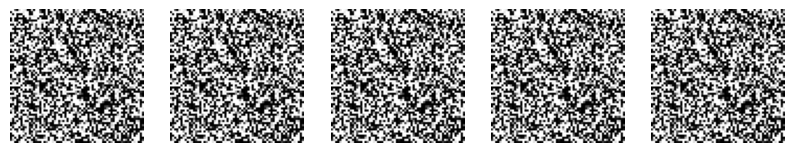

In [1403]:
# Load a few images from the directory
input_images = load_images_from_dir("/Users/norbujamling/Desktop/Generated_Characters", 5)  # Load 5 images

# Generate sample images using the input images
generated_images = generator.predict(input_images)

# Plot the generated images
plt.figure(figsize=(10, 2))
for i in range(generated_images.shape[0]):
    plt.subplot(1, 5, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')  # Displaying grayscale images
    plt.axis('off')
plt.show()
